# Create bernCrop Dataset



In [1]:
# load required modules
import cv2
import eodal
import os
import numpy as np
import h5py
import pandas as pd
import utm
import torch
from matplotlib.lines import Line2D
import seaborn as sns
import xml.etree.ElementTree as ET
from tqdm.notebook import tqdm

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from pathlib import Path
from eodal.core.sensors import Sentinel2
import geopandas as gpd
from shapely.geometry import Polygon
from eodal.config import get_settings

# make plots larger by default
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 15]

print('eodal version: {}'.format(eodal.__version__))

# we need to tell EOdal that we work using a local data source
settings = get_settings()
settings.USE_STAC = False


output_shapefile_path_BERN = f"../raw_data/LANDKULT/data/BERN_big_bbox.shp"
output_shapefile_path_tiles =f"../raw_data/LANDKULT/data/tiles/"
output_shapefile_path_tile_T32TLT = f"../raw_data/LANDKULT/data/tiles/T32TLT.shp"
output_shapefile_path_tile_T32TLS = f"../raw_data/LANDKULT/data/tiles/T32TLS.shp"
output_shapefile_path_tile_T32TMT = f"../raw_data/LANDKULT/data/tiles/T32TMT.shp"
output_shapefile_path_tile_T32TMS = f"../raw_data/LANDKULT/data/tiles/T32TMS.shp"
shapefile_path_landkult = '../raw_data/LANDKULT/data/LANDKULT_NUTZFL.shp'
output_shapefile_path_landkult = '../raw_data/LANDKULT/data/LANDKULT_NUTZFL_bern_bbox.shp'
output_shapefile_path_landkult_short = '../raw_data/LANDKULT/data/LANDKULT_NUTZFL_short_bern_bbox.shp'

eodal version: 0.2.3


In [2]:
def convert_coordinates_to_utm(coordinates):
    utm_coordinates = []
    for lat, lon in coordinates:
        utm_coordinate = utm.from_latlon(lat, lon)
        utm_coordinates.append((utm_coordinate[0], utm_coordinate[1], utm_coordinate[2], utm_coordinate[3]))
    return utm_coordinates

def get_adjacent_points(utm_coordinates):
    adjacent_coordinates_beneath = []
    for easting, northing, zone_number, zone_letter in utm_coordinates:
        # Point beneath
        right_point = utm.to_latlon(easting - 100000, northing, zone_number, zone_letter)
        adjacent_coordinates_beneath.append(right_point)
    return adjacent_coordinates_beneath

def get_bern_bbox():
    # Define the coordinates
    x1, y1, x2, y2 = 361630.,5140066., 416830.,  5238466.

    # Create a GeoDataFrame with a single Point geometry
    geometry = Polygon([(x1, y1), (x2, y1), (x2, y2), (x1, y2)])
    gdf_bern = gpd.GeoDataFrame(geometry=[geometry], crs="EPSG:32632")
    # Save the GeoDataFrame to a shapefile
    gdf_bern.to_file(output_shapefile_path_BERN)
    return gdf_bern


def get_tile_folder_path(data_dir):
    paths = []
    def get_subdirectories(path, depth=0, max_depth=0):
        if depth > max_depth:
            return

        subdirectories = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]
        for subdir in subdirectories:
            subdir_path = os.path.join(path, subdir)
            if subdir_path.endswith('.SAFE'):
                paths.append(subdir_path)
            get_subdirectories(subdir_path, depth + 1, max_depth)
    get_subdirectories(data_dir)
    # sort the paths by timestamp
    paths.sort()
    return paths


def make_polygon_within(polygon1, polygon2):
    return  polygon1.intersection(polygon2)


def read_tile_data_from_safe(tile_paths, coords, tile, band_selection = ['B02', 'B03', 'B04', 'B08'], polygon_size = 240*240, batch_size = 1000,verbose=False):
    tile_shape_path = output_shapefile_path_tiles+f'{tile}.shp'
    tile_gdf = gpd.read_file(tile_shape_path)
    total_batches = len(coords) // batch_size + int(len(coords) % batch_size > 0)

    for timestamp_index, path_SAFE in enumerate(tqdm(tile_paths, desc="Processing timestamps")):

        for batch_index, (group_index, batch_df) in enumerate(tqdm(coords.groupby(np.arange(len(coords)) // batch_size), total=total_batches, desc="Processing batches", leave=False)):
            if verbose:
                print(f'new Batch:{batch_index}')
            
            # Reset vector_feature_data for each batch
            vector_feature_data = np.empty((0, 4, 24, 24), dtype=np.float32)
            
            for vector_feature_index, coordinates in tqdm(batch_df.iterrows(), total=len(batch_df), desc="Processing features", leave=False):
                x1, y1, x2, y2 = coordinates.iloc[:4].tolist()
                polygon = Polygon([(x1, y1), (x2, y1), (x2, y2), (x1, y2)])
                polygon_gdf = gpd.GeoDataFrame(geometry=[polygon], crs='EPSG:32632')

                polygon_clipped_coords = make_polygon_within(tile_gdf.geometry[0], polygon_gdf.geometry[0])
                polygon_clipped_coords_df = gpd.GeoDataFrame(geometry=[polygon_clipped_coords], crs='EPSG:32632')
                intersection_area = polygon_clipped_coords_df.geometry.iloc[0].area

                if intersection_area == polygon_size:
                    try:
                        handler = Sentinel2.from_safe(
                            in_dir=Path(path_SAFE),
                            vector_features=polygon_clipped_coords_df,
                            band_selection=band_selection,
                            apply_scaling=False
                        )
                    except ValueError as ex:
                        if verbose:
                            print(f'error:\n{ex} but continue anyway\n Path:{path_SAFE}')
                            # save wrong polygons
                            polygon_clipped_coords_df.to_csv(f'./errors/error_polygon_{vector_feature_index}_{tile}.csv')
                        continue

                    if handler.is_blackfilled:
                        if verbose:
                            print(f"Skip is blackfilled: {path_SAFE}")
                        continue

                    handler.resample(
                        target_resolution=10,
                        interpolation_method=cv2.INTER_NEAREST_EXACT,
                        inplace=True
                    )

                    single_feature_data = handler.to_xarray().to_numpy()[0:4, 0:24, 0:24]
                    
                    # Pad with zeros if the shape is not as expected
                    if single_feature_data.shape != (4, 24, 24):
                        # Pad along the first, second, and third axes to make it (4, 24, 24)
                        pad_width = [
                            (0, max(0, 4 - single_feature_data.shape[0])),
                            (0, max(0, 24 - single_feature_data.shape[1])),
                            (0, max(0, 24 - single_feature_data.shape[2])),
                        ]
                        single_feature_data = np.pad(single_feature_data, pad_width, mode='constant', constant_values=0)

                    # Concatenate along a new axis
                    vector_feature_data = np.concatenate((vector_feature_data, np.expand_dims(single_feature_data, axis=0)), axis=0)
                    # Save after each timestamp
                    if timestamp_index == 0:
                        if verbose:
                            print("Ground-Truth data is saved!")
                        save_ground_truth_data(vector_feature_index, tile)
                else:
                    continue

            if vector_feature_data.shape[0] > 0:
                # Save the tile data after each batch
                save_tile_data(vector_feature_data, tile, add_axis=False)
                if verbose:
                    print(read_tile_data(tile, 'data').shape)
            
            

def save_tile_data(tile_array, tile,dataset_data_name="data",add_axis=True):
    file_name_tile = f'../raw_data/BernCrop/tiles/{tile}.hdf5'
    if add_axis:
        tile_array=tile_array[np.newaxis,:]
    data_shape = tile_array.shape
    
    with h5py.File(file_name_tile, 'a') as hf:
        # Check if the dataset already exists
        if dataset_data_name in hf:
            dataset = hf[dataset_data_name]
        else:
            dtype = "float32"  # Use the appropriate data type for your data
            dataset = hf.create_dataset(dataset_data_name, shape=(0,) + data_shape[1:], dtype=dtype, maxshape=(None,) + data_shape[1:])
            
        current_size = dataset.shape[0]
        new_size = current_size + tile_array.shape[0]
        # Resize the dataset to accommodate the new batch
        dataset.resize(new_size, axis=0)
        # Append the new batch to the dataset
        dataset[current_size:new_size, :] = tile_array



def save_label_data(index_data,tile):
    # Specify the file path
    file_path = fr'..\raw_data\BernCrop\tensor_label_24x24.pt'
    # Load the tensor from the file
    all_labels = torch.load(file_path)
    data_label = all_labels[index_data]

    save_tile_data(data_label,tile,'gt')

def save_field_label_data(index_data,tile):
    # Specify the file path
    file_path = fr'..\raw_data\BernCrop\tensor_field_24x24.pt'

    # Load the tensor from the file
    all_labels = torch.load(file_path)
    data_label = all_labels[index_data]

    save_tile_data(data_label,tile,'gt_instance')

def save_ground_truth_data(index_data,tile):

    save_label_data(index_data,tile)
    save_field_label_data(index_data,tile)
    

def read_tile_data(tile,dataset_data_name="data",):
    filename_tile = f'../raw_data/BernCrop/tiles/{tile}.hdf5'
    # Open the HDF5 file in read mode
    with h5py.File(filename_tile, "r") as file:
        # Check if the "data" dataset exists in the file
        if dataset_data_name in file:
            # Access the dataset and read its contents into a NumPy array
            dataset = file[dataset_data_name][:]
        else:
            print(f"Dataset {dataset_data_name} not found in the HDF5 file.")
    return dataset

def get_coords(tile=None,is_short=False):
    if tile == None:
        coords = pd.read_csv(r'..\raw_data\BernCrop\bboxes_sentinel_24x24.csv',index_col=None)
        coords= coords.iloc[:, 1:5]
    else:
        if is_short:
            coords = pd.read_csv(fr'..\raw_data\BernCrop\bboxes_sentinel_24x24_{tile}_short.csv',index_col=None)
        else:
            coords = pd.read_csv(fr'..\raw_data\BernCrop\bboxes_sentinel_24x24_{tile}.csv',index_col=None)
        coords= coords.iloc[:, 1:5]
    return coords


def stack_sample_tiles(tile_array,minimal_t=10,):
    if minimal_t != None:
        tile_array = np.transpose(tile_array, (1, 0, 3, 4,2))
        sampled_indices = np.random.choice(tile_array.shape[1], size=minimal_t, replace=False)
        tile_array = tile_array[:,sampled_indices]
    # tile_array_return = np.expand_dims(tile_array, axis=0)
    return tile_array



In [3]:
coordinates_T32TLT = [(6.3279, 46.8356), (7.8166, 46.8356), (7.8166, 47.8474), (6.3279, 47.8474)]
polygon_T32TLT = Polygon(coordinates_T32TLT)
gdf_T32TLT = gpd.GeoDataFrame(geometry=[polygon_T32TLT],crs="EPSG:4326").to_crs(crs="EPSG:32632")
gdf_T32TLT.to_file(output_shapefile_path_tile_T32TLT)

utm_coordinates_T32TLS = convert_coordinates_to_utm(coordinates_T32TLT)
coordinates_T32TLS = get_adjacent_points(utm_coordinates_T32TLS)
polygon_T32TLS = Polygon(coordinates_T32TLS)
gdf_T32TLS = gpd.GeoDataFrame(geometry=[polygon_T32TLS],crs="EPSG:4326").to_crs(crs="EPSG:32632")
gdf_T32TLS.to_file(output_shapefile_path_tile_T32TLS)

coordinates_T32TMT = [(7.6629, 46.8582), (9.1305, 46.8582), (9.1305, 47.8536), (7.6629, 47.8536)]
polygon_T32TMT = Polygon(coordinates_T32TMT)
gdf_T32TMT = gpd.GeoDataFrame(geometry=[polygon_T32TMT],crs="EPSG:4326").to_crs(crs="EPSG:32632")
gdf_T32TMT.to_file(output_shapefile_path_tile_T32TMT)

utm_coordinates_T32TMS= convert_coordinates_to_utm(coordinates_T32TMT)
coordinates_T32TMS = get_adjacent_points(utm_coordinates_T32TMS)
polygon_T32TMS = Polygon(coordinates_T32TMS)
gdf_T32TMS = gpd.GeoDataFrame(geometry=[polygon_T32TMS],crs="EPSG:4326").to_crs(crs="EPSG:32632")
gdf_T32TMS.to_file(output_shapefile_path_tile_T32TMS)

In [4]:
# remove duplicates from all tiles
T32TLS= pd.read_csv(r'../raw_data/BernCrop/bboxes_sentinel_24x24_T32TLS.csv',index_col=[0])
T32TMT = pd.read_csv(r'../raw_data/BernCrop/bboxes_sentinel_24x24_T32TMT.csv',index_col=[0])
T32TLT = pd.read_csv(r'../raw_data/BernCrop/bboxes_sentinel_24x24_T32TLT.csv',index_col=[0])
T32TMS= pd.read_csv(r'../raw_data/BernCrop/bboxes_sentinel_24x24_T32TMS.csv',index_col=[0])

T32TMT[~T32TMT.index.isin(T32TLS.index)].to_csv(r'../raw_data/BernCrop/bboxes_sentinel_24x24_T32TMT_.csv')
T32TLT[T32TLT.index.isin(T32TLS.index)].to_csv(r'../raw_data/BernCrop/bboxes_sentinel_24x24_T32TLT_.csv')
T32TMS[T32TMS.index.isin(T32TLS.index)].to_csv(r'../raw_data/BernCrop/bboxes_sentinel_24x24_T32TMS_.csv')

In [5]:
tiles = ['T32TLT','T32TMT','T32TMS','T32TLS']

In [6]:
for tile in tiles:
    tile_shape_path = output_shapefile_path_tiles+f'{tile}.shp'
    tile_gdf = gpd.read_file(tile_shape_path,crs='EPSG:32632')

    coords = pd.read_csv(r'..\raw_data\BernCrop\bboxes_sentinel_24x24.csv',index_col=[0])
    coords.sort_index(ascending=True)
    geometry = [Polygon([(x1, y1), (x2, y1), (x2, y2), (x1, y2)]) for x1, y1,x2,y2 in zip(coords['x1'], coords['y1'],coords['x2'], coords['y2'])]
    gdf = gpd.GeoDataFrame(coords, geometry=geometry)
    completely_inside_polygons = gdf[gdf.geometry.within(tile_gdf.geometry.iloc[0])]
    completely_inside_polygons = completely_inside_polygons[completely_inside_polygons.geometry.within(get_bern_bbox().geometry.iloc[0])]
    completely_inside_polygons.to_csv(fr'../raw_data/BernCrop/bboxes_sentinel_24x24_{tile}.csv')


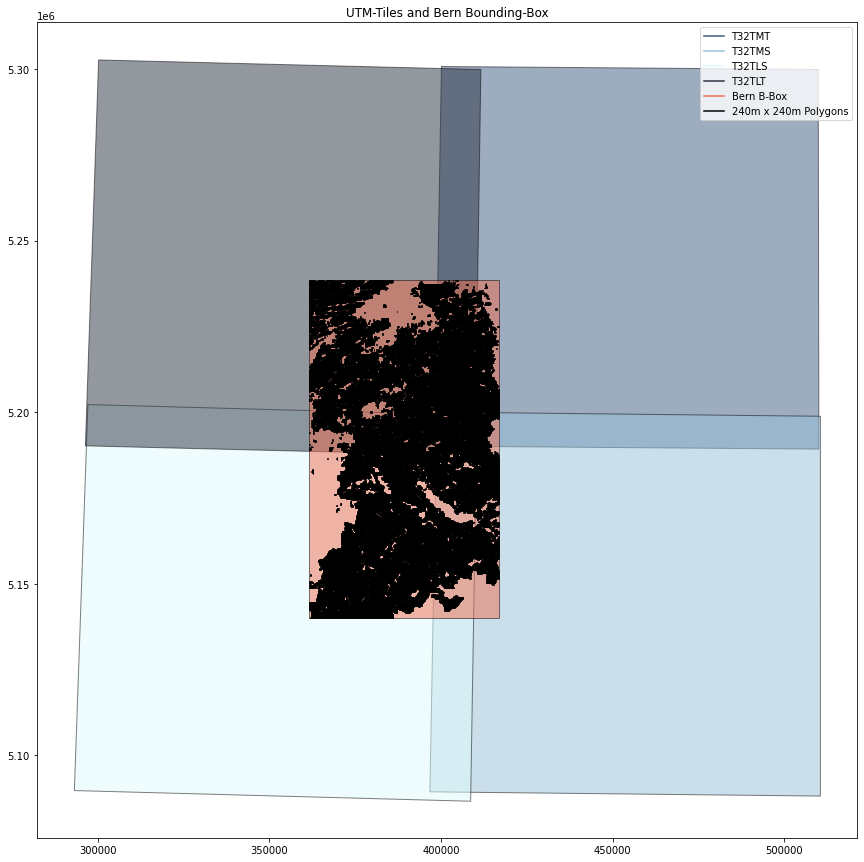

In [7]:
coords= get_coords()
# Create a GeoPandas GeoDataFrame
geometry = [Polygon([(row['x1'], row['y1']), (row['x2'], row['y1']),
                (row['x2'], row['y2']), (row['x1'], row['y2'])])
        for _, row in coords.iterrows()]

gdf_polygons = gpd.GeoDataFrame(geometry=geometry)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(24, 15))

# Plot GeoDataFrames
gdf_T32TMT.plot(ax=ax, color='#3d5a80', edgecolor='black', alpha=0.5)
gdf_T32TMS.plot(ax=ax, color='#98c1d9', edgecolor='black', alpha=0.5)
gdf_T32TLS.plot(ax=ax, color='#e0fbfc', edgecolor='black', alpha=0.5)
gdf_T32TLT.plot(ax=ax, color='#293241', edgecolor='black', alpha=0.5)
get_bern_bbox().plot(ax=ax, color='#ee6c4d', edgecolor='black', alpha=0.5)
gdf_polygons.plot(ax=ax, color='black', edgecolor='black', alpha=0.7)

ax.set_title('UTM-Tiles and Bern Bounding-Box')

# Create a custom legend using Line2D for GeoPandas plots
legend_elements = [
    Line2D([0], [0], color='#3d5a80', label='T32TMT'),
    Line2D([0], [0], color='#98c1d9', label='T32TMS'),
    Line2D([0], [0], color='#e0fbfc', label='T32TLS'),
    Line2D([0], [0], color='#293241', label='T32TLT'),
    Line2D([0], [0], color='#ee6c4d', label='Bern B-Box'),
    Line2D([0], [0], color='black',label='240m x 240m Polygons')
]

# Add the legend outside the plot
ax.legend(handles=legend_elements, loc='upper right')

# Show the plot
plt.show()


E:\S2_Data_CH22_Original\T32TLT\S2A_MSIL2A_20220107T104431_N0301_R008_T32TLT_20220107T133719.SAFE\INSPIRE.xml


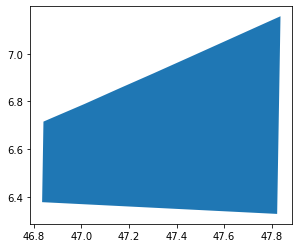

E:\S2_Data_CH22_Original\T32TLT\S2A_MSIL2A_20220114T103401_N0301_R108_T32TLT_20220114T132749.SAFE\INSPIRE.xml


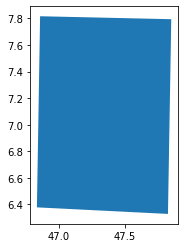

E:\S2_Data_CH22_Original\T32TLT\S2A_MSIL2A_20220124T103331_N0301_R108_T32TLT_20220124T163734.SAFE\INSPIRE.xml


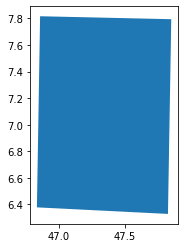

E:\S2_Data_CH22_Original\T32TLT\S2A_MSIL2A_20220127T104321_N0400_R008_T32TLT_20220127T151103.SAFE\INSPIRE.xml


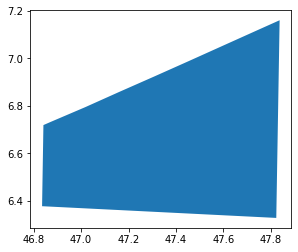

E:\S2_Data_CH22_Original\T32TLT\S2A_MSIL2A_20220213T103131_N0400_R108_T32TLT_20220213T152822.SAFE\INSPIRE.xml


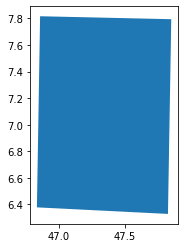

E:\S2_Data_CH22_Original\T32TLT\S2A_MSIL2A_20220223T103031_N0400_R108_T32TLT_20220223T154141.SAFE\INSPIRE.xml


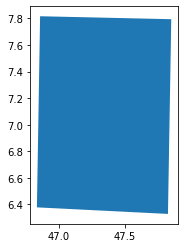

E:\S2_Data_CH22_Original\T32TLT\S2A_MSIL2A_20220226T104011_N0400_R008_T32TLT_20220226T135412.SAFE\INSPIRE.xml


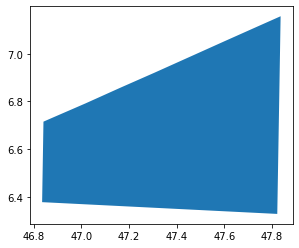

E:\S2_Data_CH22_Original\T32TLT\S2A_MSIL2A_20220305T102921_N0400_R108_T32TLT_20220305T135811.SAFE\INSPIRE.xml


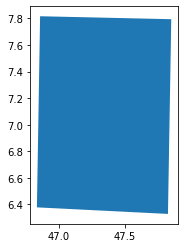

E:\S2_Data_CH22_Original\T32TLT\S2A_MSIL2A_20220308T103901_N0400_R008_T32TLT_20220308T142755.SAFE\INSPIRE.xml


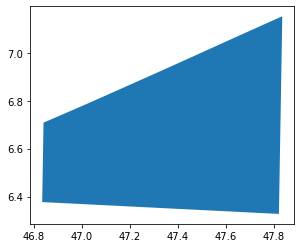

E:\S2_Data_CH22_Original\T32TLT\S2A_MSIL2A_20220325T102651_N0400_R108_T32TLT_20220325T162307.SAFE\INSPIRE.xml


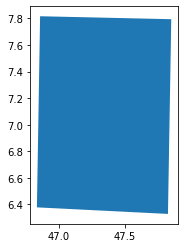

E:\S2_Data_CH22_Original\T32TLT\S2A_MSIL2A_20220328T103641_N0400_R008_T32TLT_20220328T140800.SAFE\INSPIRE.xml


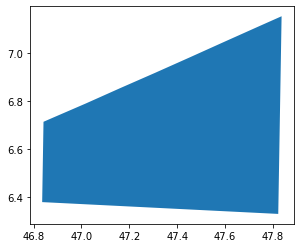

E:\S2_Data_CH22_Original\T32TLT\S2A_MSIL2A_20220404T102601_N0400_R108_T32TLT_20220404T135834.SAFE\INSPIRE.xml


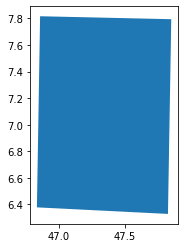

E:\S2_Data_CH22_Original\T32TLT\S2A_MSIL2A_20220414T102601_N0400_R108_T32TLT_20220414T155046.SAFE\INSPIRE.xml


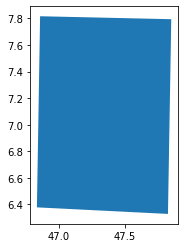

E:\S2_Data_CH22_Original\T32TLT\S2A_MSIL2A_20220417T103631_N0400_R008_T32TLT_20220417T144456.SAFE\INSPIRE.xml


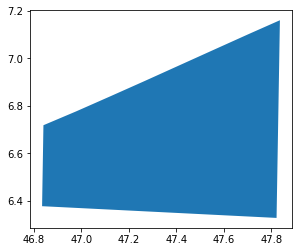

E:\S2_Data_CH22_Original\T32TLT\S2A_MSIL2A_20220427T103631_N0400_R008_T32TLT_20220427T145849.SAFE\INSPIRE.xml


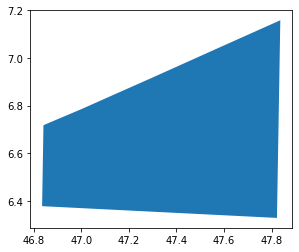

E:\S2_Data_CH22_Original\T32TLT\S2A_MSIL2A_20220504T102601_N0400_R108_T32TLT_20220504T185514.SAFE\INSPIRE.xml


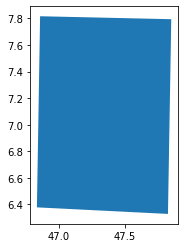

E:\S2_Data_CH22_Original\T32TLT\S2A_MSIL2A_20220507T103631_N0400_R008_T32TLT_20220507T154214.SAFE\INSPIRE.xml


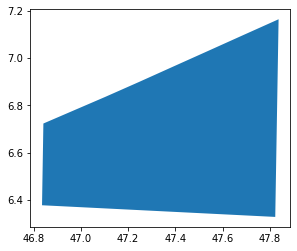

E:\S2_Data_CH22_Original\T32TLT\S2A_MSIL2A_20220514T102601_N0400_R108_T32TLT_20220514T165714.SAFE\INSPIRE.xml


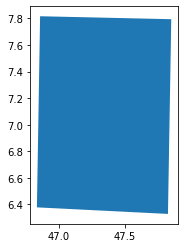

E:\S2_Data_CH22_Original\T32TLT\S2A_MSIL2A_20220517T103631_N0400_R008_T32TLT_20220517T185014.SAFE\INSPIRE.xml


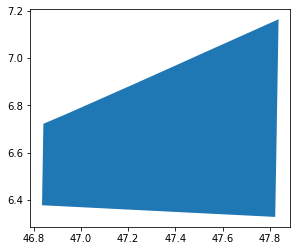

E:\S2_Data_CH22_Original\T32TLT\S2A_MSIL2A_20220524T102611_N0400_R108_T32TLT_20220524T164211.SAFE\INSPIRE.xml


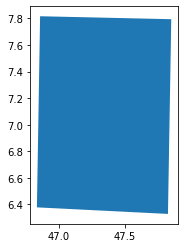

E:\S2_Data_CH22_Original\T32TLT\S2A_MSIL2A_20220524T102611_N9999_R108_T32TLT_20230104T033227.SAFE\INSPIRE.xml


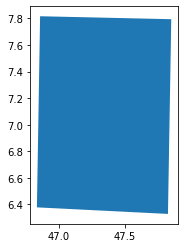

E:\S2_Data_CH22_Original\T32TLT\S2A_MSIL2A_20220527T103631_N0400_R008_T32TLT_20220527T183616.SAFE\INSPIRE.xml


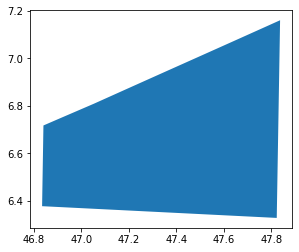

E:\S2_Data_CH22_Original\T32TLT\S2A_MSIL2A_20220606T103631_N0400_R008_T32TLT_20220606T183320.SAFE\INSPIRE.xml


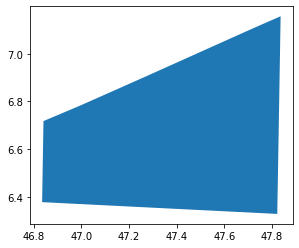

E:\S2_Data_CH22_Original\T32TLT\S2A_MSIL2A_20220613T103031_N0400_R108_T32TLT_20220613T235021.SAFE\INSPIRE.xml


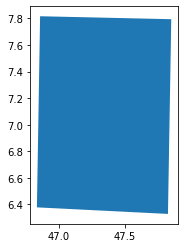

E:\S2_Data_CH22_Original\T32TLT\S2A_MSIL2A_20220616T103631_N0400_R008_T32TLT_20220616T202909.SAFE\INSPIRE.xml


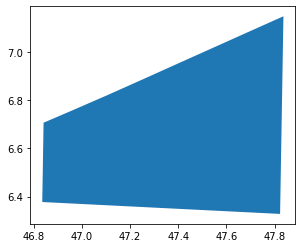

E:\S2_Data_CH22_Original\T32TLT\S2A_MSIL2A_20220616T103631_N9999_R008_T32TLT_20221230T095234.SAFE\INSPIRE.xml


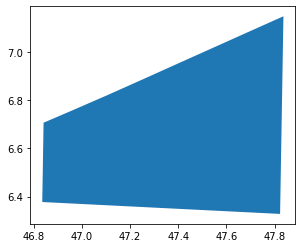

E:\S2_Data_CH22_Original\T32TLT\S2A_MSIL2A_20220623T103031_N0400_R108_T32TLT_20220623T170319.SAFE\INSPIRE.xml


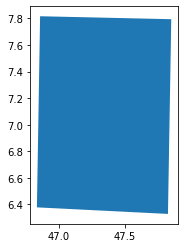

E:\S2_Data_CH22_Original\T32TLT\S2A_MSIL2A_20220623T103031_N9999_R108_T32TLT_20230101T132525.SAFE\INSPIRE.xml


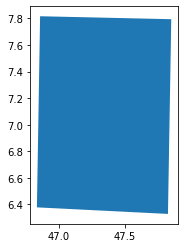

E:\S2_Data_CH22_Original\T32TLT\S2A_MSIL2A_20220703T102611_N0400_R108_T32TLT_20220703T182512.SAFE\INSPIRE.xml


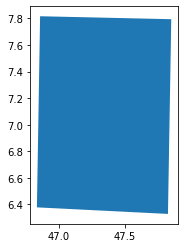

E:\S2_Data_CH22_Original\T32TLT\S2A_MSIL2A_20220706T103641_N0400_R008_T32TLT_20220706T183816.SAFE\INSPIRE.xml


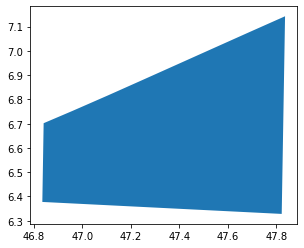

E:\S2_Data_CH22_Original\T32TLT\S2A_MSIL2A_20220713T103041_N0400_R108_T32TLT_20220713T164557.SAFE\INSPIRE.xml


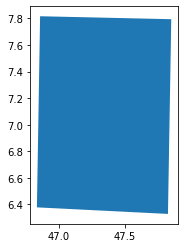

E:\S2_Data_CH22_Original\T32TLT\S2A_MSIL2A_20220716T103641_N0400_R008_T32TLT_20220716T183414.SAFE\INSPIRE.xml


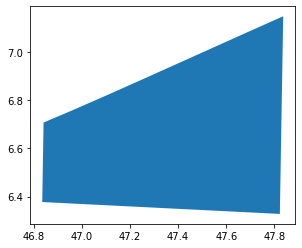

E:\S2_Data_CH22_Original\T32TLT\S2A_MSIL2A_20220723T102611_N0400_R108_T32TLT_20220723T164456.SAFE\INSPIRE.xml


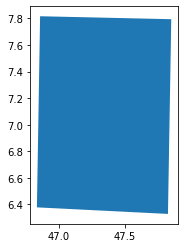

E:\S2_Data_CH22_Original\T32TLT\S2A_MSIL2A_20220726T103631_N0400_R008_T32TLT_20220726T201057.SAFE\INSPIRE.xml


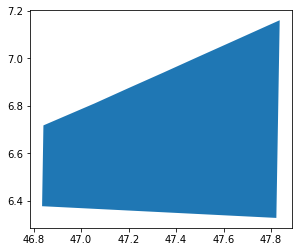

E:\S2_Data_CH22_Original\T32TLT\S2A_MSIL2A_20220802T102611_N0400_R108_T32TLT_20220802T184101.SAFE\INSPIRE.xml


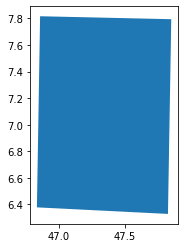

E:\S2_Data_CH22_Original\T32TLT\S2A_MSIL2A_20220805T103631_N0400_R008_T32TLT_20220805T183602.SAFE\INSPIRE.xml


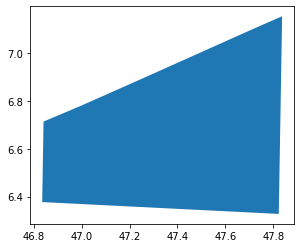

E:\S2_Data_CH22_Original\T32TLT\S2A_MSIL2A_20220812T103031_N0400_R108_T32TLT_20220812T182800.SAFE\INSPIRE.xml


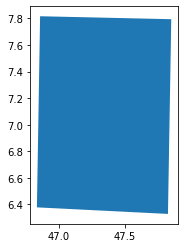

E:\S2_Data_CH22_Original\T32TLT\S2A_MSIL2A_20220822T102611_N0400_R108_T32TLT_20220822T184205.SAFE\INSPIRE.xml


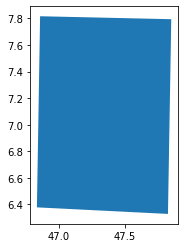

E:\S2_Data_CH22_Original\T32TLT\S2A_MSIL2A_20220825T103641_N0400_R008_T32TLT_20220825T201458.SAFE\INSPIRE.xml


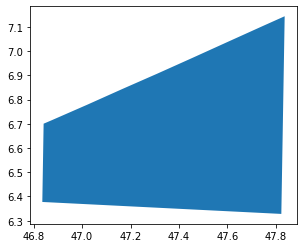

E:\S2_Data_CH22_Original\T32TLT\S2A_MSIL2A_20220901T102611_N0400_R108_T32TLT_20220901T182256.SAFE\INSPIRE.xml


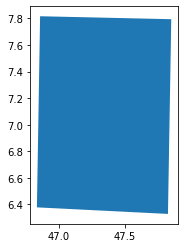

E:\S2_Data_CH22_Original\T32TLT\S2A_MSIL2A_20220904T103641_N0400_R008_T32TLT_20220904T183007.SAFE\INSPIRE.xml


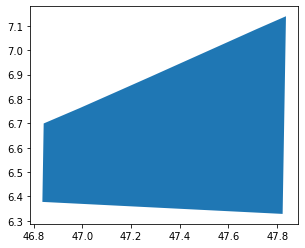

E:\S2_Data_CH22_Original\T32TLT\S2A_MSIL2A_20220911T102621_N0400_R108_T32TLT_20220911T165754.SAFE\INSPIRE.xml


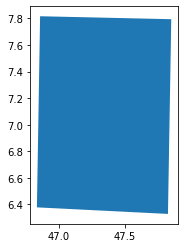

E:\S2_Data_CH22_Original\T32TLT\S2A_MSIL2A_20220921T102731_N0400_R108_T32TLT_20220921T164458.SAFE\INSPIRE.xml


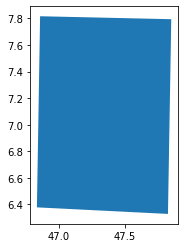

E:\S2_Data_CH22_Original\T32TLT\S2A_MSIL2A_20221004T103911_N0400_R008_T32TLT_20221004T155900.SAFE\INSPIRE.xml


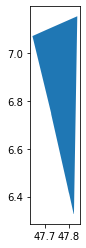

E:\S2_Data_CH22_Original\T32TLT\S2A_MSIL2A_20221004T103911_N0400_R008_T32TLT_20221004T182854.SAFE\INSPIRE.xml


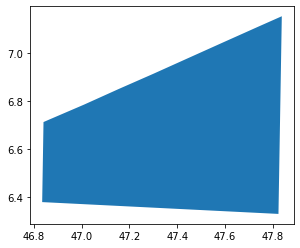

E:\S2_Data_CH22_Original\T32TLT\S2A_MSIL2A_20221011T102951_N0400_R108_T32TLT_20221011T163653.SAFE\INSPIRE.xml


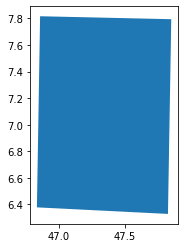

E:\S2_Data_CH22_Original\T32TLT\S2A_MSIL2A_20221031T103151_N0400_R108_T32TLT_20221031T164300.SAFE\INSPIRE.xml


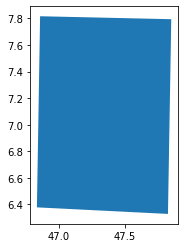

E:\S2_Data_CH22_Original\T32TLT\S2A_MSIL2A_20221110T103251_N0400_R108_T32TLT_20221110T163904.SAFE\INSPIRE.xml


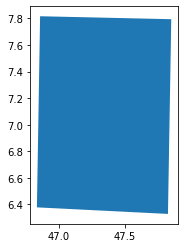

E:\S2_Data_CH22_Original\T32TLT\S2A_MSIL2A_20221113T104311_N0400_R008_T32TLT_20221113T155653.SAFE\INSPIRE.xml


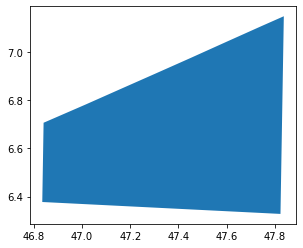

E:\S2_Data_CH22_Original\T32TLT\S2A_MSIL2A_20221120T103331_N0400_R108_T32TLT_20221120T164159.SAFE\INSPIRE.xml


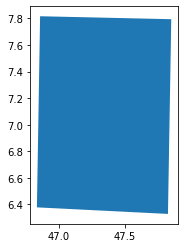

E:\S2_Data_CH22_Original\T32TLT\S2A_MSIL2A_20221123T104351_N0400_R008_T32TLT_20221123T155652.SAFE\INSPIRE.xml


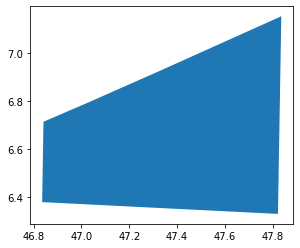

E:\S2_Data_CH22_Original\T32TLT\S2A_MSIL2A_20221220T103441_N0509_R108_T32TLT_20221220T134756.SAFE\INSPIRE.xml


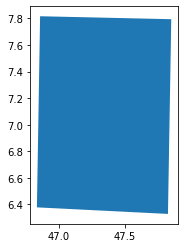

E:\S2_Data_CH22_Original\T32TLT\S2B_MSIL2A_20220109T103319_N0301_R108_T32TLT_20220109T121931.SAFE\INSPIRE.xml


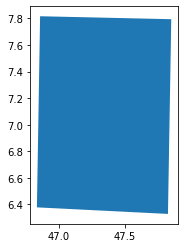

E:\S2_Data_CH22_Original\T32TLT\S2B_MSIL2A_20220112T104319_N0301_R008_T32TLT_20220112T123824.SAFE\INSPIRE.xml


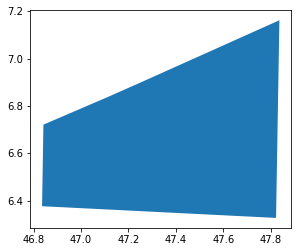

E:\S2_Data_CH22_Original\T32TLT\S2B_MSIL2A_20220119T103249_N0301_R108_T32TLT_20220119T121956.SAFE\INSPIRE.xml


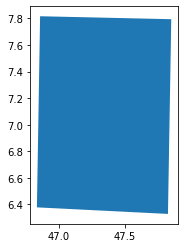

E:\S2_Data_CH22_Original\T32TLT\S2B_MSIL2A_20220122T104239_N0301_R008_T32TLT_20220122T121827.SAFE\INSPIRE.xml


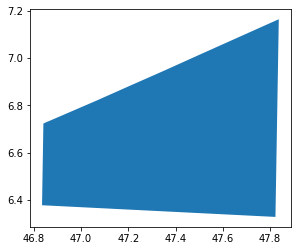

E:\S2_Data_CH22_Original\T32TLT\S2B_MSIL2A_20220129T103159_N0400_R108_T32TLT_20220129T120945.SAFE\INSPIRE.xml


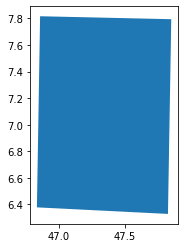

E:\S2_Data_CH22_Original\T32TLT\S2B_MSIL2A_20220208T103109_N0400_R108_T32TLT_20220208T143549.SAFE\INSPIRE.xml


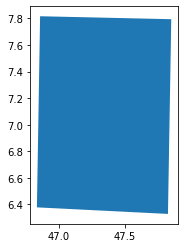

E:\S2_Data_CH22_Original\T32TLT\S2B_MSIL2A_20220211T104049_N0400_R008_T32TLT_20220211T145400.SAFE\INSPIRE.xml


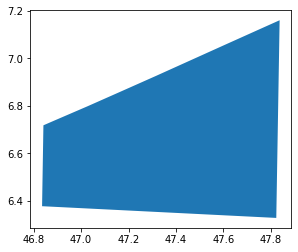

E:\S2_Data_CH22_Original\T32TLT\S2B_MSIL2A_20220218T102949_N0400_R108_T32TLT_20220218T143251.SAFE\INSPIRE.xml


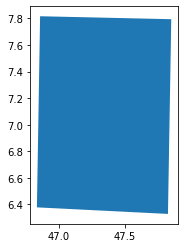

E:\S2_Data_CH22_Original\T32TLT\S2B_MSIL2A_20220228T102849_N0400_R108_T32TLT_20220228T134712.SAFE\INSPIRE.xml


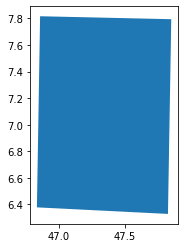

E:\S2_Data_CH22_Original\T32TLT\S2B_MSIL2A_20220303T103839_N0400_R008_T32TLT_20220304T191818.SAFE\INSPIRE.xml


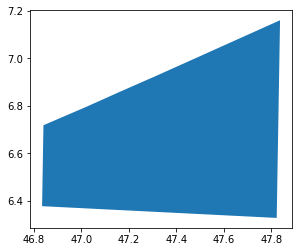

E:\S2_Data_CH22_Original\T32TLT\S2B_MSIL2A_20220310T102739_N0400_R108_T32TLT_20220310T134645.SAFE\INSPIRE.xml


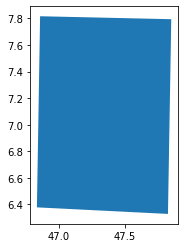

E:\S2_Data_CH22_Original\T32TLT\S2B_MSIL2A_20220313T103729_N0400_R008_T32TLT_20220313T140234.SAFE\INSPIRE.xml


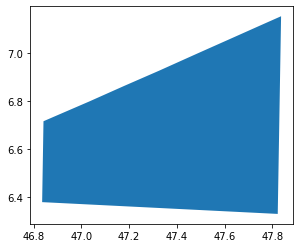

E:\S2_Data_CH22_Original\T32TLT\S2B_MSIL2A_20220320T102639_N0400_R108_T32TLT_20220320T135549.SAFE\INSPIRE.xml


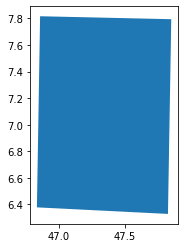

E:\S2_Data_CH22_Original\T32TLT\S2B_MSIL2A_20220323T103639_N0400_R008_T32TLT_20220323T140421.SAFE\INSPIRE.xml


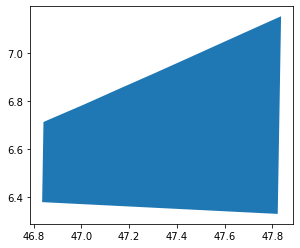

E:\S2_Data_CH22_Original\T32TLT\S2B_MSIL2A_20220412T103619_N0400_R008_T32TLT_20220412T141006.SAFE\INSPIRE.xml


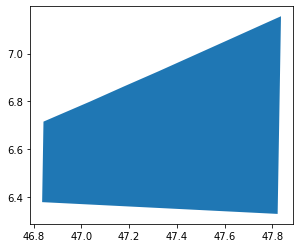

E:\S2_Data_CH22_Original\T32TLT\S2B_MSIL2A_20220419T102559_N0400_R108_T32TLT_20220419T140845.SAFE\INSPIRE.xml


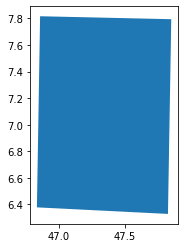

E:\S2_Data_CH22_Original\T32TLT\S2B_MSIL2A_20220422T103619_N0400_R008_T32TLT_20220422T130947.SAFE\INSPIRE.xml


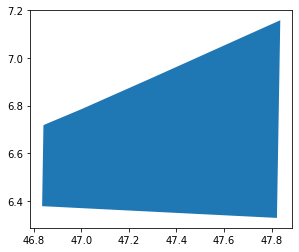

E:\S2_Data_CH22_Original\T32TLT\S2B_MSIL2A_20220502T103619_N0400_R008_T32TLT_20220502T123919.SAFE\INSPIRE.xml


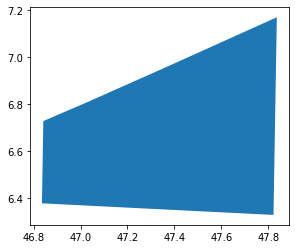

E:\S2_Data_CH22_Original\T32TLT\S2B_MSIL2A_20220509T102559_N0400_R108_T32TLT_20220509T152416.SAFE\INSPIRE.xml


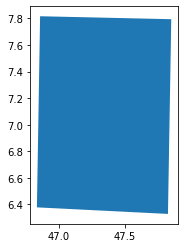

E:\S2_Data_CH22_Original\T32TLT\S2B_MSIL2A_20220512T103619_N0400_R008_T32TLT_20220512T123657.SAFE\INSPIRE.xml


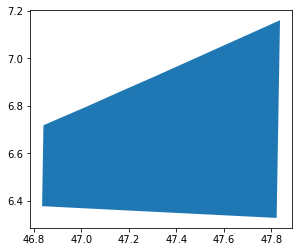

E:\S2_Data_CH22_Original\T32TLT\S2B_MSIL2A_20220519T102559_N0400_R108_T32TLT_20220519T165606.SAFE\INSPIRE.xml


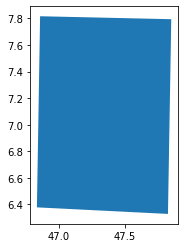

E:\S2_Data_CH22_Original\T32TLT\S2B_MSIL2A_20220519T102559_N0400_R108_T32TLT_20220720T150500.SAFE\INSPIRE.xml


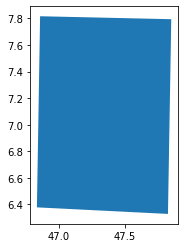

E:\S2_Data_CH22_Original\T32TLT\S2B_MSIL2A_20220529T102559_N0400_R108_T32TLT_20220529T134240.SAFE\INSPIRE.xml


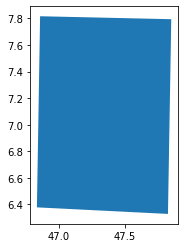

E:\S2_Data_CH22_Original\T32TLT\S2B_MSIL2A_20220611T103629_N0400_R008_T32TLT_20220611T123558.SAFE\INSPIRE.xml


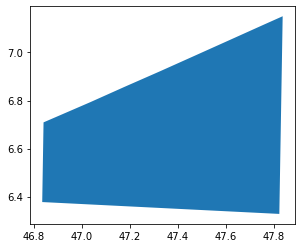

E:\S2_Data_CH22_Original\T32TLT\S2B_MSIL2A_20220618T102559_N0400_R108_T32TLT_20220618T135630.SAFE\INSPIRE.xml


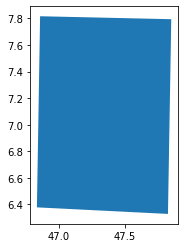

E:\S2_Data_CH22_Original\T32TLT\S2B_MSIL2A_20220621T103629_N0400_R008_T32TLT_20220621T123636.SAFE\INSPIRE.xml


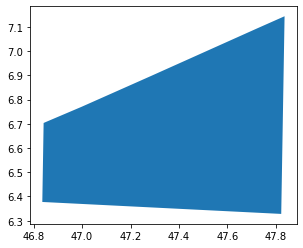

E:\S2_Data_CH22_Original\T32TLT\S2B_MSIL2A_20220628T102609_N0400_R108_T32TLT_20220628T133556.SAFE\INSPIRE.xml


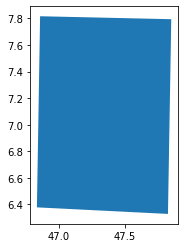

E:\S2_Data_CH22_Original\T32TLT\S2B_MSIL2A_20220701T103629_N0400_R008_T32TLT_20220701T122344.SAFE\INSPIRE.xml


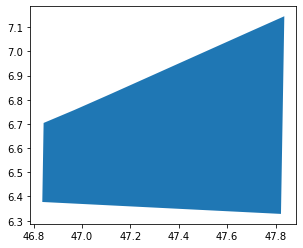

E:\S2_Data_CH22_Original\T32TLT\S2B_MSIL2A_20220708T102559_N0400_R108_T32TLT_20220708T131740.SAFE\INSPIRE.xml


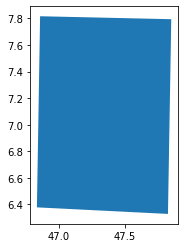

E:\S2_Data_CH22_Original\T32TLT\S2B_MSIL2A_20220711T103629_N0400_R008_T32TLT_20220711T121934.SAFE\INSPIRE.xml


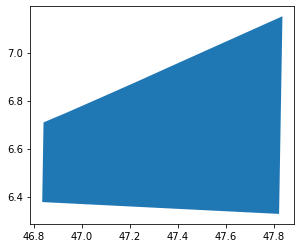

E:\S2_Data_CH22_Original\T32TLT\S2B_MSIL2A_20220718T102559_N0400_R108_T32TLT_20220718T133811.SAFE\INSPIRE.xml


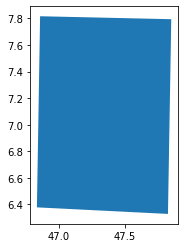

E:\S2_Data_CH22_Original\T32TLT\S2B_MSIL2A_20220721T103629_N0400_R008_T32TLT_20220721T122634.SAFE\INSPIRE.xml


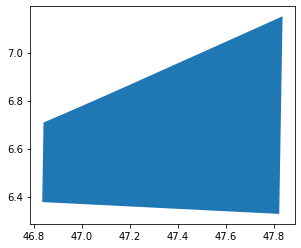

E:\S2_Data_CH22_Original\T32TLT\S2B_MSIL2A_20220728T102559_N0400_R108_T32TLT_20220728T145738.SAFE\INSPIRE.xml


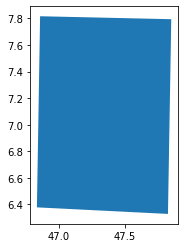

E:\S2_Data_CH22_Original\T32TLT\S2B_MSIL2A_20220731T103629_N0400_R008_T32TLT_20220731T121829.SAFE\INSPIRE.xml


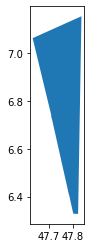

E:\S2_Data_CH22_Original\T32TLT\S2B_MSIL2A_20220731T103629_N0400_R008_T32TLT_20220731T133607.SAFE\INSPIRE.xml


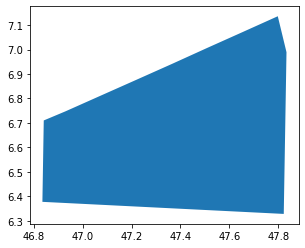

E:\S2_Data_CH22_Original\T32TLT\S2B_MSIL2A_20220807T102559_N0400_R108_T32TLT_20220807T132122.SAFE\INSPIRE.xml


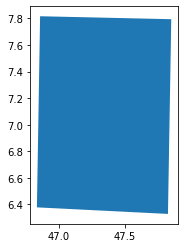

E:\S2_Data_CH22_Original\T32TLT\S2B_MSIL2A_20220810T103629_N0400_R008_T32TLT_20220810T121256.SAFE\INSPIRE.xml


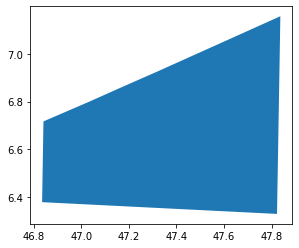

E:\S2_Data_CH22_Original\T32TLT\S2B_MSIL2A_20220817T102559_N0400_R108_T32TLT_20220817T132522.SAFE\INSPIRE.xml


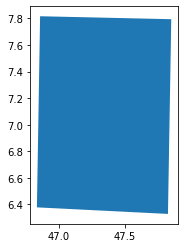

E:\S2_Data_CH22_Original\T32TLT\S2B_MSIL2A_20220820T103629_N0400_R008_T32TLT_20220831T211751.SAFE\INSPIRE.xml


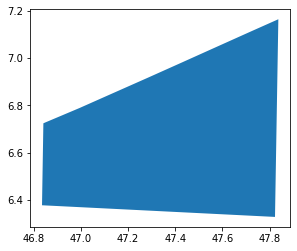

E:\S2_Data_CH22_Original\T32TLT\S2B_MSIL2A_20220827T102559_N0400_R108_T32TLT_20220827T132155.SAFE\INSPIRE.xml


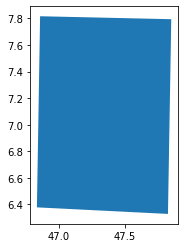

E:\S2_Data_CH22_Original\T32TLT\S2B_MSIL2A_20220830T103629_N0400_R008_T32TLT_20220830T123406.SAFE\INSPIRE.xml


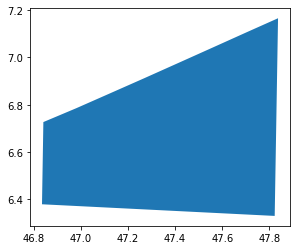

E:\S2_Data_CH22_Original\T32TLT\S2B_MSIL2A_20220909T103629_N0400_R008_T32TLT_20220909T133244.SAFE\INSPIRE.xml


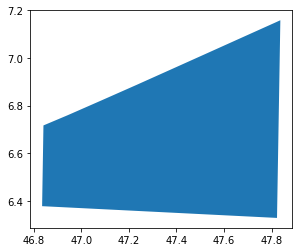

E:\S2_Data_CH22_Original\T32TLT\S2B_MSIL2A_20220916T102639_N0400_R108_T32TLT_20220916T131746.SAFE\INSPIRE.xml


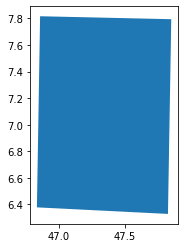

E:\S2_Data_CH22_Original\T32TLT\S2B_MSIL2A_20220919T103639_N0400_R008_T32TLT_20220919T132748.SAFE\INSPIRE.xml


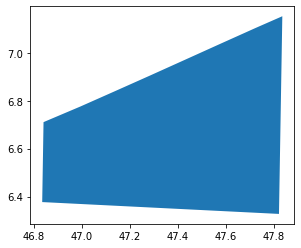

E:\S2_Data_CH22_Original\T32TLT\S2B_MSIL2A_20221006T102949_N0400_R108_T32TLT_20221006T181350.SAFE\INSPIRE.xml


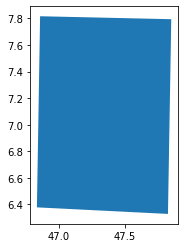

E:\S2_Data_CH22_Original\T32TLT\S2B_MSIL2A_20221009T103839_N0400_R008_T32TLT_20221009T132836.SAFE\INSPIRE.xml


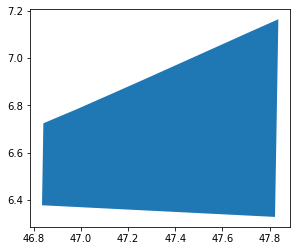

E:\S2_Data_CH22_Original\T32TLT\S2B_MSIL2A_20221016T102919_N0400_R108_T32TLT_20221016T131725.SAFE\INSPIRE.xml


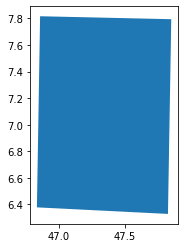

E:\S2_Data_CH22_Original\T32TLT\S2B_MSIL2A_20221019T103949_N0400_R008_T32TLT_20221019T132839.SAFE\INSPIRE.xml


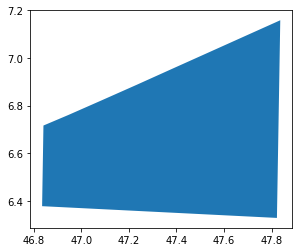

E:\S2_Data_CH22_Original\T32TLT\S2B_MSIL2A_20221026T103029_N0400_R108_T32TLT_20221026T132935.SAFE\INSPIRE.xml


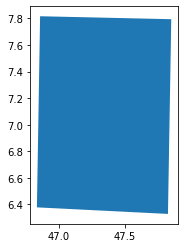

E:\S2_Data_CH22_Original\T32TLT\S2B_MSIL2A_20221029T104049_N0400_R008_T32TLT_20221029T132751.SAFE\INSPIRE.xml


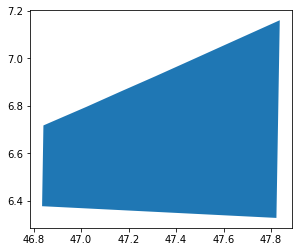

E:\S2_Data_CH22_Original\T32TLT\S2B_MSIL2A_20221108T104149_N0400_R008_T32TLT_20221108T115017.SAFE\INSPIRE.xml


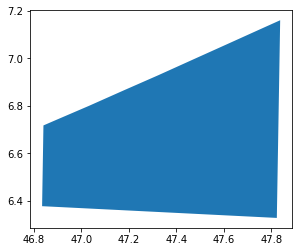

E:\S2_Data_CH22_Original\T32TLT\S2B_MSIL2A_20221125T103259_N0400_R108_T32TLT_20221125T113610.SAFE\INSPIRE.xml


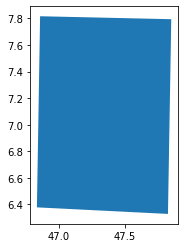

E:\S2_Data_CH22_Original\T32TLT\S2B_MSIL2A_20221205T103319_N0400_R108_T32TLT_20221205T113923.SAFE\INSPIRE.xml


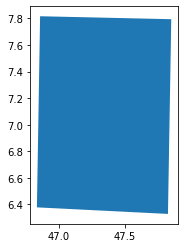

E:\S2_Data_CH22_Original\T32TLT\S2B_MSIL2A_20221208T104329_N0509_R008_T32TLT_20221208T120942.SAFE\INSPIRE.xml


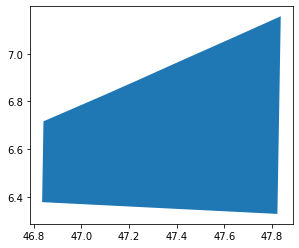

E:\S2_Data_CH22_Original\T32TLT\S2B_MSIL2A_20221228T104349_N0509_R008_T32TLT_20221228T120549.SAFE\INSPIRE.xml


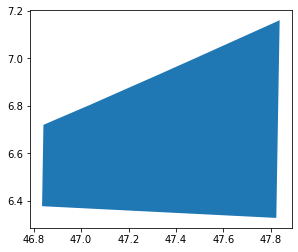

E:\S2_Data_CH22_Original\T32TMT\S2A_MSIL2A_20220101T102431_N0301_R065_T32TMT_20220101T133200.SAFE\INSPIRE.xml


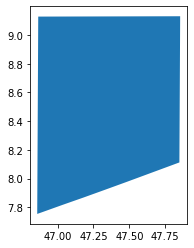

E:\S2_Data_CH22_Original\T32TMT\S2A_MSIL2A_20220111T102411_N0301_R065_T32TMT_20220111T114945.SAFE\INSPIRE.xml


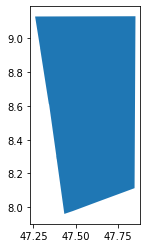

E:\S2_Data_CH22_Original\T32TMT\S2A_MSIL2A_20220111T102411_N0301_R065_T32TMT_20220111T131516.SAFE\INSPIRE.xml


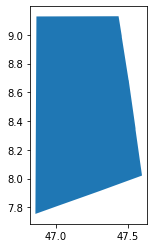

E:\S2_Data_CH22_Original\T32TMT\S2A_MSIL2A_20220114T103401_N0301_R108_T32TMT_20220114T132749.SAFE\INSPIRE.xml


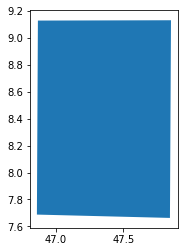

E:\S2_Data_CH22_Original\T32TMT\S2A_MSIL2A_20220121T102331_N0301_R065_T32TMT_20220121T131536.SAFE\INSPIRE.xml


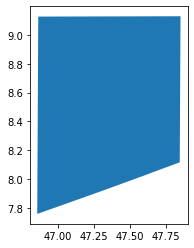

E:\S2_Data_CH22_Original\T32TMT\S2A_MSIL2A_20220124T103331_N0301_R108_T32TMT_20220124T163734.SAFE\INSPIRE.xml


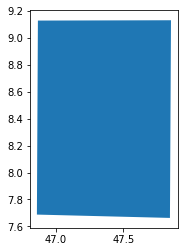

E:\S2_Data_CH22_Original\T32TMT\S2A_MSIL2A_20220210T102151_N0400_R065_T32TMT_20220210T153400.SAFE\INSPIRE.xml


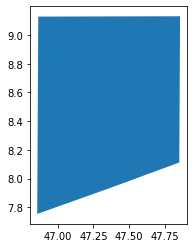

E:\S2_Data_CH22_Original\T32TMT\S2A_MSIL2A_20220213T103131_N0400_R108_T32TMT_20220213T152822.SAFE\INSPIRE.xml


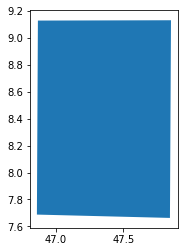

E:\S2_Data_CH22_Original\T32TMT\S2A_MSIL2A_20220220T102051_N0400_R065_T32TMT_20220220T133131.SAFE\INSPIRE.xml


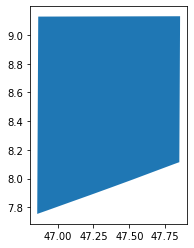

E:\S2_Data_CH22_Original\T32TMT\S2A_MSIL2A_20220223T103031_N0400_R108_T32TMT_20220223T154141.SAFE\INSPIRE.xml


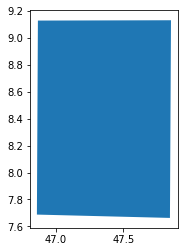

E:\S2_Data_CH22_Original\T32TMT\S2A_MSIL2A_20220305T102921_N0400_R108_T32TMT_20220305T135811.SAFE\INSPIRE.xml


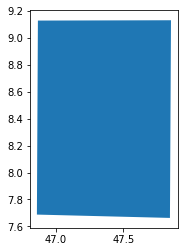

E:\S2_Data_CH22_Original\T32TMT\S2A_MSIL2A_20220322T101711_N0400_R065_T32TMT_20220322T141030.SAFE\INSPIRE.xml


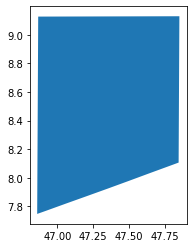

E:\S2_Data_CH22_Original\T32TMT\S2A_MSIL2A_20220325T102651_N0400_R108_T32TMT_20220325T162307.SAFE\INSPIRE.xml


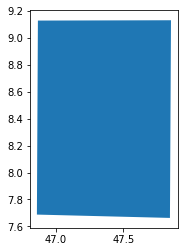

E:\S2_Data_CH22_Original\T32TMT\S2A_MSIL2A_20220404T102601_N0400_R108_T32TMT_20220404T135834.SAFE\INSPIRE.xml


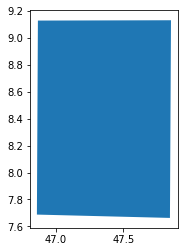

E:\S2_Data_CH22_Original\T32TMT\S2A_MSIL2A_20220411T101601_N0400_R065_T32TMT_20220411T135651.SAFE\INSPIRE.xml


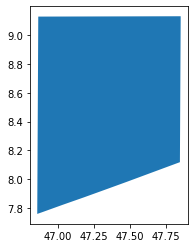

E:\S2_Data_CH22_Original\T32TMT\S2A_MSIL2A_20220414T102601_N0400_R108_T32TMT_20220414T155046.SAFE\INSPIRE.xml


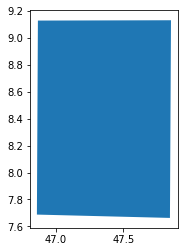

E:\S2_Data_CH22_Original\T32TMT\S2A_MSIL2A_20220421T101601_N0400_R065_T32TMT_20220421T134744.SAFE\INSPIRE.xml


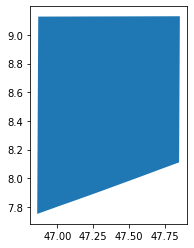

E:\S2_Data_CH22_Original\T32TMT\S2A_MSIL2A_20220501T101601_N0400_R065_T32TMT_20220501T154819.SAFE\INSPIRE.xml


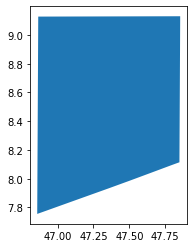

E:\S2_Data_CH22_Original\T32TMT\S2A_MSIL2A_20220504T102601_N0400_R108_T32TMT_20220504T185514.SAFE\INSPIRE.xml


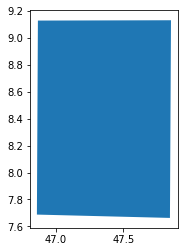

E:\S2_Data_CH22_Original\T32TMT\S2A_MSIL2A_20220511T101601_N0400_R065_T32TMT_20220511T174519.SAFE\INSPIRE.xml


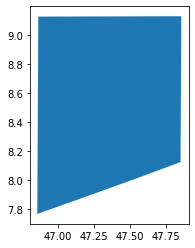

E:\S2_Data_CH22_Original\T32TMT\S2A_MSIL2A_20220514T102601_N0400_R108_T32TMT_20220514T165714.SAFE\INSPIRE.xml


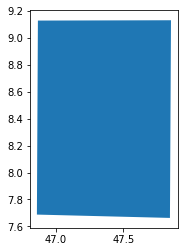

E:\S2_Data_CH22_Original\T32TMT\S2A_MSIL2A_20220521T101601_N0400_R065_T32TMT_20220521T181716.SAFE\INSPIRE.xml


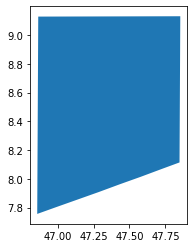

E:\S2_Data_CH22_Original\T32TMT\S2A_MSIL2A_20220521T101601_N9999_R065_T32TMT_20221228T054745.SAFE\INSPIRE.xml


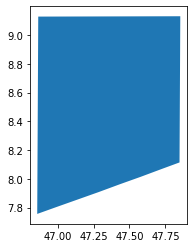

E:\S2_Data_CH22_Original\T32TMT\S2A_MSIL2A_20220531T101611_N0400_R065_T32TMT_20220531T163910.SAFE\INSPIRE.xml


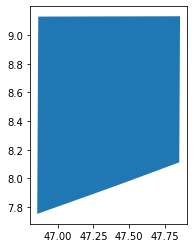

E:\S2_Data_CH22_Original\T32TMT\S2A_MSIL2A_20220603T102611_N0400_R108_T32TMT_20220603T170511.SAFE\INSPIRE.xml


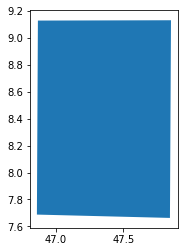

E:\S2_Data_CH22_Original\T32TMT\S2A_MSIL2A_20220610T101611_N0400_R065_T32TMT_20220610T181610.SAFE\INSPIRE.xml


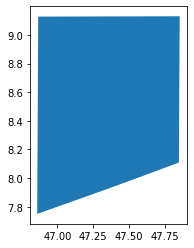

E:\S2_Data_CH22_Original\T32TMT\S2A_MSIL2A_20220613T103031_N0400_R108_T32TMT_20220613T235021.SAFE\INSPIRE.xml


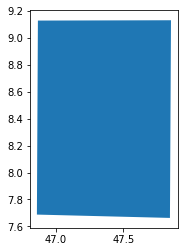

E:\S2_Data_CH22_Original\T32TMT\S2A_MSIL2A_20220620T102041_N0400_R065_T32TMT_20220620T162319.SAFE\INSPIRE.xml


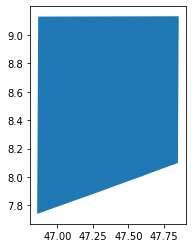

E:\S2_Data_CH22_Original\T32TMT\S2A_MSIL2A_20220620T102041_N9999_R065_T32TMT_20221231T122258.SAFE\INSPIRE.xml


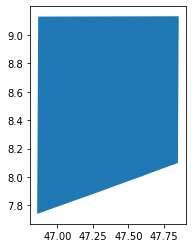

E:\S2_Data_CH22_Original\T32TMT\S2A_MSIL2A_20220623T103031_N0400_R108_T32TMT_20220623T170319.SAFE\INSPIRE.xml


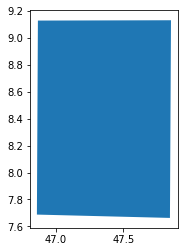

E:\S2_Data_CH22_Original\T32TMT\S2A_MSIL2A_20220623T103031_N9999_R108_T32TMT_20230101T163539.SAFE\INSPIRE.xml


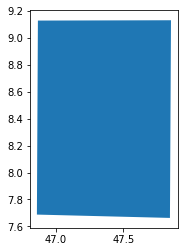

E:\S2_Data_CH22_Original\T32TMT\S2A_MSIL2A_20220630T102041_N0400_R065_T32TMT_20220630T182013.SAFE\INSPIRE.xml


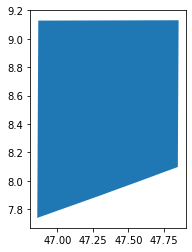

E:\S2_Data_CH22_Original\T32TMT\S2A_MSIL2A_20220703T102611_N0400_R108_T32TMT_20220703T182512.SAFE\INSPIRE.xml


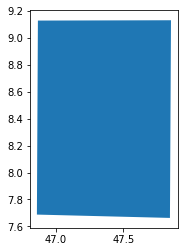

E:\S2_Data_CH22_Original\T32TMT\S2A_MSIL2A_20220710T101611_N0400_R065_T32TMT_20220710T165533.SAFE\INSPIRE.xml


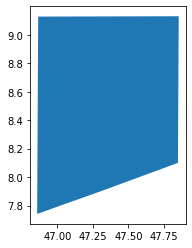

E:\S2_Data_CH22_Original\T32TMT\S2A_MSIL2A_20220713T103041_N0400_R108_T32TMT_20220713T164557.SAFE\INSPIRE.xml


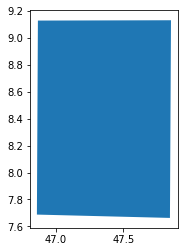

E:\S2_Data_CH22_Original\T32TMT\S2A_MSIL2A_20220720T101611_N0400_R065_T32TMT_20220720T164302.SAFE\INSPIRE.xml


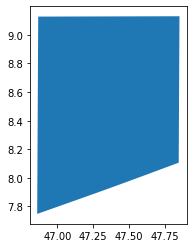

E:\S2_Data_CH22_Original\T32TMT\S2A_MSIL2A_20220730T101611_N0400_R065_T32TMT_20220730T180956.SAFE\INSPIRE.xml


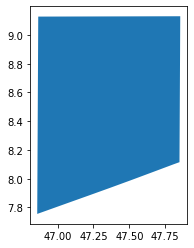

E:\S2_Data_CH22_Original\T32TMT\S2A_MSIL2A_20220802T102611_N0400_R108_T32TMT_20220802T184101.SAFE\INSPIRE.xml


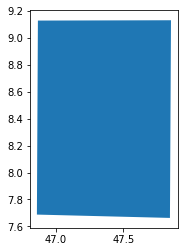

E:\S2_Data_CH22_Original\T32TMT\S2A_MSIL2A_20220809T102041_N0400_R065_T32TMT_20220809T180703.SAFE\INSPIRE.xml


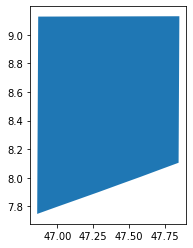

E:\S2_Data_CH22_Original\T32TMT\S2A_MSIL2A_20220812T103031_N0400_R108_T32TMT_20220812T182800.SAFE\INSPIRE.xml


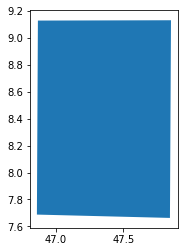

E:\S2_Data_CH22_Original\T32TMT\S2A_MSIL2A_20220822T102611_N0400_R108_T32TMT_20220822T184205.SAFE\INSPIRE.xml


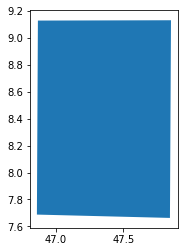

E:\S2_Data_CH22_Original\T32TMT\S2A_MSIL2A_20220829T101611_N0400_R065_T32TMT_20220829T163601.SAFE\INSPIRE.xml


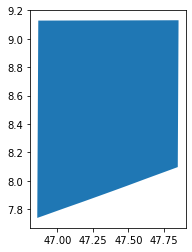

E:\S2_Data_CH22_Original\T32TMT\S2A_MSIL2A_20220901T102611_N0400_R108_T32TMT_20220901T182256.SAFE\INSPIRE.xml


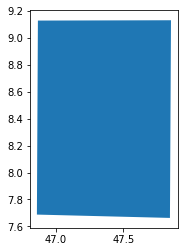

E:\S2_Data_CH22_Original\T32TMT\S2A_MSIL2A_20220908T102031_N0400_R065_T32TMT_20220908T200258.SAFE\INSPIRE.xml


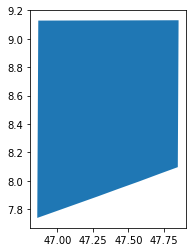

E:\S2_Data_CH22_Original\T32TMT\S2A_MSIL2A_20220911T102621_N0400_R108_T32TMT_20220911T165754.SAFE\INSPIRE.xml


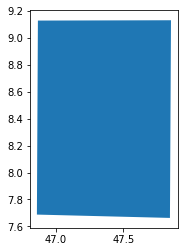

E:\S2_Data_CH22_Original\T32TMT\S2A_MSIL2A_20220918T101701_N0400_R065_T32TMT_20220918T162258.SAFE\INSPIRE.xml


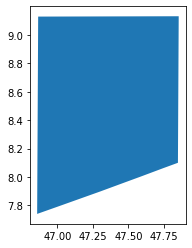

E:\S2_Data_CH22_Original\T32TMT\S2A_MSIL2A_20220921T102731_N0400_R108_T32TMT_20220921T164458.SAFE\INSPIRE.xml


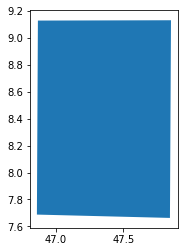

E:\S2_Data_CH22_Original\T32TMT\S2A_MSIL2A_20221011T102951_N0400_R108_T32TMT_20221011T163653.SAFE\INSPIRE.xml


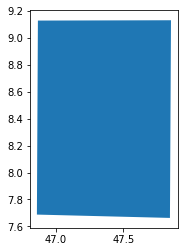

E:\S2_Data_CH22_Original\T32TMT\S2A_MSIL2A_20221018T102031_N0400_R065_T32TMT_20221018T140656.SAFE\INSPIRE.xml


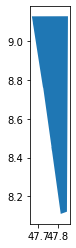

E:\S2_Data_CH22_Original\T32TMT\S2A_MSIL2A_20221018T102031_N0400_R065_T32TMT_20221018T162355.SAFE\INSPIRE.xml


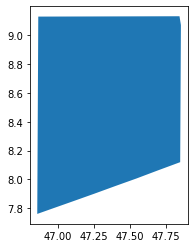

E:\S2_Data_CH22_Original\T32TMT\S2A_MSIL2A_20221028T102131_N0400_R065_T32TMT_20221028T140955.SAFE\INSPIRE.xml


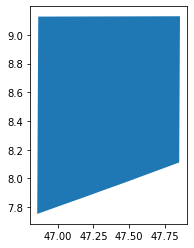

E:\S2_Data_CH22_Original\T32TMT\S2A_MSIL2A_20221110T103251_N0400_R108_T32TMT_20221110T163904.SAFE\INSPIRE.xml


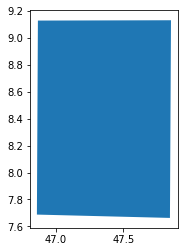

E:\S2_Data_CH22_Original\T32TMT\S2A_MSIL2A_20221120T103331_N0400_R108_T32TMT_20221120T164159.SAFE\INSPIRE.xml


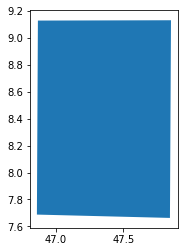

E:\S2_Data_CH22_Original\T32TMT\S2A_MSIL2A_20221127T102351_N0400_R065_T32TMT_20221127T140108.SAFE\INSPIRE.xml


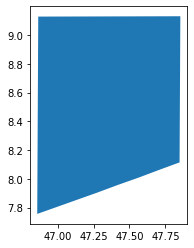

E:\S2_Data_CH22_Original\T32TMT\S2A_MSIL2A_20221207T102411_N0509_R065_T32TMT_20221207T135807.SAFE\INSPIRE.xml


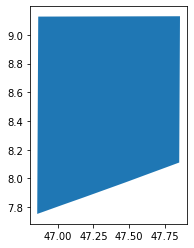

E:\S2_Data_CH22_Original\T32TMT\S2A_MSIL2A_20221217T102431_N0509_R065_T32TMT_20221217T141955.SAFE\INSPIRE.xml


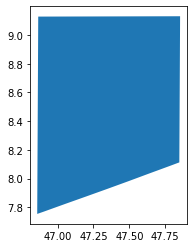

E:\S2_Data_CH22_Original\T32TMT\S2B_MSIL2A_20220106T102319_N0301_R065_T32TMT_20220106T123401.SAFE\INSPIRE.xml


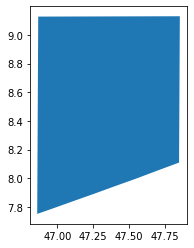

E:\S2_Data_CH22_Original\T32TMT\S2B_MSIL2A_20220109T103319_N0301_R108_T32TMT_20220109T121931.SAFE\INSPIRE.xml


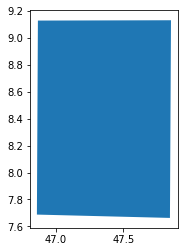

E:\S2_Data_CH22_Original\T32TMT\S2B_MSIL2A_20220116T102249_N0301_R065_T32TMT_20220116T123439.SAFE\INSPIRE.xml


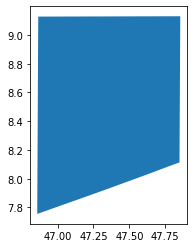

E:\S2_Data_CH22_Original\T32TMT\S2B_MSIL2A_20220119T103249_N0301_R108_T32TMT_20220119T121956.SAFE\INSPIRE.xml


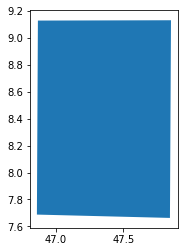

E:\S2_Data_CH22_Original\T32TMT\S2B_MSIL2A_20220126T102209_N0400_R065_T32TMT_20220126T121533.SAFE\INSPIRE.xml


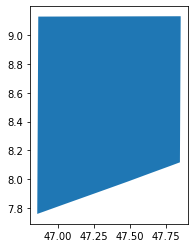

E:\S2_Data_CH22_Original\T32TMT\S2B_MSIL2A_20220129T103159_N0400_R108_T32TMT_20220129T120945.SAFE\INSPIRE.xml


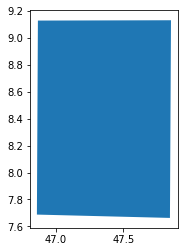

E:\S2_Data_CH22_Original\T32TMT\S2B_MSIL2A_20220205T102119_N0400_R065_T32TMT_20220205T121510.SAFE\INSPIRE.xml


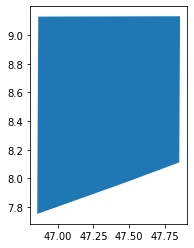

E:\S2_Data_CH22_Original\T32TMT\S2B_MSIL2A_20220208T103109_N0400_R108_T32TMT_20220208T143549.SAFE\INSPIRE.xml


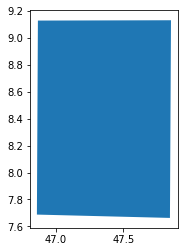

E:\S2_Data_CH22_Original\T32TMT\S2B_MSIL2A_20220225T101909_N0400_R065_T32TMT_20220225T132831.SAFE\INSPIRE.xml


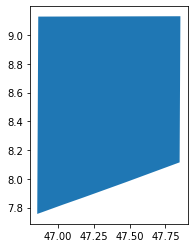

E:\S2_Data_CH22_Original\T32TMT\S2B_MSIL2A_20220228T102849_N0400_R108_T32TMT_20220228T134712.SAFE\INSPIRE.xml


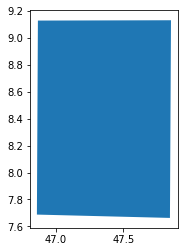

E:\S2_Data_CH22_Original\T32TMT\S2B_MSIL2A_20220307T101759_N0400_R065_T32TMT_20220307T133430.SAFE\INSPIRE.xml


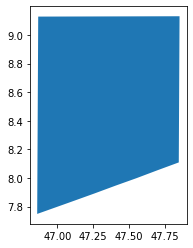

E:\S2_Data_CH22_Original\T32TMT\S2B_MSIL2A_20220310T102739_N0400_R108_T32TMT_20220310T134645.SAFE\INSPIRE.xml


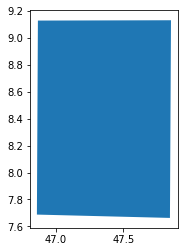

E:\S2_Data_CH22_Original\T32TMT\S2B_MSIL2A_20220320T102639_N0400_R108_T32TMT_20220320T135549.SAFE\INSPIRE.xml


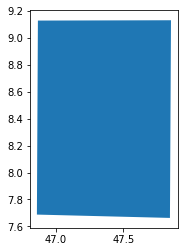

E:\S2_Data_CH22_Original\T32TMT\S2B_MSIL2A_20220327T101629_N0400_R065_T32TMT_20220327T141610.SAFE\INSPIRE.xml


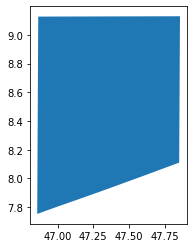

E:\S2_Data_CH22_Original\T32TMT\S2B_MSIL2A_20220406T101559_N0400_R065_T32TMT_20220406T154623.SAFE\INSPIRE.xml


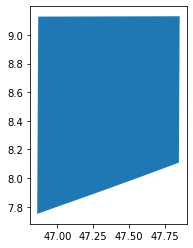

E:\S2_Data_CH22_Original\T32TMT\S2B_MSIL2A_20220409T102559_N0400_R108_T32TMT_20220409T135935.SAFE\INSPIRE.xml


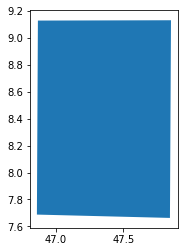

E:\S2_Data_CH22_Original\T32TMT\S2B_MSIL2A_20220416T101559_N0400_R065_T32TMT_20220416T175100.SAFE\INSPIRE.xml


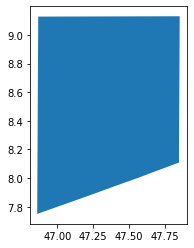

E:\S2_Data_CH22_Original\T32TMT\S2B_MSIL2A_20220419T102559_N0400_R108_T32TMT_20220419T140845.SAFE\INSPIRE.xml


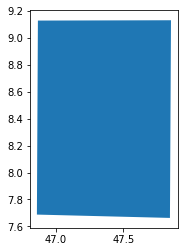

E:\S2_Data_CH22_Original\T32TMT\S2B_MSIL2A_20220429T102549_N0400_R108_T32TMT_20220429T141359.SAFE\INSPIRE.xml


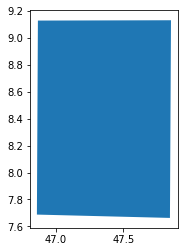

E:\S2_Data_CH22_Original\T32TMT\S2B_MSIL2A_20220509T102559_N0400_R108_T32TMT_20220509T152416.SAFE\INSPIRE.xml


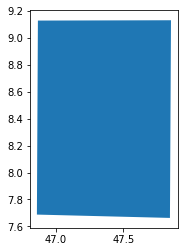

E:\S2_Data_CH22_Original\T32TMT\S2B_MSIL2A_20220516T101559_N0400_R065_T32TMT_20220516T133430.SAFE\INSPIRE.xml


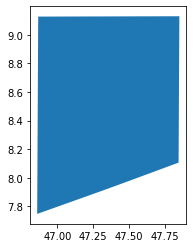

E:\S2_Data_CH22_Original\T32TMT\S2B_MSIL2A_20220516T101559_N0400_R065_T32TMT_20220722T190205.SAFE\INSPIRE.xml


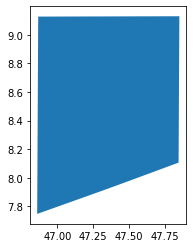

E:\S2_Data_CH22_Original\T32TMT\S2B_MSIL2A_20220519T102559_N0400_R108_T32TMT_20220519T165606.SAFE\INSPIRE.xml


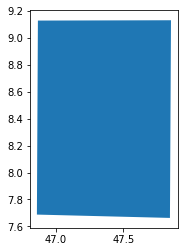

E:\S2_Data_CH22_Original\T32TMT\S2B_MSIL2A_20220519T102559_N0400_R108_T32TMT_20220720T150500.SAFE\INSPIRE.xml


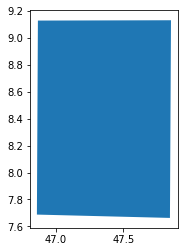

E:\S2_Data_CH22_Original\T32TMT\S2B_MSIL2A_20220526T101559_N0400_R065_T32TMT_20220526T134056.SAFE\INSPIRE.xml


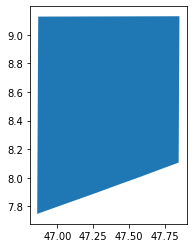

E:\S2_Data_CH22_Original\T32TMT\S2B_MSIL2A_20220529T102559_N0400_R108_T32TMT_20220529T134240.SAFE\INSPIRE.xml


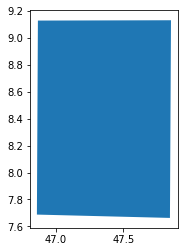

E:\S2_Data_CH22_Original\T32TMT\S2B_MSIL2A_20220608T102559_N0400_R108_T32TMT_20220608T135950.SAFE\INSPIRE.xml


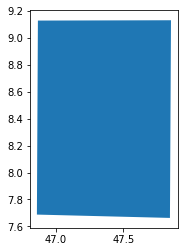

E:\S2_Data_CH22_Original\T32TMT\S2B_MSIL2A_20220615T101559_N0400_R065_T32TMT_20220615T132635.SAFE\INSPIRE.xml


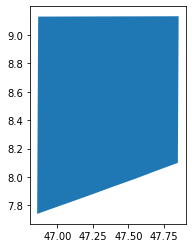

E:\S2_Data_CH22_Original\T32TMT\S2B_MSIL2A_20220618T102559_N0400_R108_T32TMT_20220618T135630.SAFE\INSPIRE.xml


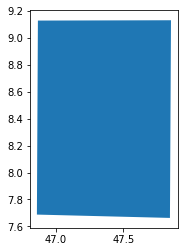

E:\S2_Data_CH22_Original\T32TMT\S2B_MSIL2A_20220625T101559_N0400_R065_T32TMT_20220625T131754.SAFE\INSPIRE.xml


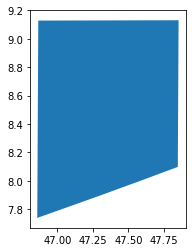

E:\S2_Data_CH22_Original\T32TMT\S2B_MSIL2A_20220705T101559_N0400_R065_T32TMT_20220705T131726.SAFE\INSPIRE.xml


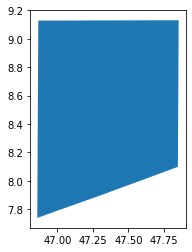

E:\S2_Data_CH22_Original\T32TMT\S2B_MSIL2A_20220708T102559_N0400_R108_T32TMT_20220708T131740.SAFE\INSPIRE.xml


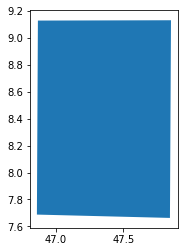

E:\S2_Data_CH22_Original\T32TMT\S2B_MSIL2A_20220715T101559_N0400_R065_T32TMT_20220715T133111.SAFE\INSPIRE.xml


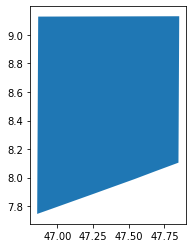

E:\S2_Data_CH22_Original\T32TMT\S2B_MSIL2A_20220718T102559_N0400_R108_T32TMT_20220718T133811.SAFE\INSPIRE.xml


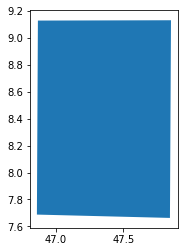

E:\S2_Data_CH22_Original\T32TMT\S2B_MSIL2A_20220725T101559_N0400_R065_T32TMT_20220725T132135.SAFE\INSPIRE.xml


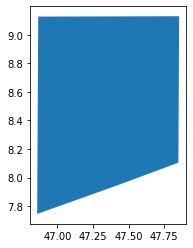

E:\S2_Data_CH22_Original\T32TMT\S2B_MSIL2A_20220728T102559_N0400_R108_T32TMT_20220728T145738.SAFE\INSPIRE.xml


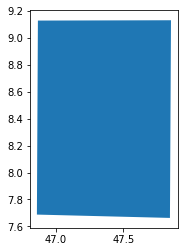

E:\S2_Data_CH22_Original\T32TMT\S2B_MSIL2A_20220804T101559_N0400_R065_T32TMT_20220804T130854.SAFE\INSPIRE.xml


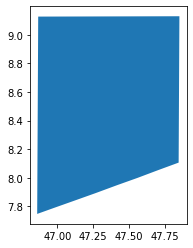

E:\S2_Data_CH22_Original\T32TMT\S2B_MSIL2A_20220807T102559_N0400_R108_T32TMT_20220807T132122.SAFE\INSPIRE.xml


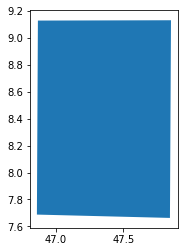

E:\S2_Data_CH22_Original\T32TMT\S2B_MSIL2A_20220814T101559_N0400_R065_T32TMT_20220814T130923.SAFE\INSPIRE.xml


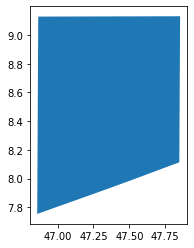

E:\S2_Data_CH22_Original\T32TMT\S2B_MSIL2A_20220817T102559_N0400_R108_T32TMT_20220817T132522.SAFE\INSPIRE.xml


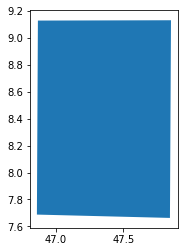

E:\S2_Data_CH22_Original\T32TMT\S2B_MSIL2A_20220824T101559_N0400_R065_T32TMT_20220824T131202.SAFE\INSPIRE.xml


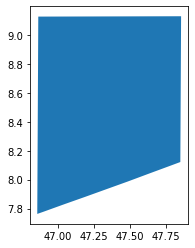

E:\S2_Data_CH22_Original\T32TMT\S2B_MSIL2A_20220827T102559_N0400_R108_T32TMT_20220827T132155.SAFE\INSPIRE.xml


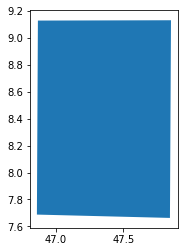

E:\S2_Data_CH22_Original\T32TMT\S2B_MSIL2A_20220906T102559_N0400_R108_T32TMT_20220906T131726.SAFE\INSPIRE.xml


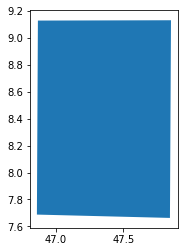

E:\S2_Data_CH22_Original\T32TMT\S2B_MSIL2A_20220913T101629_N0400_R065_T32TMT_20220913T144542.SAFE\INSPIRE.xml


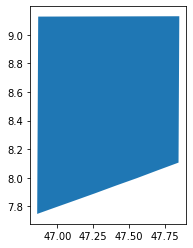

E:\S2_Data_CH22_Original\T32TMT\S2B_MSIL2A_20220923T101649_N0400_R065_T32TMT_20220923T144734.SAFE\INSPIRE.xml


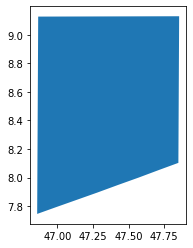

E:\S2_Data_CH22_Original\T32TMT\S2B_MSIL2A_20220926T102709_N0400_R108_T32TMT_20220926T134524.SAFE\INSPIRE.xml


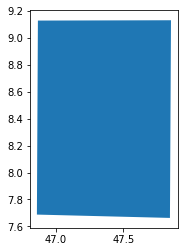

E:\S2_Data_CH22_Original\T32TMT\S2B_MSIL2A_20221003T101749_N0400_R065_T32TMT_20221003T162756.SAFE\INSPIRE.xml


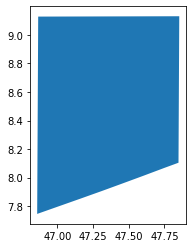

E:\S2_Data_CH22_Original\T32TMT\S2B_MSIL2A_20221006T102949_N0400_R108_T32TMT_20221006T181350.SAFE\INSPIRE.xml


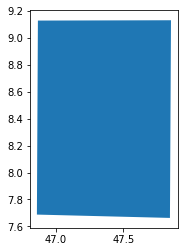

E:\S2_Data_CH22_Original\T32TMT\S2B_MSIL2A_20221016T102919_N0400_R108_T32TMT_20221016T131725.SAFE\INSPIRE.xml


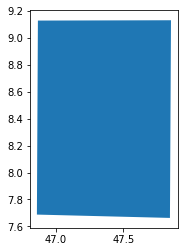

E:\S2_Data_CH22_Original\T32TMT\S2B_MSIL2A_20221026T103029_N0400_R108_T32TMT_20221026T132935.SAFE\INSPIRE.xml


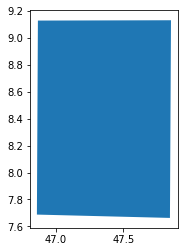

E:\S2_Data_CH22_Original\T32TMT\S2B_MSIL2A_20221125T103259_N0400_R108_T32TMT_20221125T113610.SAFE\INSPIRE.xml


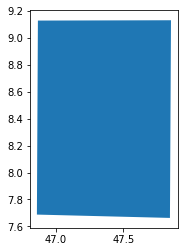

E:\S2_Data_CH22_Original\T32TMT\S2B_MSIL2A_20221222T102339_N0509_R065_T32TMT_20221222T113435.SAFE\INSPIRE.xml


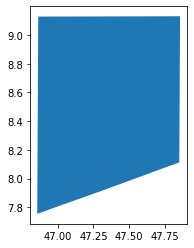

E:\S2_Data_CH22_Original\T32TMS\S2A_MSIL2A_20220101T102431_N0301_R065_T32TMS_20220101T133200.SAFE\INSPIRE.xml


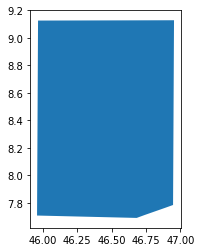

E:\S2_Data_CH22_Original\T32TMS\S2A_MSIL2A_20220104T103431_N0301_R108_T32TMS_20220104T133107.SAFE\INSPIRE.xml


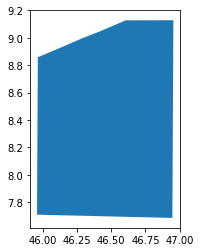

E:\S2_Data_CH22_Original\T32TMS\S2A_MSIL2A_20220111T102411_N0301_R065_T32TMS_20220111T131516.SAFE\INSPIRE.xml


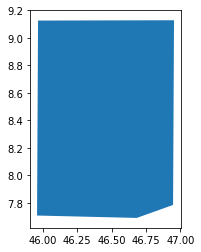

E:\S2_Data_CH22_Original\T32TMS\S2A_MSIL2A_20220114T103401_N0301_R108_T32TMS_20220114T132749.SAFE\INSPIRE.xml


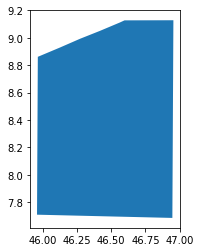

E:\S2_Data_CH22_Original\T32TMS\S2A_MSIL2A_20220121T102331_N0301_R065_T32TMS_20220121T131536.SAFE\INSPIRE.xml


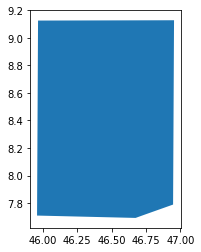

E:\S2_Data_CH22_Original\T32TMS\S2A_MSIL2A_20220124T103331_N0301_R108_T32TMS_20220124T163734.SAFE\INSPIRE.xml


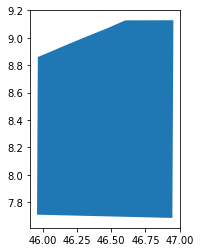

E:\S2_Data_CH22_Original\T32TMS\S2A_MSIL2A_20220131T102251_N0400_R065_T32TMS_20220131T133159.SAFE\INSPIRE.xml


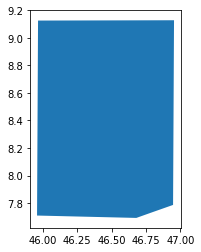

E:\S2_Data_CH22_Original\T32TMS\S2A_MSIL2A_20220203T103231_N0400_R108_T32TMS_20220203T153332.SAFE\INSPIRE.xml


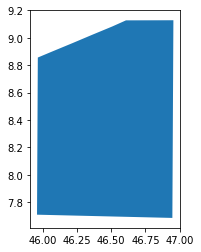

E:\S2_Data_CH22_Original\T32TMS\S2A_MSIL2A_20220210T102151_N0400_R065_T32TMS_20220210T153400.SAFE\INSPIRE.xml


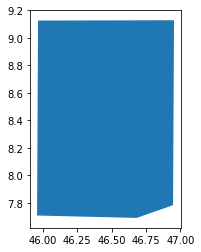

E:\S2_Data_CH22_Original\T32TMS\S2A_MSIL2A_20220213T103131_N0400_R108_T32TMS_20220213T152822.SAFE\INSPIRE.xml


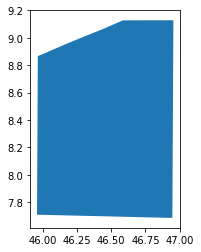

E:\S2_Data_CH22_Original\T32TMS\S2A_MSIL2A_20220220T102051_N0400_R065_T32TMS_20220220T133131.SAFE\INSPIRE.xml


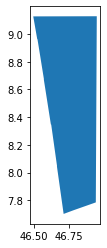

E:\S2_Data_CH22_Original\T32TMS\S2A_MSIL2A_20220220T102051_N0400_R065_T32TMS_20220220T152532.SAFE\INSPIRE.xml


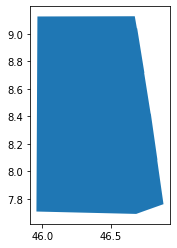

E:\S2_Data_CH22_Original\T32TMS\S2A_MSIL2A_20220223T103031_N0400_R108_T32TMS_20220223T154141.SAFE\INSPIRE.xml


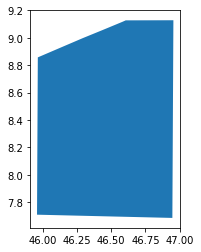

E:\S2_Data_CH22_Original\T32TMS\S2A_MSIL2A_20220302T101941_N0400_R065_T32TMS_20220302T135825.SAFE\INSPIRE.xml


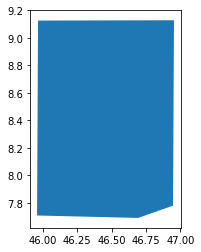

E:\S2_Data_CH22_Original\T32TMS\S2A_MSIL2A_20220305T102921_N0400_R108_T32TMS_20220305T135811.SAFE\INSPIRE.xml


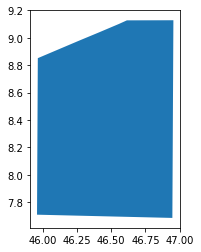

E:\S2_Data_CH22_Original\T32TMS\S2A_MSIL2A_20220312T101831_N0400_R065_T32TMS_20220312T134516.SAFE\INSPIRE.xml


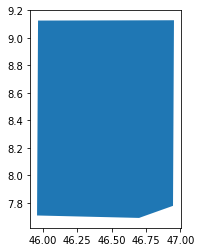

E:\S2_Data_CH22_Original\T32TMS\S2A_MSIL2A_20220322T101711_N0400_R065_T32TMS_20220322T141030.SAFE\INSPIRE.xml


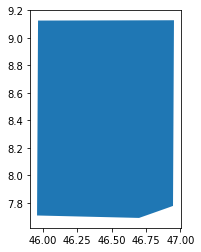

E:\S2_Data_CH22_Original\T32TMS\S2A_MSIL2A_20220325T102651_N0400_R108_T32TMS_20220325T162307.SAFE\INSPIRE.xml


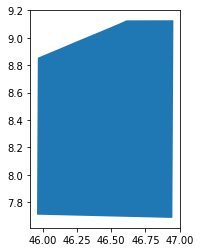

E:\S2_Data_CH22_Original\T32TMS\S2A_MSIL2A_20220404T102601_N0400_R108_T32TMS_20220404T135834.SAFE\INSPIRE.xml


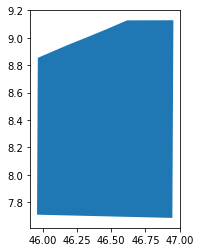

E:\S2_Data_CH22_Original\T32TMS\S2A_MSIL2A_20220411T101601_N0400_R065_T32TMS_20220411T135651.SAFE\INSPIRE.xml


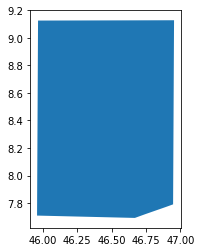

E:\S2_Data_CH22_Original\T32TMS\S2A_MSIL2A_20220414T102601_N0400_R108_T32TMS_20220414T155046.SAFE\INSPIRE.xml


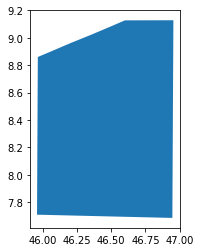

E:\S2_Data_CH22_Original\T32TMS\S2A_MSIL2A_20220421T101601_N0400_R065_T32TMS_20220421T134744.SAFE\INSPIRE.xml


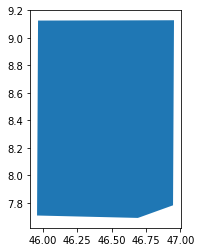

E:\S2_Data_CH22_Original\T32TMS\S2A_MSIL2A_20220501T101601_N0400_R065_T32TMS_20220501T154819.SAFE\INSPIRE.xml


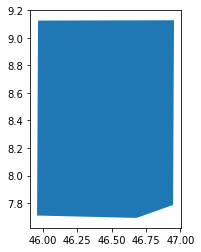

E:\S2_Data_CH22_Original\T32TMS\S2A_MSIL2A_20220504T102601_N0400_R108_T32TMS_20220504T185514.SAFE\INSPIRE.xml


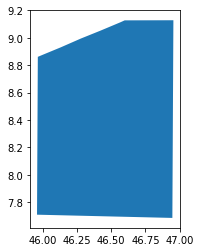

E:\S2_Data_CH22_Original\T32TMS\S2A_MSIL2A_20220511T101601_N0400_R065_T32TMS_20220511T174519.SAFE\INSPIRE.xml


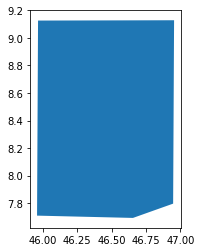

E:\S2_Data_CH22_Original\T32TMS\S2A_MSIL2A_20220514T102601_N0400_R108_T32TMS_20220514T165714.SAFE\INSPIRE.xml


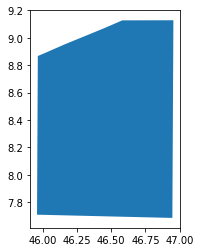

E:\S2_Data_CH22_Original\T32TMS\S2A_MSIL2A_20220521T101601_N0400_R065_T32TMS_20220521T181716.SAFE\INSPIRE.xml


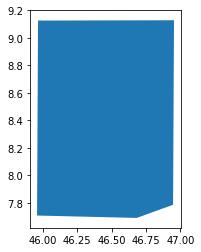

E:\S2_Data_CH22_Original\T32TMS\S2A_MSIL2A_20220521T101601_N9999_R065_T32TMS_20230103T160615.SAFE\INSPIRE.xml


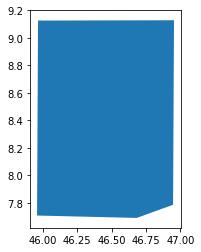

E:\S2_Data_CH22_Original\T32TMS\S2A_MSIL2A_20220610T101611_N0400_R065_T32TMS_20220610T181610.SAFE\INSPIRE.xml


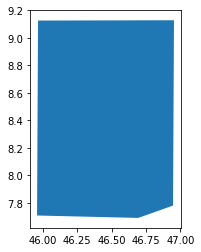

E:\S2_Data_CH22_Original\T32TMS\S2A_MSIL2A_20220613T103031_N0400_R108_T32TMS_20220613T235021.SAFE\INSPIRE.xml


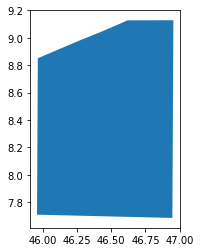

E:\S2_Data_CH22_Original\T32TMS\S2A_MSIL2A_20220620T102041_N0400_R065_T32TMS_20220620T162319.SAFE\INSPIRE.xml


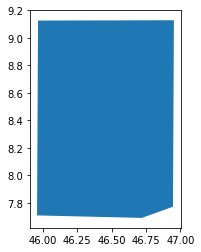

E:\S2_Data_CH22_Original\T32TMS\S2A_MSIL2A_20220620T102041_N9999_R065_T32TMS_20221231T181205.SAFE\INSPIRE.xml


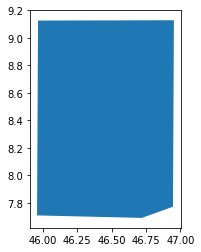

E:\S2_Data_CH22_Original\T32TMS\S2A_MSIL2A_20220623T103031_N0400_R108_T32TMS_20220623T170319.SAFE\INSPIRE.xml


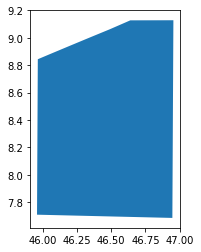

E:\S2_Data_CH22_Original\T32TMS\S2A_MSIL2A_20220630T102041_N0400_R065_T32TMS_20220630T182013.SAFE\INSPIRE.xml


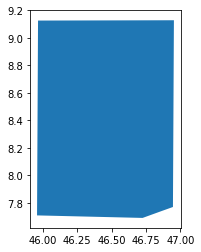

E:\S2_Data_CH22_Original\T32TMS\S2A_MSIL2A_20220703T102611_N0400_R108_T32TMS_20220703T182512.SAFE\INSPIRE.xml


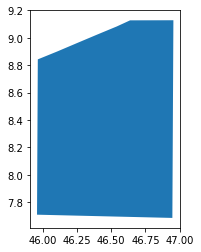

E:\S2_Data_CH22_Original\T32TMS\S2A_MSIL2A_20220710T101611_N0400_R065_T32TMS_20220710T165533.SAFE\INSPIRE.xml


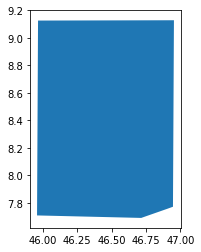

E:\S2_Data_CH22_Original\T32TMS\S2A_MSIL2A_20220713T103041_N0400_R108_T32TMS_20220713T164557.SAFE\INSPIRE.xml


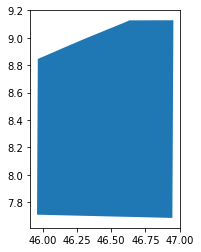

E:\S2_Data_CH22_Original\T32TMS\S2A_MSIL2A_20220720T101611_N0400_R065_T32TMS_20220720T164302.SAFE\INSPIRE.xml


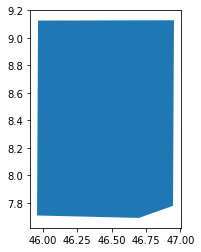

E:\S2_Data_CH22_Original\T32TMS\S2A_MSIL2A_20220723T102611_N0400_R108_T32TMS_20220723T164456.SAFE\INSPIRE.xml


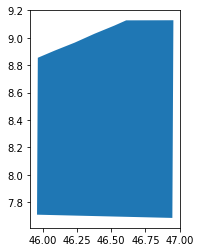

E:\S2_Data_CH22_Original\T32TMS\S2A_MSIL2A_20220730T101611_N0400_R065_T32TMS_20220730T180956.SAFE\INSPIRE.xml


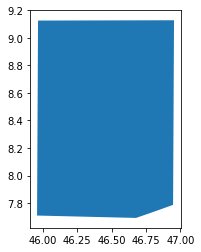

E:\S2_Data_CH22_Original\T32TMS\S2A_MSIL2A_20220802T102611_N0400_R108_T32TMS_20220802T184101.SAFE\INSPIRE.xml


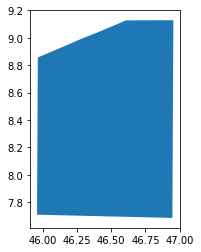

E:\S2_Data_CH22_Original\T32TMS\S2A_MSIL2A_20220809T102041_N0400_R065_T32TMS_20220809T180703.SAFE\INSPIRE.xml


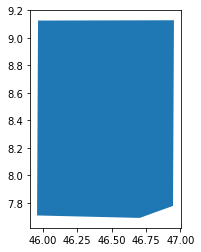

E:\S2_Data_CH22_Original\T32TMS\S2A_MSIL2A_20220812T103031_N0400_R108_T32TMS_20220812T182800.SAFE\INSPIRE.xml


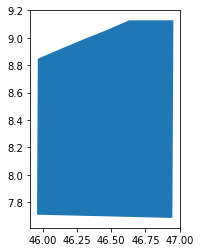

E:\S2_Data_CH22_Original\T32TMS\S2A_MSIL2A_20220822T102611_N0400_R108_T32TMS_20220822T184205.SAFE\INSPIRE.xml


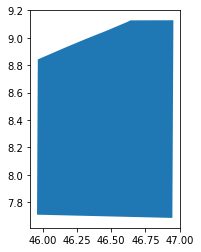

E:\S2_Data_CH22_Original\T32TMS\S2A_MSIL2A_20220829T101611_N0400_R065_T32TMS_20220829T163601.SAFE\INSPIRE.xml


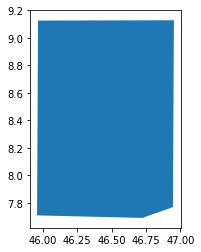

E:\S2_Data_CH22_Original\T32TMS\S2A_MSIL2A_20220901T102611_N0400_R108_T32TMS_20220901T182256.SAFE\INSPIRE.xml


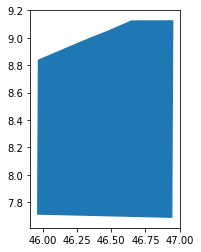

E:\S2_Data_CH22_Original\T32TMS\S2A_MSIL2A_20220908T102031_N0400_R065_T32TMS_20220908T200258.SAFE\INSPIRE.xml


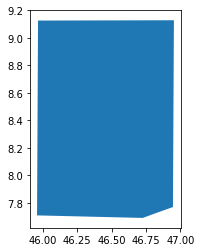

E:\S2_Data_CH22_Original\T32TMS\S2A_MSIL2A_20220911T102621_N0400_R108_T32TMS_20220911T165754.SAFE\INSPIRE.xml


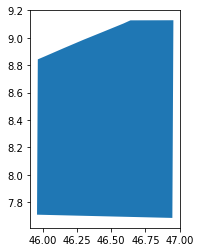

E:\S2_Data_CH22_Original\T32TMS\S2A_MSIL2A_20220918T101701_N0400_R065_T32TMS_20220918T162258.SAFE\INSPIRE.xml


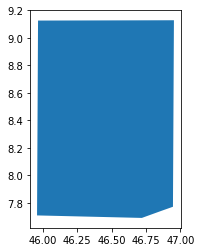

E:\S2_Data_CH22_Original\T32TMS\S2A_MSIL2A_20220921T102731_N0400_R108_T32TMS_20220921T164458.SAFE\INSPIRE.xml


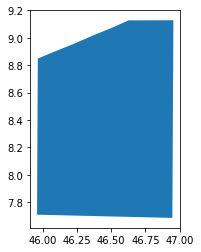

E:\S2_Data_CH22_Original\T32TMS\S2A_MSIL2A_20221008T101931_N0400_R065_T32TMS_20221008T163005.SAFE\INSPIRE.xml


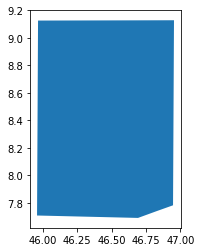

E:\S2_Data_CH22_Original\T32TMS\S2A_MSIL2A_20221011T102951_N0400_R108_T32TMS_20221011T163653.SAFE\INSPIRE.xml


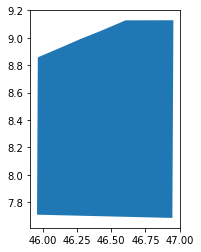

E:\S2_Data_CH22_Original\T32TMS\S2A_MSIL2A_20221018T102031_N0400_R065_T32TMS_20221018T162355.SAFE\INSPIRE.xml


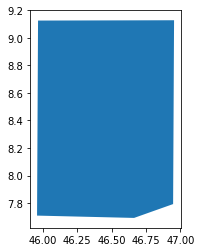

E:\S2_Data_CH22_Original\T32TMS\S2A_MSIL2A_20221028T102131_N0400_R065_T32TMS_20221028T140955.SAFE\INSPIRE.xml


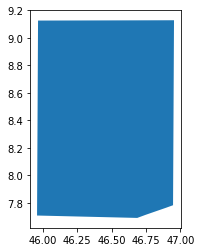

E:\S2_Data_CH22_Original\T32TMS\S2A_MSIL2A_20221031T103151_N0400_R108_T32TMS_20221031T164300.SAFE\INSPIRE.xml


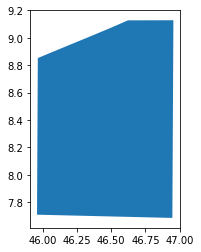

E:\S2_Data_CH22_Original\T32TMS\S2A_MSIL2A_20221110T103251_N0400_R108_T32TMS_20221110T163904.SAFE\INSPIRE.xml


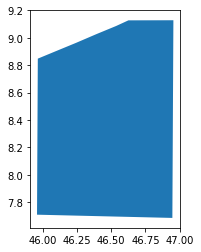

E:\S2_Data_CH22_Original\T32TMS\S2A_MSIL2A_20221117T102311_N0400_R065_T32TMS_20221117T163558.SAFE\INSPIRE.xml


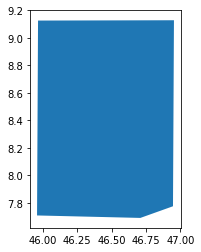

E:\S2_Data_CH22_Original\T32TMS\S2A_MSIL2A_20221120T103331_N0400_R108_T32TMS_20221120T164159.SAFE\INSPIRE.xml


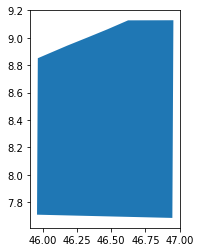

E:\S2_Data_CH22_Original\T32TMS\S2A_MSIL2A_20221127T102351_N0400_R065_T32TMS_20221127T140108.SAFE\INSPIRE.xml


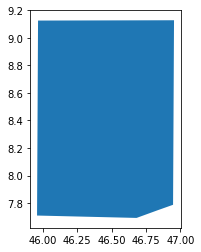

E:\S2_Data_CH22_Original\T32TMS\S2A_MSIL2A_20221130T103411_N0400_R108_T32TMS_20221130T134554.SAFE\INSPIRE.xml


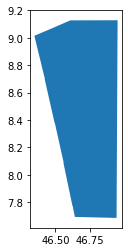

E:\S2_Data_CH22_Original\T32TMS\S2A_MSIL2A_20221130T103411_N0400_R108_T32TMS_20221130T163008.SAFE\INSPIRE.xml


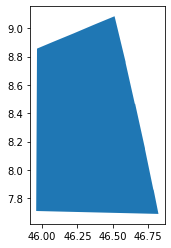

E:\S2_Data_CH22_Original\T32TMS\S2A_MSIL2A_20221207T102411_N0509_R065_T32TMS_20221207T135807.SAFE\INSPIRE.xml


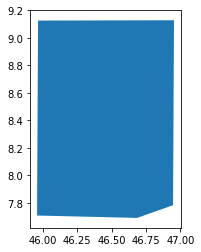

E:\S2_Data_CH22_Original\T32TMS\S2A_MSIL2A_20221210T103431_N0509_R108_T32TMS_20221210T142357.SAFE\INSPIRE.xml


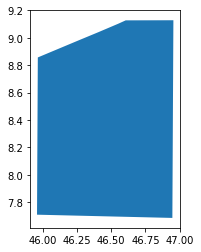

E:\S2_Data_CH22_Original\T32TMS\S2A_MSIL2A_20221217T102431_N0509_R065_T32TMS_20221217T141955.SAFE\INSPIRE.xml


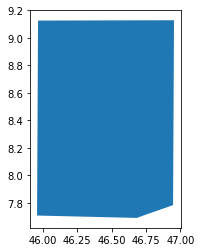

E:\S2_Data_CH22_Original\T32TMS\S2A_MSIL2A_20221220T103441_N0509_R108_T32TMS_20221220T134756.SAFE\INSPIRE.xml


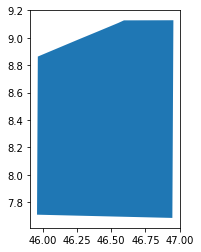

E:\S2_Data_CH22_Original\T32TMS\S2A_MSIL2A_20221227T102431_N0509_R065_T32TMS_20221227T140052.SAFE\INSPIRE.xml


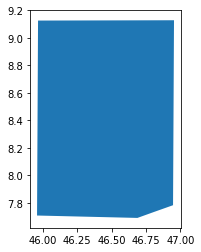

E:\S2_Data_CH22_Original\T32TMS\S2A_MSIL2A_20221230T103431_N0509_R108_T32TMS_20221230T134707.SAFE\INSPIRE.xml


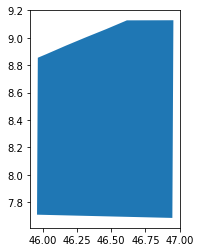

E:\S2_Data_CH22_Original\T32TMS\S2B_MSIL2A_20220106T102319_N0301_R065_T32TMS_20220106T123401.SAFE\INSPIRE.xml


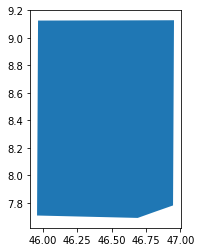

E:\S2_Data_CH22_Original\T32TMS\S2B_MSIL2A_20220109T103319_N0301_R108_T32TMS_20220109T121931.SAFE\INSPIRE.xml


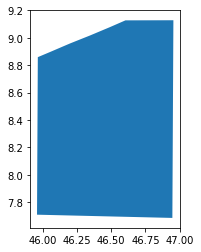

E:\S2_Data_CH22_Original\T32TMS\S2B_MSIL2A_20220116T102249_N0301_R065_T32TMS_20220116T123439.SAFE\INSPIRE.xml


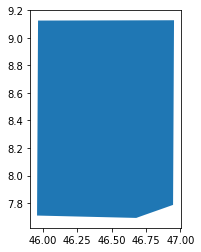

E:\S2_Data_CH22_Original\T32TMS\S2B_MSIL2A_20220119T103249_N0301_R108_T32TMS_20220119T121956.SAFE\INSPIRE.xml


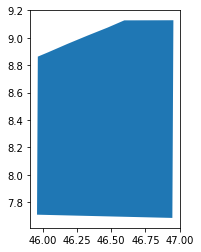

E:\S2_Data_CH22_Original\T32TMS\S2B_MSIL2A_20220126T102209_N0400_R065_T32TMS_20220126T121533.SAFE\INSPIRE.xml


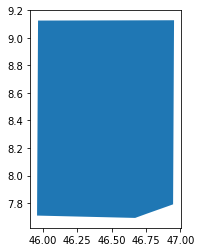

E:\S2_Data_CH22_Original\T32TMS\S2B_MSIL2A_20220129T103159_N0400_R108_T32TMS_20220129T120945.SAFE\INSPIRE.xml


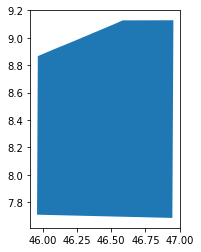

E:\S2_Data_CH22_Original\T32TMS\S2B_MSIL2A_20220205T102119_N0400_R065_T32TMS_20220205T121510.SAFE\INSPIRE.xml


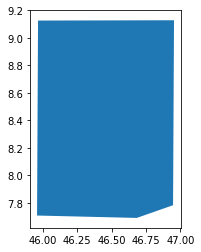

E:\S2_Data_CH22_Original\T32TMS\S2B_MSIL2A_20220208T103109_N0400_R108_T32TMS_20220208T143549.SAFE\INSPIRE.xml


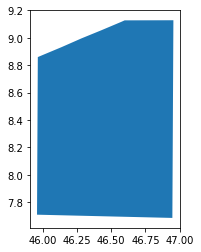

E:\S2_Data_CH22_Original\T32TMS\S2B_MSIL2A_20220218T102949_N0400_R108_T32TMS_20220218T143251.SAFE\INSPIRE.xml


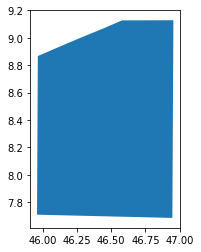

E:\S2_Data_CH22_Original\T32TMS\S2B_MSIL2A_20220225T101909_N0400_R065_T32TMS_20220225T132831.SAFE\INSPIRE.xml


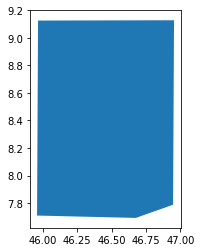

E:\S2_Data_CH22_Original\T32TMS\S2B_MSIL2A_20220228T102849_N0400_R108_T32TMS_20220228T134712.SAFE\INSPIRE.xml


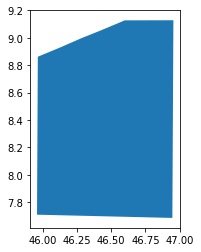

E:\S2_Data_CH22_Original\T32TMS\S2B_MSIL2A_20220307T101759_N0400_R065_T32TMS_20220307T133430.SAFE\INSPIRE.xml


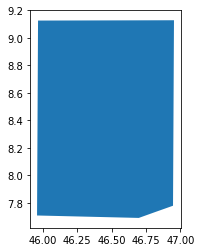

E:\S2_Data_CH22_Original\T32TMS\S2B_MSIL2A_20220310T102739_N0400_R108_T32TMS_20220310T134645.SAFE\INSPIRE.xml


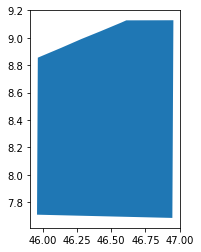

E:\S2_Data_CH22_Original\T32TMS\S2B_MSIL2A_20220317T101649_N0400_R065_T32TMS_20220317T135341.SAFE\INSPIRE.xml


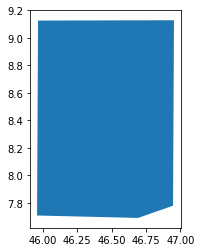

E:\S2_Data_CH22_Original\T32TMS\S2B_MSIL2A_20220320T102639_N0400_R108_T32TMS_20220320T135549.SAFE\INSPIRE.xml


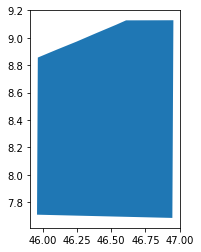

E:\S2_Data_CH22_Original\T32TMS\S2B_MSIL2A_20220327T101629_N0400_R065_T32TMS_20220327T141610.SAFE\INSPIRE.xml


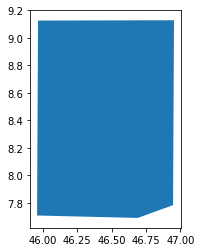

E:\S2_Data_CH22_Original\T32TMS\S2B_MSIL2A_20220406T101559_N0400_R065_T32TMS_20220406T154623.SAFE\INSPIRE.xml


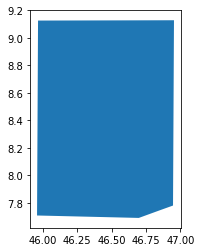

E:\S2_Data_CH22_Original\T32TMS\S2B_MSIL2A_20220409T102559_N0400_R108_T32TMS_20220409T135935.SAFE\INSPIRE.xml


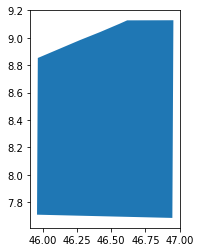

E:\S2_Data_CH22_Original\T32TMS\S2B_MSIL2A_20220416T101559_N0400_R065_T32TMS_20220416T175100.SAFE\INSPIRE.xml


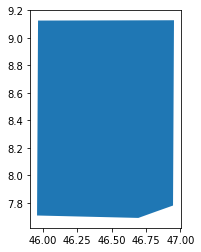

E:\S2_Data_CH22_Original\T32TMS\S2B_MSIL2A_20220419T102559_N0400_R108_T32TMS_20220419T140845.SAFE\INSPIRE.xml


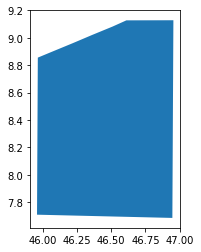

E:\S2_Data_CH22_Original\T32TMS\S2B_MSIL2A_20220429T102549_N0400_R108_T32TMS_20220429T141359.SAFE\INSPIRE.xml


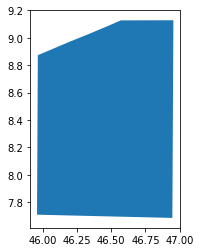

E:\S2_Data_CH22_Original\T32TMS\S2B_MSIL2A_20220509T102559_N0400_R108_T32TMS_20220509T152416.SAFE\INSPIRE.xml


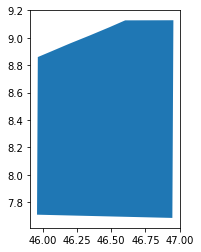

E:\S2_Data_CH22_Original\T32TMS\S2B_MSIL2A_20220516T101559_N0400_R065_T32TMS_20220516T133430.SAFE\INSPIRE.xml


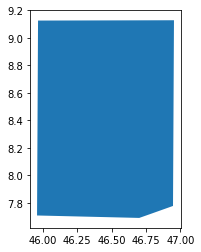

E:\S2_Data_CH22_Original\T32TMS\S2B_MSIL2A_20220516T101559_N0400_R065_T32TMS_20220722T190205.SAFE\INSPIRE.xml


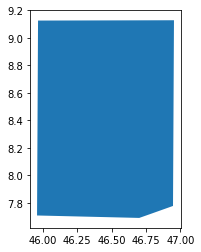

E:\S2_Data_CH22_Original\T32TMS\S2B_MSIL2A_20220519T102559_N0400_R108_T32TMS_20220519T165606.SAFE\INSPIRE.xml


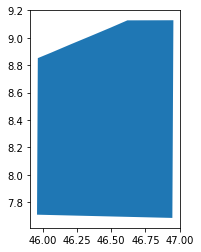

E:\S2_Data_CH22_Original\T32TMS\S2B_MSIL2A_20220519T102559_N0400_R108_T32TMS_20220720T150500.SAFE\INSPIRE.xml


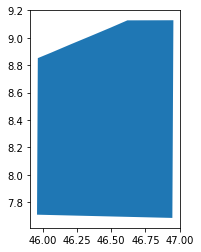

E:\S2_Data_CH22_Original\T32TMS\S2B_MSIL2A_20220526T101559_N0400_R065_T32TMS_20220526T134056.SAFE\INSPIRE.xml


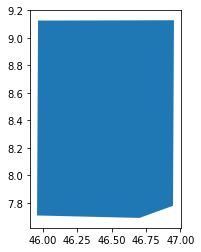

E:\S2_Data_CH22_Original\T32TMS\S2B_MSIL2A_20220529T102559_N0400_R108_T32TMS_20220529T134240.SAFE\INSPIRE.xml


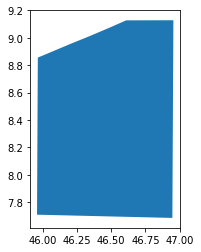

E:\S2_Data_CH22_Original\T32TMS\S2B_MSIL2A_20220608T102559_N0400_R108_T32TMS_20220608T135950.SAFE\INSPIRE.xml


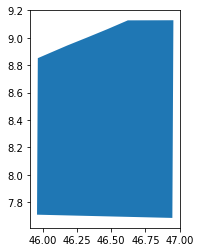

E:\S2_Data_CH22_Original\T32TMS\S2B_MSIL2A_20220615T101559_N0400_R065_T32TMS_20220615T132635.SAFE\INSPIRE.xml


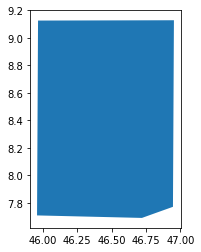

E:\S2_Data_CH22_Original\T32TMS\S2B_MSIL2A_20220618T102559_N0400_R108_T32TMS_20220618T135630.SAFE\INSPIRE.xml


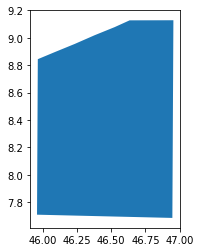

E:\S2_Data_CH22_Original\T32TMS\S2B_MSIL2A_20220625T101559_N0400_R065_T32TMS_20220625T131754.SAFE\INSPIRE.xml


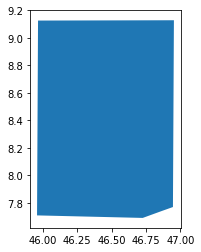

E:\S2_Data_CH22_Original\T32TMS\S2B_MSIL2A_20220705T101559_N0400_R065_T32TMS_20220705T131726.SAFE\INSPIRE.xml


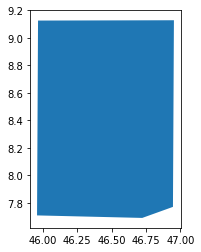

E:\S2_Data_CH22_Original\T32TMS\S2B_MSIL2A_20220708T102559_N0400_R108_T32TMS_20220708T131740.SAFE\INSPIRE.xml


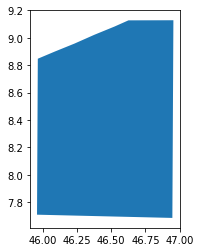

E:\S2_Data_CH22_Original\T32TMS\S2B_MSIL2A_20220715T101559_N0400_R065_T32TMS_20220715T133111.SAFE\INSPIRE.xml


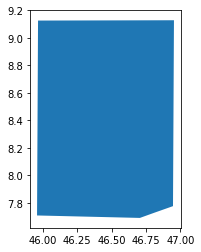

E:\S2_Data_CH22_Original\T32TMS\S2B_MSIL2A_20220718T102559_N0400_R108_T32TMS_20220718T133811.SAFE\INSPIRE.xml


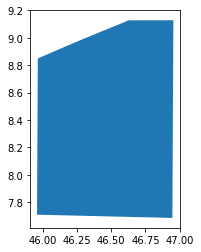

E:\S2_Data_CH22_Original\T32TMS\S2B_MSIL2A_20220725T101559_N0400_R065_T32TMS_20220725T132135.SAFE\INSPIRE.xml


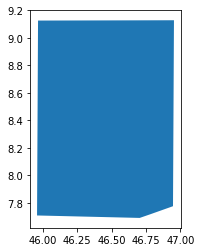

E:\S2_Data_CH22_Original\T32TMS\S2B_MSIL2A_20220728T102559_N0400_R108_T32TMS_20220728T145738.SAFE\INSPIRE.xml


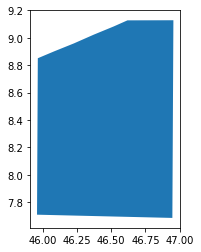

E:\S2_Data_CH22_Original\T32TMS\S2B_MSIL2A_20220804T101559_N0400_R065_T32TMS_20220804T130854.SAFE\INSPIRE.xml


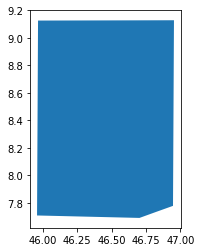

E:\S2_Data_CH22_Original\T32TMS\S2B_MSIL2A_20220807T102559_N0400_R108_T32TMS_20220807T132122.SAFE\INSPIRE.xml


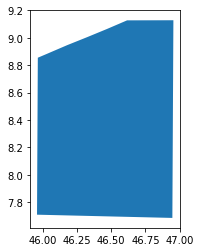

E:\S2_Data_CH22_Original\T32TMS\S2B_MSIL2A_20220817T102559_N0400_R108_T32TMS_20220817T132522.SAFE\INSPIRE.xml


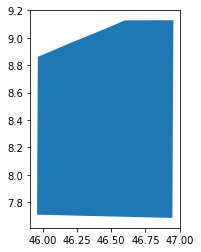

E:\S2_Data_CH22_Original\T32TMS\S2B_MSIL2A_20220824T101559_N0400_R065_T32TMS_20220824T131202.SAFE\INSPIRE.xml


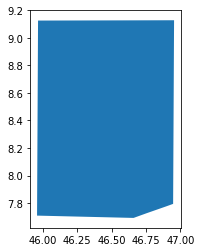

E:\S2_Data_CH22_Original\T32TMS\S2B_MSIL2A_20220827T102559_N0400_R108_T32TMS_20220827T132155.SAFE\INSPIRE.xml


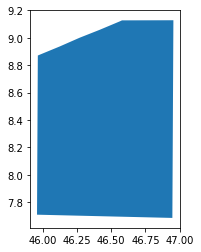

E:\S2_Data_CH22_Original\T32TMS\S2B_MSIL2A_20220906T102559_N0400_R108_T32TMS_20220906T131726.SAFE\INSPIRE.xml


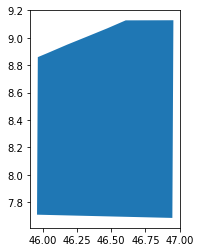

E:\S2_Data_CH22_Original\T32TMS\S2B_MSIL2A_20220913T101629_N0400_R065_T32TMS_20220913T144542.SAFE\INSPIRE.xml


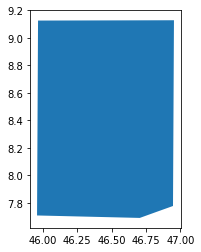

E:\S2_Data_CH22_Original\T32TMS\S2B_MSIL2A_20220916T102639_N0400_R108_T32TMS_20220916T131746.SAFE\INSPIRE.xml


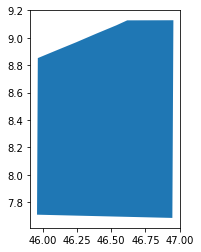

E:\S2_Data_CH22_Original\T32TMS\S2B_MSIL2A_20220923T101649_N0400_R065_T32TMS_20220923T144734.SAFE\INSPIRE.xml


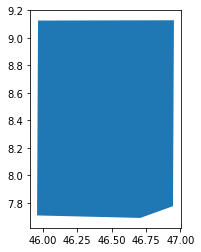

E:\S2_Data_CH22_Original\T32TMS\S2B_MSIL2A_20220926T102709_N0400_R108_T32TMS_20220926T134524.SAFE\INSPIRE.xml


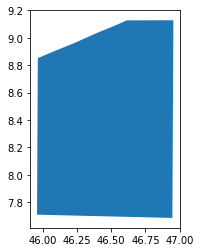

E:\S2_Data_CH22_Original\T32TMS\S2B_MSIL2A_20221003T101749_N0400_R065_T32TMS_20221003T162756.SAFE\INSPIRE.xml


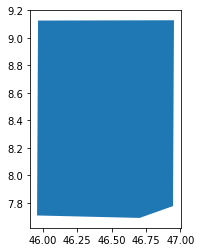

E:\S2_Data_CH22_Original\T32TMS\S2B_MSIL2A_20221006T102949_N0400_R108_T32TMS_20221006T181350.SAFE\INSPIRE.xml


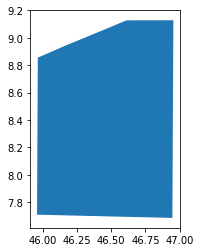

E:\S2_Data_CH22_Original\T32TMS\S2B_MSIL2A_20221016T102919_N0400_R108_T32TMS_20221016T131725.SAFE\INSPIRE.xml


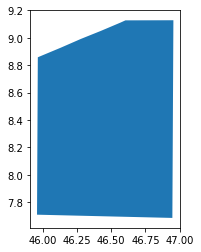

E:\S2_Data_CH22_Original\T32TMS\S2B_MSIL2A_20221026T103029_N0400_R108_T32TMS_20221026T132935.SAFE\INSPIRE.xml


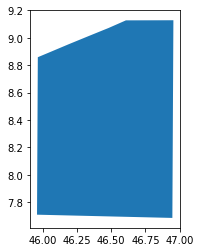

E:\S2_Data_CH22_Original\T32TMS\S2B_MSIL2A_20221102T102059_N0400_R065_T32TMS_20221102T130733.SAFE\INSPIRE.xml


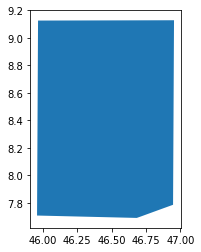

E:\S2_Data_CH22_Original\T32TMS\S2B_MSIL2A_20221105T103119_N0400_R108_T32TMS_20221105T133307.SAFE\INSPIRE.xml


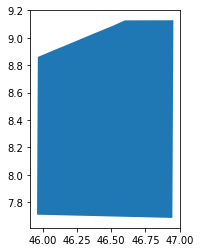

E:\S2_Data_CH22_Original\T32TMS\S2B_MSIL2A_20221105T103119_N0400_R108_T32TMS_20221105T135021.SAFE\INSPIRE.xml


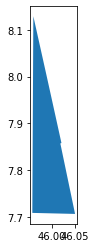

E:\S2_Data_CH22_Original\T32TMS\S2B_MSIL2A_20221112T102159_N0400_R065_T32TMS_20221112T132249.SAFE\INSPIRE.xml


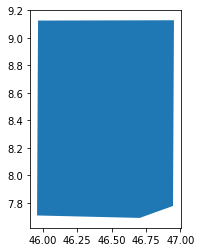

E:\S2_Data_CH22_Original\T32TMS\S2B_MSIL2A_20221122T102239_N0400_R065_T32TMS_20221122T112553.SAFE\INSPIRE.xml


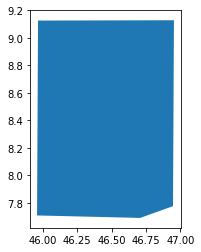

E:\S2_Data_CH22_Original\T32TMS\S2B_MSIL2A_20221125T103259_N0400_R108_T32TMS_20221125T113610.SAFE\INSPIRE.xml


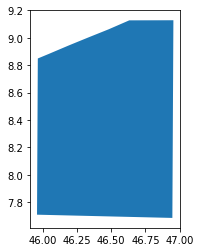

E:\S2_Data_CH22_Original\T32TMS\S2B_MSIL2A_20221202T102309_N0400_R065_T32TMS_20221202T113158.SAFE\INSPIRE.xml


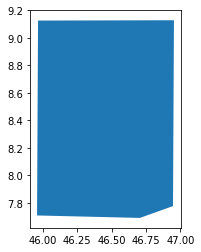

E:\S2_Data_CH22_Original\T32TMS\S2B_MSIL2A_20221222T102339_N0509_R065_T32TMS_20221222T113435.SAFE\INSPIRE.xml


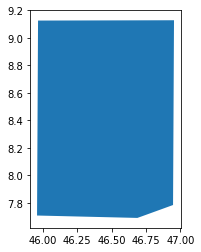

E:\S2_Data_CH22_Original\T32TMS\S2B_MSIL2A_20221225T103349_N0509_R108_T32TMS_20221225T114808.SAFE\INSPIRE.xml


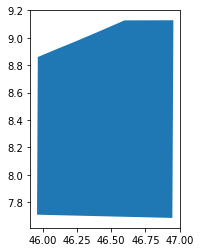

E:\S2_Data_CH22_Original\T32TLS\S2A_MSIL2A_20220101T102431_N0301_R065_T32TLS_20220101T133200.SAFE\INSPIRE.xml


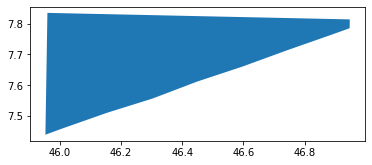

E:\S2_Data_CH22_Original\T32TLS\S2A_MSIL2A_20220107T104431_N0301_R008_T32TLS_20220107T133719.SAFE\INSPIRE.xml


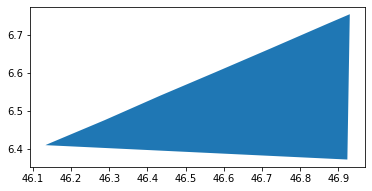

E:\S2_Data_CH22_Original\T32TLS\S2A_MSIL2A_20220111T102411_N0301_R065_T32TLS_20220111T131516.SAFE\INSPIRE.xml


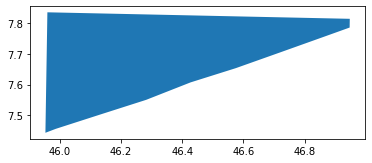

E:\S2_Data_CH22_Original\T32TLS\S2A_MSIL2A_20220114T103401_N0301_R108_T32TLS_20220114T132749.SAFE\INSPIRE.xml


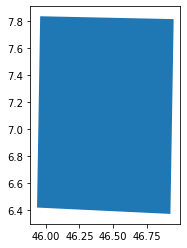

E:\S2_Data_CH22_Original\T32TLS\S2A_MSIL2A_20220117T104401_N0301_R008_T32TLS_20220117T133951.SAFE\INSPIRE.xml


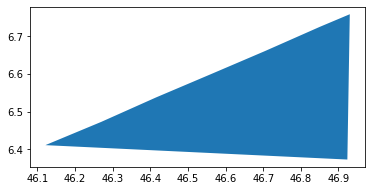

E:\S2_Data_CH22_Original\T32TLS\S2A_MSIL2A_20220121T102331_N0301_R065_T32TLS_20220121T131536.SAFE\INSPIRE.xml


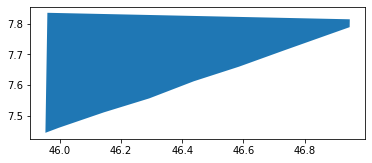

E:\S2_Data_CH22_Original\T32TLS\S2A_MSIL2A_20220124T103331_N0301_R108_T32TLS_20220124T163734.SAFE\INSPIRE.xml


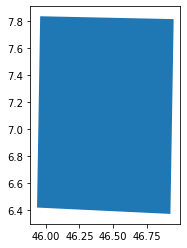

E:\S2_Data_CH22_Original\T32TLS\S2A_MSIL2A_20220127T104321_N0400_R008_T32TLS_20220127T151103.SAFE\INSPIRE.xml


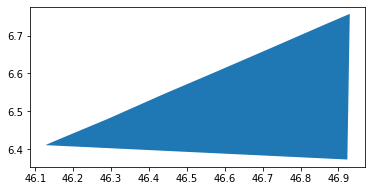

E:\S2_Data_CH22_Original\T32TLS\S2A_MSIL2A_20220203T103231_N0400_R108_T32TLS_20220203T153332.SAFE\INSPIRE.xml


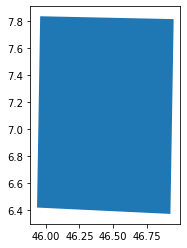

E:\S2_Data_CH22_Original\T32TLS\S2A_MSIL2A_20220210T102151_N0400_R065_T32TLS_20220210T153400.SAFE\INSPIRE.xml


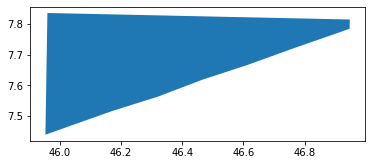

E:\S2_Data_CH22_Original\T32TLS\S2A_MSIL2A_20220213T103131_N0400_R108_T32TLS_20220213T152822.SAFE\INSPIRE.xml


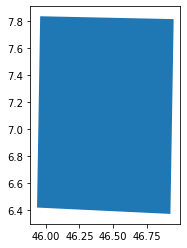

E:\S2_Data_CH22_Original\T32TLS\S2A_MSIL2A_20220220T102051_N0400_R065_T32TLS_20220220T152532.SAFE\INSPIRE.xml


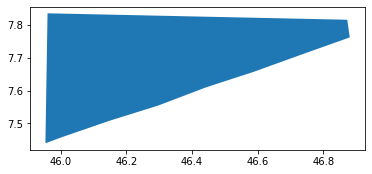

E:\S2_Data_CH22_Original\T32TLS\S2A_MSIL2A_20220223T103031_N0400_R108_T32TLS_20220223T154141.SAFE\INSPIRE.xml


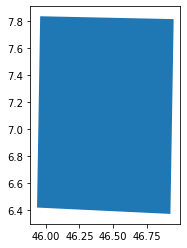

E:\S2_Data_CH22_Original\T32TLS\S2A_MSIL2A_20220226T104011_N0400_R008_T32TLS_20220226T135412.SAFE\INSPIRE.xml


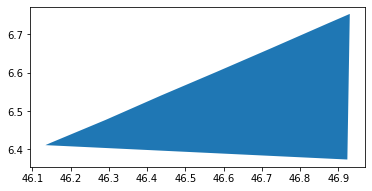

E:\S2_Data_CH22_Original\T32TLS\S2A_MSIL2A_20220302T101941_N0400_R065_T32TLS_20220302T135825.SAFE\INSPIRE.xml


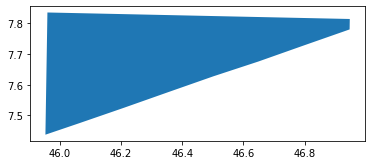

E:\S2_Data_CH22_Original\T32TLS\S2A_MSIL2A_20220305T102921_N0400_R108_T32TLS_20220305T135811.SAFE\INSPIRE.xml


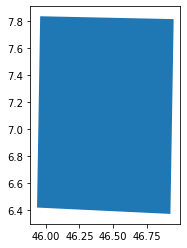

E:\S2_Data_CH22_Original\T32TLS\S2A_MSIL2A_20220308T103901_N0400_R008_T32TLS_20220308T142755.SAFE\INSPIRE.xml


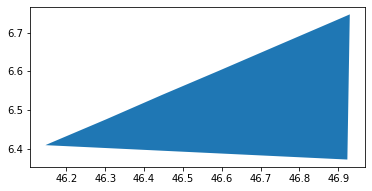

E:\S2_Data_CH22_Original\T32TLS\S2A_MSIL2A_20220312T101831_N0400_R065_T32TLS_20220312T134516.SAFE\INSPIRE.xml


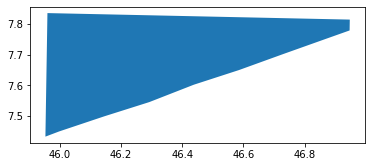

E:\S2_Data_CH22_Original\T32TLS\S2A_MSIL2A_20220322T101711_N0400_R065_T32TLS_20220322T141030.SAFE\INSPIRE.xml


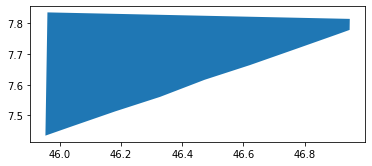

E:\S2_Data_CH22_Original\T32TLS\S2A_MSIL2A_20220325T102651_N0400_R108_T32TLS_20220325T162307.SAFE\INSPIRE.xml


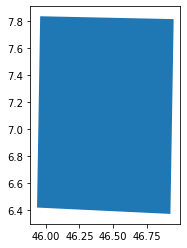

E:\S2_Data_CH22_Original\T32TLS\S2A_MSIL2A_20220328T103641_N0400_R008_T32TLS_20220328T140800.SAFE\INSPIRE.xml


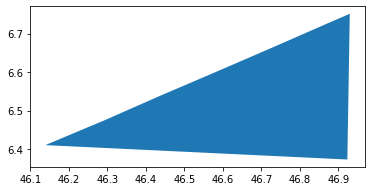

E:\S2_Data_CH22_Original\T32TLS\S2A_MSIL2A_20220404T102601_N0400_R108_T32TLS_20220404T135834.SAFE\INSPIRE.xml


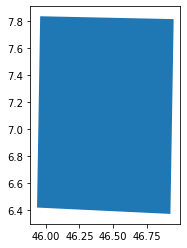

E:\S2_Data_CH22_Original\T32TLS\S2A_MSIL2A_20220411T101601_N0400_R065_T32TLS_20220411T135651.SAFE\INSPIRE.xml


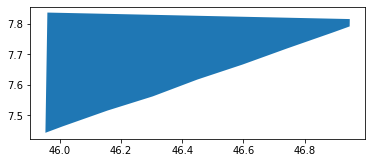

E:\S2_Data_CH22_Original\T32TLS\S2A_MSIL2A_20220414T102601_N0400_R108_T32TLS_20220414T155046.SAFE\INSPIRE.xml


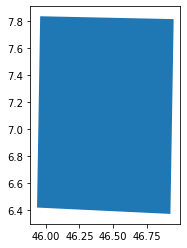

E:\S2_Data_CH22_Original\T32TLS\S2A_MSIL2A_20220417T103631_N0400_R008_T32TLS_20220417T144456.SAFE\INSPIRE.xml


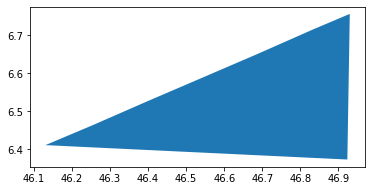

E:\S2_Data_CH22_Original\T32TLS\S2A_MSIL2A_20220421T101601_N0400_R065_T32TLS_20220421T134744.SAFE\INSPIRE.xml


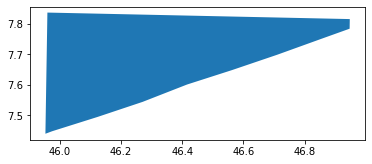

E:\S2_Data_CH22_Original\T32TLS\S2A_MSIL2A_20220427T103631_N0400_R008_T32TLS_20220427T145849.SAFE\INSPIRE.xml


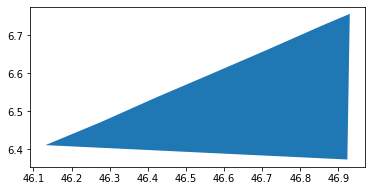

E:\S2_Data_CH22_Original\T32TLS\S2A_MSIL2A_20220501T101601_N0400_R065_T32TLS_20220501T154819.SAFE\INSPIRE.xml


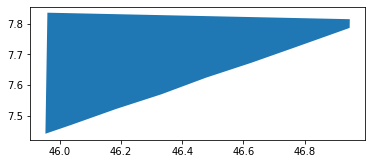

E:\S2_Data_CH22_Original\T32TLS\S2A_MSIL2A_20220504T102601_N0400_R108_T32TLS_20220504T185514.SAFE\INSPIRE.xml


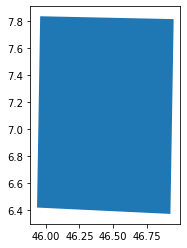

E:\S2_Data_CH22_Original\T32TLS\S2A_MSIL2A_20220507T103631_N0400_R008_T32TLS_20220507T154214.SAFE\INSPIRE.xml


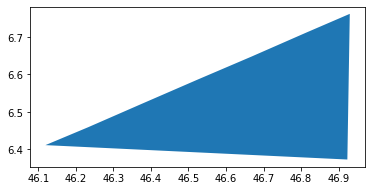

E:\S2_Data_CH22_Original\T32TLS\S2A_MSIL2A_20220511T101601_N0400_R065_T32TLS_20220511T174519.SAFE\INSPIRE.xml


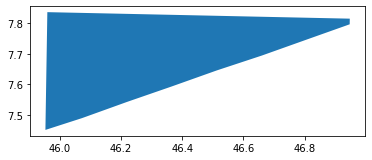

E:\S2_Data_CH22_Original\T32TLS\S2A_MSIL2A_20220514T102601_N0400_R108_T32TLS_20220514T165714.SAFE\INSPIRE.xml


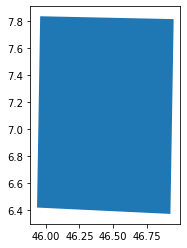

E:\S2_Data_CH22_Original\T32TLS\S2A_MSIL2A_20220521T101601_N0400_R065_T32TLS_20220521T181716.SAFE\INSPIRE.xml


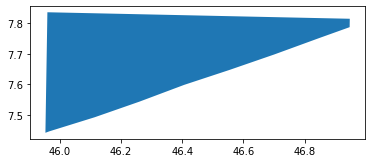

E:\S2_Data_CH22_Original\T32TLS\S2A_MSIL2A_20220527T103631_N0400_R008_T32TLS_20220527T183616.SAFE\INSPIRE.xml


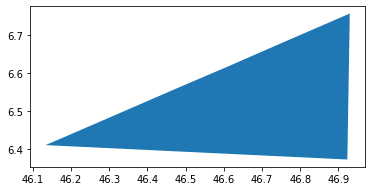

E:\S2_Data_CH22_Original\T32TLS\S2A_MSIL2A_20220610T101611_N0400_R065_T32TLS_20220610T181610.SAFE\INSPIRE.xml


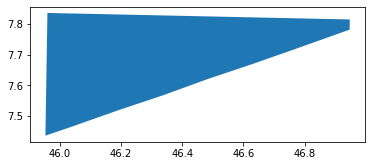

E:\S2_Data_CH22_Original\T32TLS\S2A_MSIL2A_20220613T103031_N0400_R108_T32TLS_20220613T235021.SAFE\INSPIRE.xml


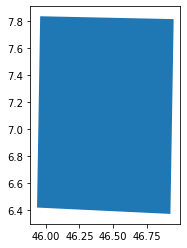

E:\S2_Data_CH22_Original\T32TLS\S2A_MSIL2A_20220616T103631_N0400_R008_T32TLS_20220616T202909.SAFE\INSPIRE.xml


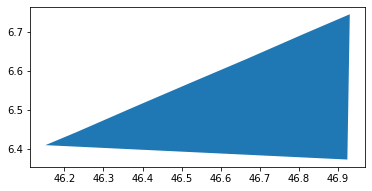

E:\S2_Data_CH22_Original\T32TLS\S2A_MSIL2A_20220616T103631_N9999_R008_T32TLS_20221230T065457.SAFE\INSPIRE.xml


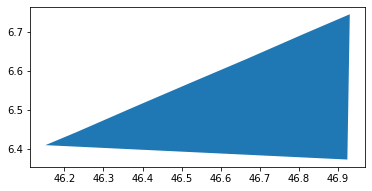

E:\S2_Data_CH22_Original\T32TLS\S2A_MSIL2A_20220620T102041_N0400_R065_T32TLS_20220620T162319.SAFE\INSPIRE.xml


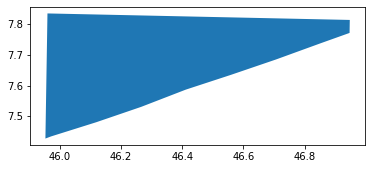

E:\S2_Data_CH22_Original\T32TLS\S2A_MSIL2A_20220620T102041_N9999_R065_T32TLS_20221231T115509.SAFE\INSPIRE.xml


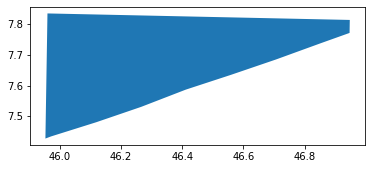

E:\S2_Data_CH22_Original\T32TLS\S2A_MSIL2A_20220623T103031_N0400_R108_T32TLS_20220623T170319.SAFE\INSPIRE.xml


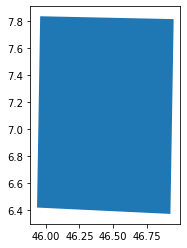

E:\S2_Data_CH22_Original\T32TLS\S2A_MSIL2A_20220623T103031_N9999_R108_T32TLS_20230101T160029.SAFE\INSPIRE.xml


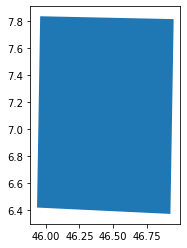

E:\S2_Data_CH22_Original\T32TLS\S2A_MSIL2A_20220626T103641_N0400_R008_T32TLS_20220626T183510.SAFE\INSPIRE.xml


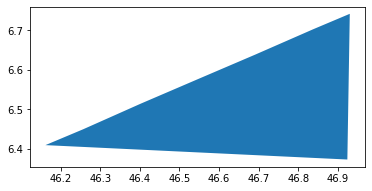

E:\S2_Data_CH22_Original\T32TLS\S2A_MSIL2A_20220630T102041_N0400_R065_T32TLS_20220630T182013.SAFE\INSPIRE.xml


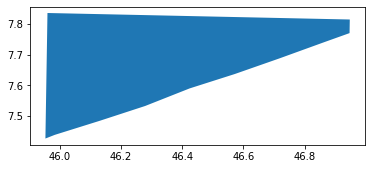

E:\S2_Data_CH22_Original\T32TLS\S2A_MSIL2A_20220703T102611_N0400_R108_T32TLS_20220703T182512.SAFE\INSPIRE.xml


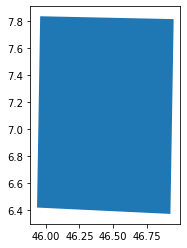

E:\S2_Data_CH22_Original\T32TLS\S2A_MSIL2A_20220706T103641_N0400_R008_T32TLS_20220706T183816.SAFE\INSPIRE.xml


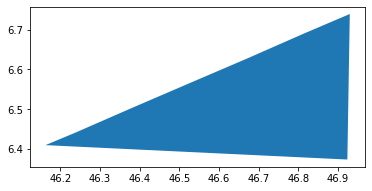

E:\S2_Data_CH22_Original\T32TLS\S2A_MSIL2A_20220710T101611_N0400_R065_T32TLS_20220710T165533.SAFE\INSPIRE.xml


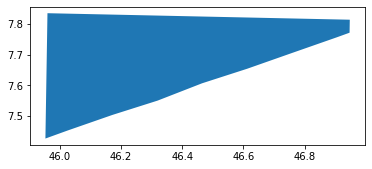

E:\S2_Data_CH22_Original\T32TLS\S2A_MSIL2A_20220713T103041_N0400_R108_T32TLS_20220713T164557.SAFE\INSPIRE.xml


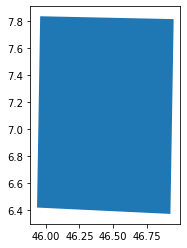

E:\S2_Data_CH22_Original\T32TLS\S2A_MSIL2A_20220716T103641_N0400_R008_T32TLS_20220716T183414.SAFE\INSPIRE.xml


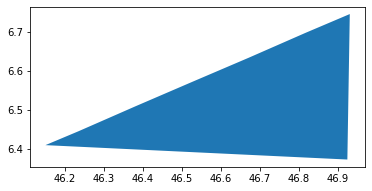

E:\S2_Data_CH22_Original\T32TLS\S2A_MSIL2A_20220720T101611_N0400_R065_T32TLS_20220720T164302.SAFE\INSPIRE.xml


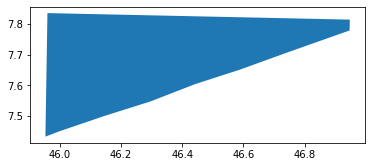

E:\S2_Data_CH22_Original\T32TLS\S2A_MSIL2A_20220723T102611_N0400_R108_T32TLS_20220723T164456.SAFE\INSPIRE.xml


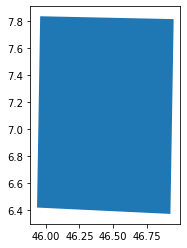

E:\S2_Data_CH22_Original\T32TLS\S2A_MSIL2A_20220726T103631_N0400_R008_T32TLS_20220726T201057.SAFE\INSPIRE.xml


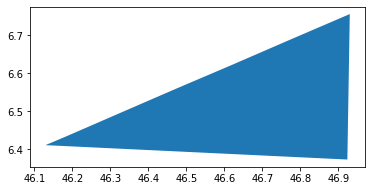

E:\S2_Data_CH22_Original\T32TLS\S2A_MSIL2A_20220730T101611_N0400_R065_T32TLS_20220730T180956.SAFE\INSPIRE.xml


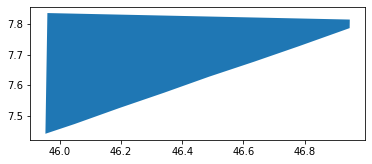

E:\S2_Data_CH22_Original\T32TLS\S2A_MSIL2A_20220802T102611_N0400_R108_T32TLS_20220802T184101.SAFE\INSPIRE.xml


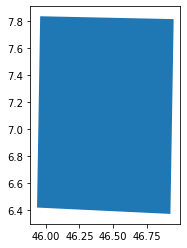

E:\S2_Data_CH22_Original\T32TLS\S2A_MSIL2A_20220805T103631_N0400_R008_T32TLS_20220805T183602.SAFE\INSPIRE.xml


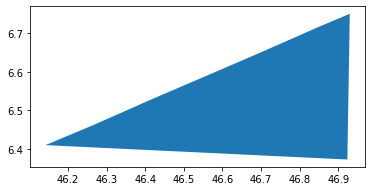

E:\S2_Data_CH22_Original\T32TLS\S2A_MSIL2A_20220809T102041_N0400_R065_T32TLS_20220809T180703.SAFE\INSPIRE.xml


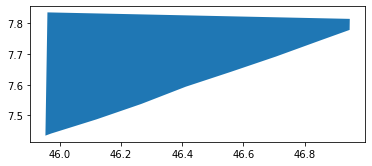

E:\S2_Data_CH22_Original\T32TLS\S2A_MSIL2A_20220812T103031_N0400_R108_T32TLS_20220812T182800.SAFE\INSPIRE.xml


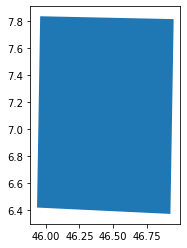

E:\S2_Data_CH22_Original\T32TLS\S2A_MSIL2A_20220815T103641_N0400_R008_T32TLS_20220815T183259.SAFE\INSPIRE.xml


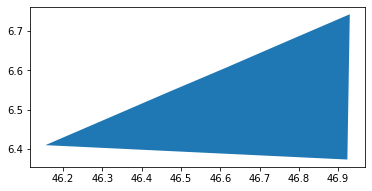

E:\S2_Data_CH22_Original\T32TLS\S2A_MSIL2A_20220822T102611_N0400_R108_T32TLS_20220822T184205.SAFE\INSPIRE.xml


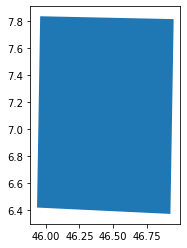

E:\S2_Data_CH22_Original\T32TLS\S2A_MSIL2A_20220825T103641_N0400_R008_T32TLS_20220825T201458.SAFE\INSPIRE.xml


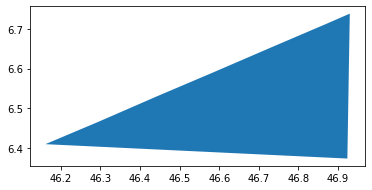

E:\S2_Data_CH22_Original\T32TLS\S2A_MSIL2A_20220829T101611_N0400_R065_T32TLS_20220829T163601.SAFE\INSPIRE.xml


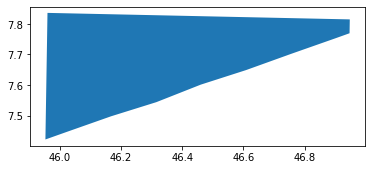

E:\S2_Data_CH22_Original\T32TLS\S2A_MSIL2A_20220901T102611_N0400_R108_T32TLS_20220901T182256.SAFE\INSPIRE.xml


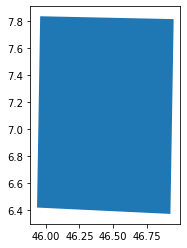

E:\S2_Data_CH22_Original\T32TLS\S2A_MSIL2A_20220904T103641_N0400_R008_T32TLS_20220904T183007.SAFE\INSPIRE.xml


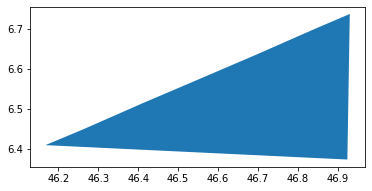

E:\S2_Data_CH22_Original\T32TLS\S2A_MSIL2A_20220908T102031_N0400_R065_T32TLS_20220908T200258.SAFE\INSPIRE.xml


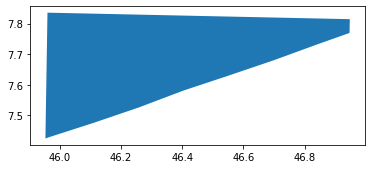

E:\S2_Data_CH22_Original\T32TLS\S2A_MSIL2A_20220911T102621_N0400_R108_T32TLS_20220911T165754.SAFE\INSPIRE.xml


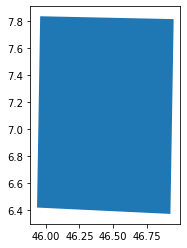

E:\S2_Data_CH22_Original\T32TLS\S2A_MSIL2A_20220918T101701_N0400_R065_T32TLS_20220918T162258.SAFE\INSPIRE.xml


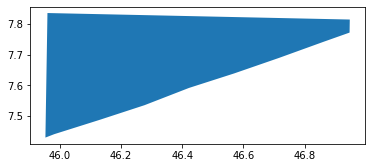

E:\S2_Data_CH22_Original\T32TLS\S2A_MSIL2A_20220921T102731_N0400_R108_T32TLS_20220921T164458.SAFE\INSPIRE.xml


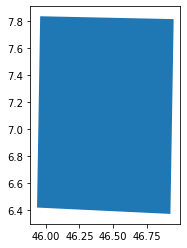

E:\S2_Data_CH22_Original\T32TLS\S2A_MSIL2A_20220924T103801_N0400_R008_T32TLS_20220924T183500.SAFE\INSPIRE.xml


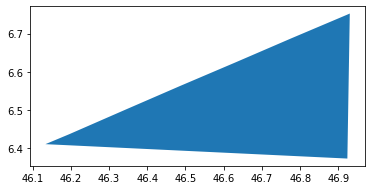

E:\S2_Data_CH22_Original\T32TLS\S2A_MSIL2A_20221011T102951_N0400_R108_T32TLS_20221011T163653.SAFE\INSPIRE.xml


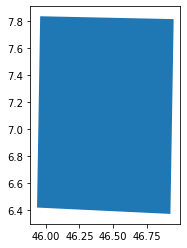

E:\S2_Data_CH22_Original\T32TLS\S2A_MSIL2A_20221018T102031_N0400_R065_T32TLS_20221018T162355.SAFE\INSPIRE.xml


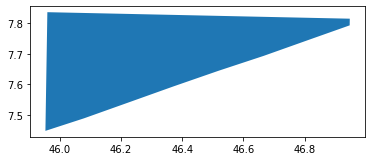

E:\S2_Data_CH22_Original\T32TLS\S2A_MSIL2A_20221028T102131_N0400_R065_T32TLS_20221028T140955.SAFE\INSPIRE.xml


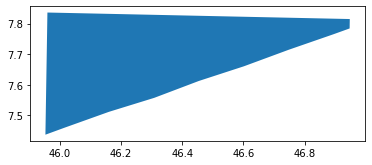

E:\S2_Data_CH22_Original\T32TLS\S2A_MSIL2A_20221031T103151_N0400_R108_T32TLS_20221031T164300.SAFE\INSPIRE.xml


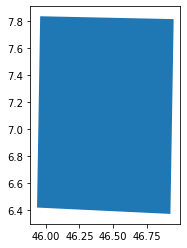

E:\S2_Data_CH22_Original\T32TLS\S2A_MSIL2A_20221110T103251_N0400_R108_T32TLS_20221110T163904.SAFE\INSPIRE.xml


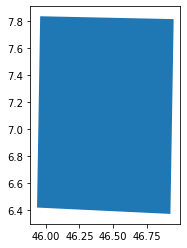

E:\S2_Data_CH22_Original\T32TLS\S2A_MSIL2A_20221113T104311_N0400_R008_T32TLS_20221113T155653.SAFE\INSPIRE.xml


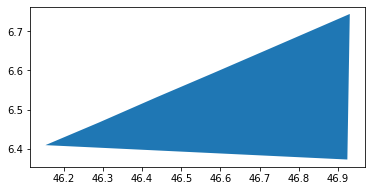

E:\S2_Data_CH22_Original\T32TLS\S2A_MSIL2A_20221117T102311_N0400_R065_T32TLS_20221117T163558.SAFE\INSPIRE.xml


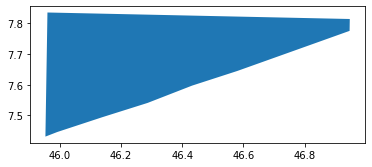

E:\S2_Data_CH22_Original\T32TLS\S2A_MSIL2A_20221120T103331_N0400_R108_T32TLS_20221120T164159.SAFE\INSPIRE.xml


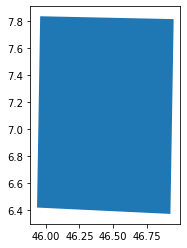

E:\S2_Data_CH22_Original\T32TLS\S2A_MSIL2A_20221123T104351_N0400_R008_T32TLS_20221123T155652.SAFE\INSPIRE.xml


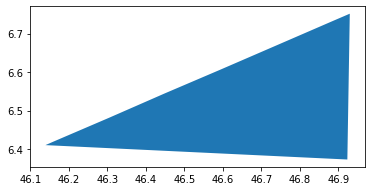

E:\S2_Data_CH22_Original\T32TLS\S2A_MSIL2A_20221127T102351_N0400_R065_T32TLS_20221127T140108.SAFE\INSPIRE.xml


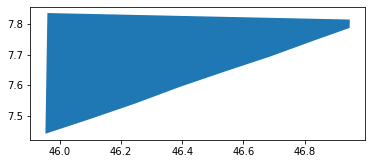

E:\S2_Data_CH22_Original\T32TLS\S2A_MSIL2A_20221130T103411_N0400_R108_T32TLS_20221130T163008.SAFE\INSPIRE.xml


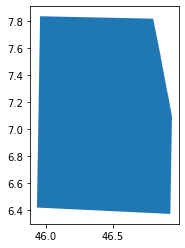

E:\S2_Data_CH22_Original\T32TLS\S2A_MSIL2A_20221207T102411_N0509_R065_T32TLS_20221207T135807.SAFE\INSPIRE.xml


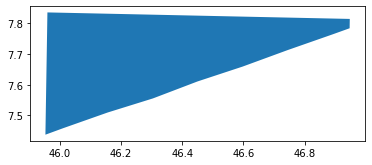

E:\S2_Data_CH22_Original\T32TLS\S2A_MSIL2A_20221217T102431_N0509_R065_T32TLS_20221217T141955.SAFE\INSPIRE.xml


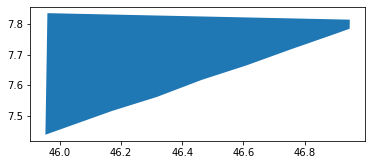

E:\S2_Data_CH22_Original\T32TLS\S2A_MSIL2A_20221220T103441_N0509_R108_T32TLS_20221220T134756.SAFE\INSPIRE.xml


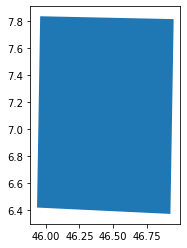

E:\S2_Data_CH22_Original\T32TLS\S2A_MSIL2A_20221227T102431_N0509_R065_T32TLS_20221227T140052.SAFE\INSPIRE.xml


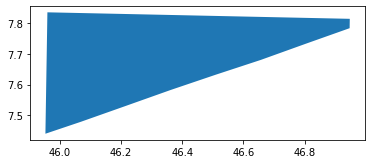

E:\S2_Data_CH22_Original\T32TLS\S2A_MSIL2A_20221230T103431_N0509_R108_T32TLS_20221230T134707.SAFE\INSPIRE.xml


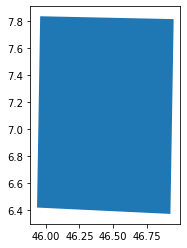

E:\S2_Data_CH22_Original\T32TLS\S2B_MSIL2A_20220106T102319_N0301_R065_T32TLS_20220106T123401.SAFE\INSPIRE.xml


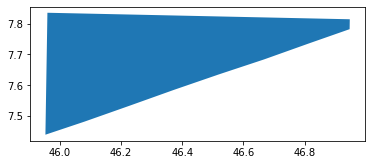

E:\S2_Data_CH22_Original\T32TLS\S2B_MSIL2A_20220109T103319_N0301_R108_T32TLS_20220109T121931.SAFE\INSPIRE.xml


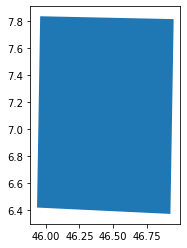

E:\S2_Data_CH22_Original\T32TLS\S2B_MSIL2A_20220112T104319_N0301_R008_T32TLS_20220112T123824.SAFE\INSPIRE.xml


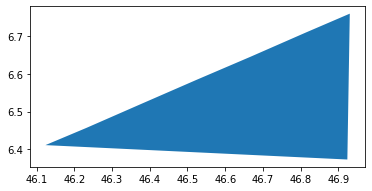

E:\S2_Data_CH22_Original\T32TLS\S2B_MSIL2A_20220116T102249_N0301_R065_T32TLS_20220116T123439.SAFE\INSPIRE.xml


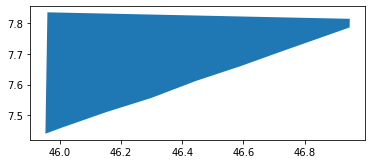

E:\S2_Data_CH22_Original\T32TLS\S2B_MSIL2A_20220119T103249_N0301_R108_T32TLS_20220119T121956.SAFE\INSPIRE.xml


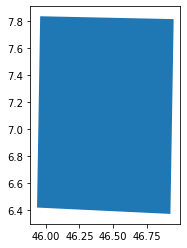

E:\S2_Data_CH22_Original\T32TLS\S2B_MSIL2A_20220122T104239_N0301_R008_T32TLS_20220122T121827.SAFE\INSPIRE.xml


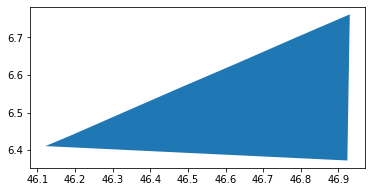

E:\S2_Data_CH22_Original\T32TLS\S2B_MSIL2A_20220126T102209_N0400_R065_T32TLS_20220126T121533.SAFE\INSPIRE.xml


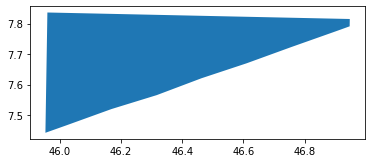

E:\S2_Data_CH22_Original\T32TLS\S2B_MSIL2A_20220129T103159_N0400_R108_T32TLS_20220129T120945.SAFE\INSPIRE.xml


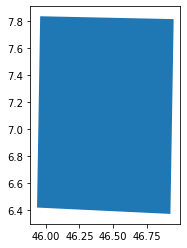

E:\S2_Data_CH22_Original\T32TLS\S2B_MSIL2A_20220205T102119_N0400_R065_T32TLS_20220205T121510.SAFE\INSPIRE.xml


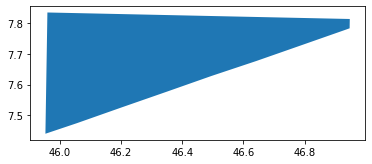

E:\S2_Data_CH22_Original\T32TLS\S2B_MSIL2A_20220208T103109_N0400_R108_T32TLS_20220208T143549.SAFE\INSPIRE.xml


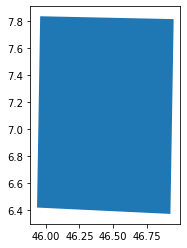

E:\S2_Data_CH22_Original\T32TLS\S2B_MSIL2A_20220211T104049_N0400_R008_T32TLS_20220211T145400.SAFE\INSPIRE.xml


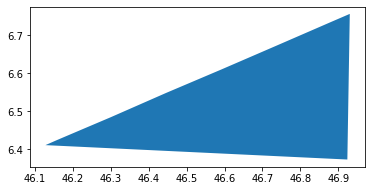

E:\S2_Data_CH22_Original\T32TLS\S2B_MSIL2A_20220215T102019_N0400_R065_T32TLS_20220215T122705.SAFE\INSPIRE.xml


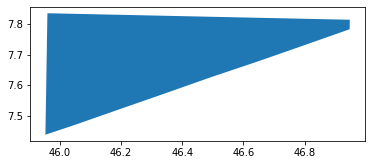

E:\S2_Data_CH22_Original\T32TLS\S2B_MSIL2A_20220221T103949_N0400_R008_T32TLS_20220221T122629.SAFE\INSPIRE.xml


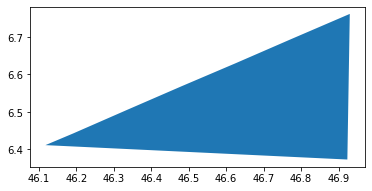

E:\S2_Data_CH22_Original\T32TLS\S2B_MSIL2A_20220225T101909_N0400_R065_T32TLS_20220225T132831.SAFE\INSPIRE.xml


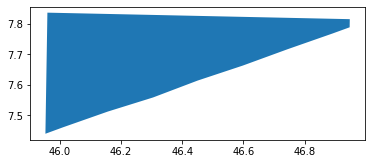

E:\S2_Data_CH22_Original\T32TLS\S2B_MSIL2A_20220228T102849_N0400_R108_T32TLS_20220228T134712.SAFE\INSPIRE.xml


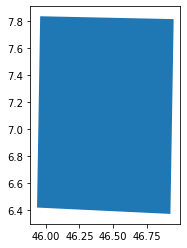

E:\S2_Data_CH22_Original\T32TLS\S2B_MSIL2A_20220303T103839_N0400_R008_T32TLS_20220304T191818.SAFE\INSPIRE.xml


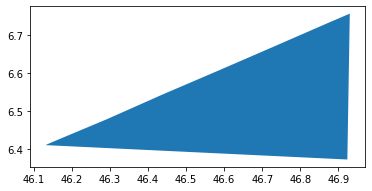

E:\S2_Data_CH22_Original\T32TLS\S2B_MSIL2A_20220307T101759_N0400_R065_T32TLS_20220307T133430.SAFE\INSPIRE.xml


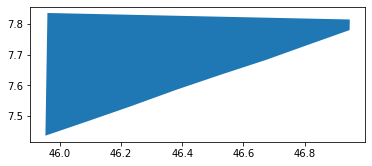

E:\S2_Data_CH22_Original\T32TLS\S2B_MSIL2A_20220310T102739_N0400_R108_T32TLS_20220310T134645.SAFE\INSPIRE.xml


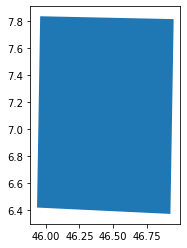

E:\S2_Data_CH22_Original\T32TLS\S2B_MSIL2A_20220317T101649_N0400_R065_T32TLS_20220317T135341.SAFE\INSPIRE.xml


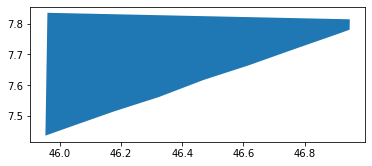

E:\S2_Data_CH22_Original\T32TLS\S2B_MSIL2A_20220320T102639_N0400_R108_T32TLS_20220320T135549.SAFE\INSPIRE.xml


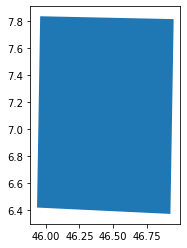

E:\S2_Data_CH22_Original\T32TLS\S2B_MSIL2A_20220323T103639_N0400_R008_T32TLS_20220323T140421.SAFE\INSPIRE.xml


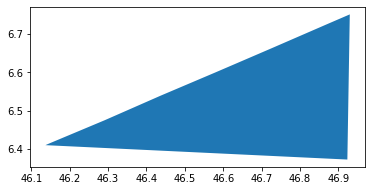

E:\S2_Data_CH22_Original\T32TLS\S2B_MSIL2A_20220327T101629_N0400_R065_T32TLS_20220327T141610.SAFE\INSPIRE.xml


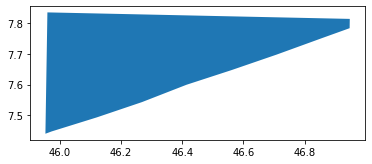

E:\S2_Data_CH22_Original\T32TLS\S2B_MSIL2A_20220406T101559_N0400_R065_T32TLS_20220406T154623.SAFE\INSPIRE.xml


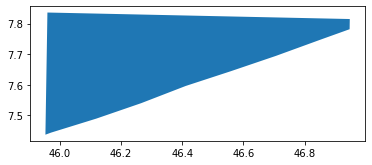

E:\S2_Data_CH22_Original\T32TLS\S2B_MSIL2A_20220412T103619_N0400_R008_T32TLS_20220412T141006.SAFE\INSPIRE.xml


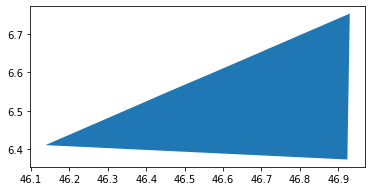

E:\S2_Data_CH22_Original\T32TLS\S2B_MSIL2A_20220416T101559_N0400_R065_T32TLS_20220416T175100.SAFE\INSPIRE.xml


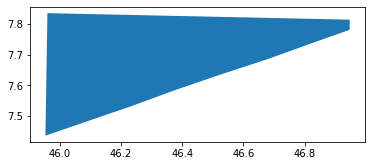

E:\S2_Data_CH22_Original\T32TLS\S2B_MSIL2A_20220419T102559_N0400_R108_T32TLS_20220419T140845.SAFE\INSPIRE.xml


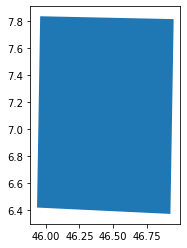

E:\S2_Data_CH22_Original\T32TLS\S2B_MSIL2A_20220422T103619_N0400_R008_T32TLS_20220422T130947.SAFE\INSPIRE.xml


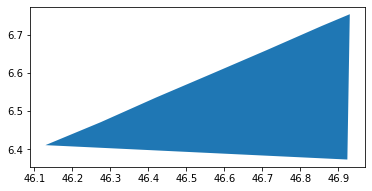

E:\S2_Data_CH22_Original\T32TLS\S2B_MSIL2A_20220429T102549_N0400_R108_T32TLS_20220429T141359.SAFE\INSPIRE.xml


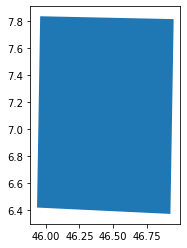

E:\S2_Data_CH22_Original\T32TLS\S2B_MSIL2A_20220502T103619_N0400_R008_T32TLS_20220502T123919.SAFE\INSPIRE.xml


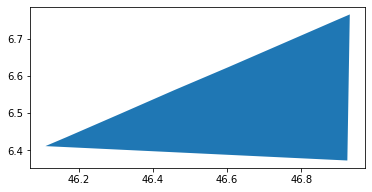

E:\S2_Data_CH22_Original\T32TLS\S2B_MSIL2A_20220506T101559_N0400_R065_T32TLS_20220506T133340.SAFE\INSPIRE.xml


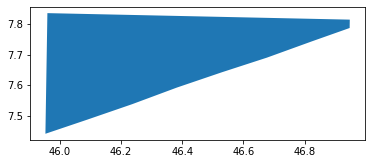

E:\S2_Data_CH22_Original\T32TLS\S2B_MSIL2A_20220509T102559_N0400_R108_T32TLS_20220509T152416.SAFE\INSPIRE.xml


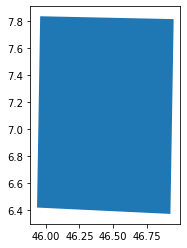

E:\S2_Data_CH22_Original\T32TLS\S2B_MSIL2A_20220512T103619_N0400_R008_T32TLS_20220512T123657.SAFE\INSPIRE.xml


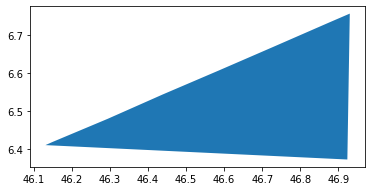

E:\S2_Data_CH22_Original\T32TLS\S2B_MSIL2A_20220519T102559_N0400_R108_T32TLS_20220519T165606.SAFE\INSPIRE.xml


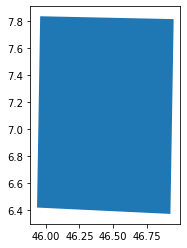

E:\S2_Data_CH22_Original\T32TLS\S2B_MSIL2A_20220519T102559_N0400_R108_T32TLS_20220720T150500.SAFE\INSPIRE.xml


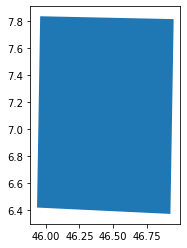

E:\S2_Data_CH22_Original\T32TLS\S2B_MSIL2A_20220522T103629_N0400_R008_T32TLS_20220522T124154.SAFE\INSPIRE.xml


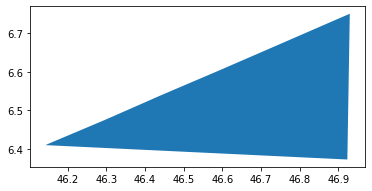

E:\S2_Data_CH22_Original\T32TLS\S2B_MSIL2A_20220526T101559_N0400_R065_T32TLS_20220526T134056.SAFE\INSPIRE.xml


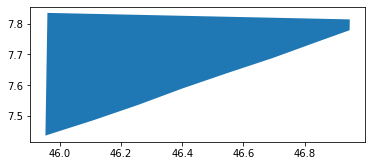

E:\S2_Data_CH22_Original\T32TLS\S2B_MSIL2A_20220529T102559_N0400_R108_T32TLS_20220529T134240.SAFE\INSPIRE.xml


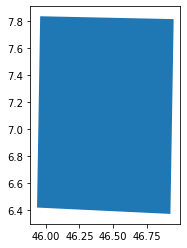

E:\S2_Data_CH22_Original\T32TLS\S2B_MSIL2A_20220608T102559_N0400_R108_T32TLS_20220608T135950.SAFE\INSPIRE.xml


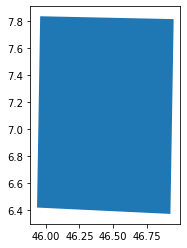

E:\S2_Data_CH22_Original\T32TLS\S2B_MSIL2A_20220611T103629_N0400_R008_T32TLS_20220611T123558.SAFE\INSPIRE.xml


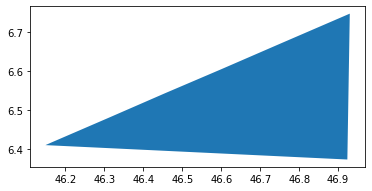

E:\S2_Data_CH22_Original\T32TLS\S2B_MSIL2A_20220615T101559_N0400_R065_T32TLS_20220615T132635.SAFE\INSPIRE.xml


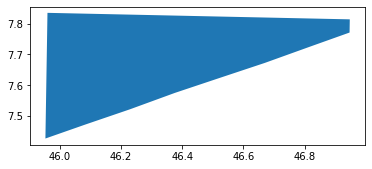

E:\S2_Data_CH22_Original\T32TLS\S2B_MSIL2A_20220618T102559_N0400_R108_T32TLS_20220618T135630.SAFE\INSPIRE.xml


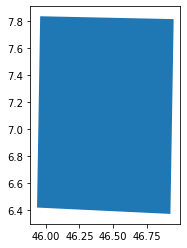

E:\S2_Data_CH22_Original\T32TLS\S2B_MSIL2A_20220621T103629_N0400_R008_T32TLS_20220621T123636.SAFE\INSPIRE.xml


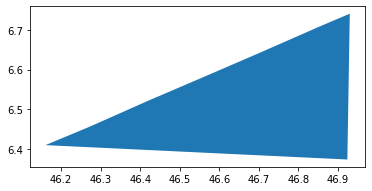

E:\S2_Data_CH22_Original\T32TLS\S2B_MSIL2A_20220625T101559_N0400_R065_T32TLS_20220625T131754.SAFE\INSPIRE.xml


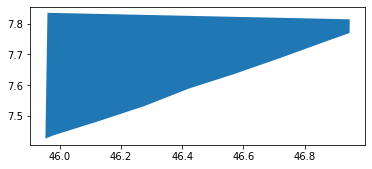

E:\S2_Data_CH22_Original\T32TLS\S2B_MSIL2A_20220701T103629_N0400_R008_T32TLS_20220701T122344.SAFE\INSPIRE.xml


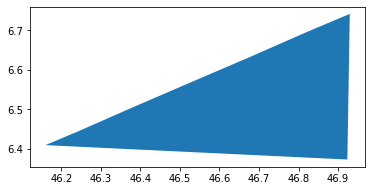

E:\S2_Data_CH22_Original\T32TLS\S2B_MSIL2A_20220705T101559_N0400_R065_T32TLS_20220705T131726.SAFE\INSPIRE.xml


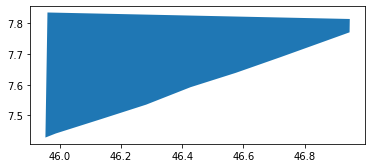

E:\S2_Data_CH22_Original\T32TLS\S2B_MSIL2A_20220708T102559_N0400_R108_T32TLS_20220708T131740.SAFE\INSPIRE.xml


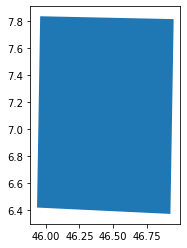

E:\S2_Data_CH22_Original\T32TLS\S2B_MSIL2A_20220711T103629_N0400_R008_T32TLS_20220711T121934.SAFE\INSPIRE.xml


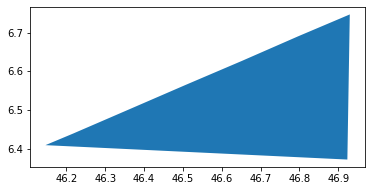

E:\S2_Data_CH22_Original\T32TLS\S2B_MSIL2A_20220715T101559_N0400_R065_T32TLS_20220715T133111.SAFE\INSPIRE.xml


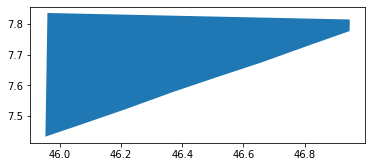

E:\S2_Data_CH22_Original\T32TLS\S2B_MSIL2A_20220718T102559_N0400_R108_T32TLS_20220718T133811.SAFE\INSPIRE.xml


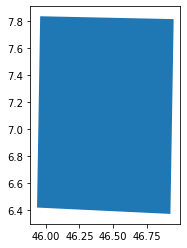

E:\S2_Data_CH22_Original\T32TLS\S2B_MSIL2A_20220721T103629_N0400_R008_T32TLS_20220721T122634.SAFE\INSPIRE.xml


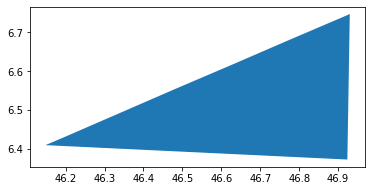

E:\S2_Data_CH22_Original\T32TLS\S2B_MSIL2A_20220725T101559_N0400_R065_T32TLS_20220725T132135.SAFE\INSPIRE.xml


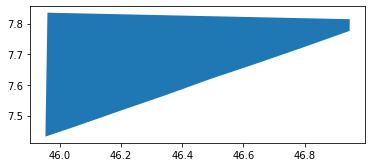

E:\S2_Data_CH22_Original\T32TLS\S2B_MSIL2A_20220728T102559_N0400_R108_T32TLS_20220728T145738.SAFE\INSPIRE.xml


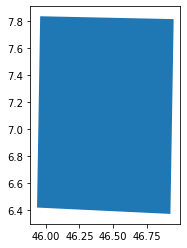

E:\S2_Data_CH22_Original\T32TLS\S2B_MSIL2A_20220731T103629_N0400_R008_T32TLS_20220731T133607.SAFE\INSPIRE.xml


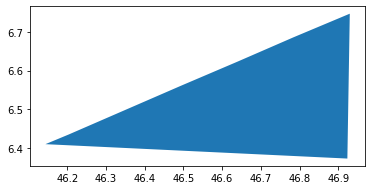

E:\S2_Data_CH22_Original\T32TLS\S2B_MSIL2A_20220804T101559_N0400_R065_T32TLS_20220804T130854.SAFE\INSPIRE.xml


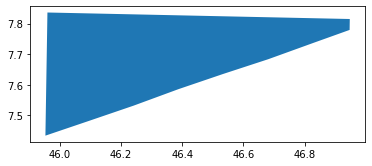

E:\S2_Data_CH22_Original\T32TLS\S2B_MSIL2A_20220807T102559_N0400_R108_T32TLS_20220807T132122.SAFE\INSPIRE.xml


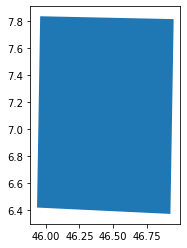

E:\S2_Data_CH22_Original\T32TLS\S2B_MSIL2A_20220810T103629_N0400_R008_T32TLS_20220810T121256.SAFE\INSPIRE.xml


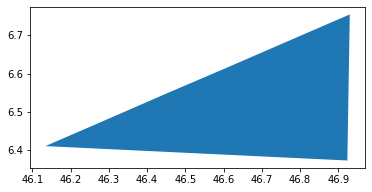

E:\S2_Data_CH22_Original\T32TLS\S2B_MSIL2A_20220817T102559_N0400_R108_T32TLS_20220817T132522.SAFE\INSPIRE.xml


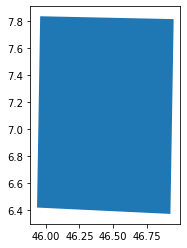

E:\S2_Data_CH22_Original\T32TLS\S2B_MSIL2A_20220820T103629_N0400_R008_T32TLS_20220831T211751.SAFE\INSPIRE.xml


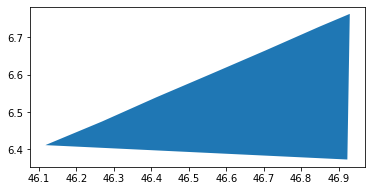

E:\S2_Data_CH22_Original\T32TLS\S2B_MSIL2A_20220824T101559_N0400_R065_T32TLS_20220824T131202.SAFE\INSPIRE.xml


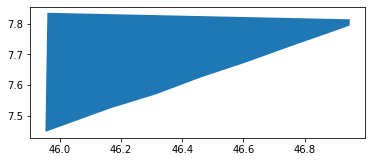

E:\S2_Data_CH22_Original\T32TLS\S2B_MSIL2A_20220827T102559_N0400_R108_T32TLS_20220827T132155.SAFE\INSPIRE.xml


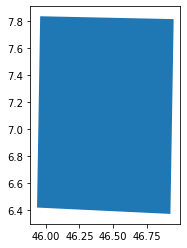

E:\S2_Data_CH22_Original\T32TLS\S2B_MSIL2A_20220830T103629_N0400_R008_T32TLS_20220830T123406.SAFE\INSPIRE.xml


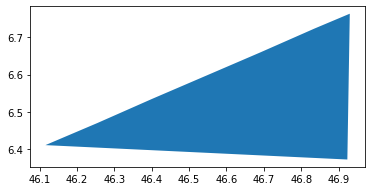

E:\S2_Data_CH22_Original\T32TLS\S2B_MSIL2A_20220903T101559_N0400_R065_T32TLS_20220903T131112.SAFE\INSPIRE.xml


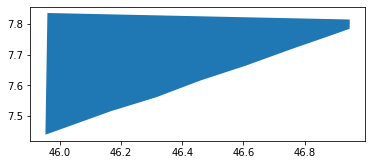

E:\S2_Data_CH22_Original\T32TLS\S2B_MSIL2A_20220906T102559_N0400_R108_T32TLS_20220906T131726.SAFE\INSPIRE.xml


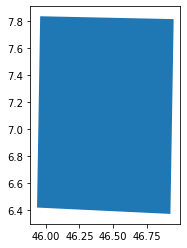

E:\S2_Data_CH22_Original\T32TLS\S2B_MSIL2A_20220909T103629_N0400_R008_T32TLS_20220909T133244.SAFE\INSPIRE.xml


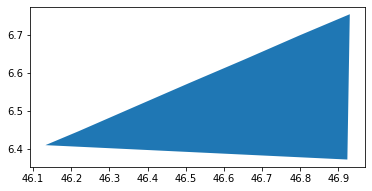

E:\S2_Data_CH22_Original\T32TLS\S2B_MSIL2A_20220916T102639_N0400_R108_T32TLS_20220916T131746.SAFE\INSPIRE.xml


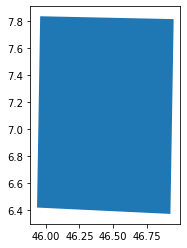

E:\S2_Data_CH22_Original\T32TLS\S2B_MSIL2A_20220919T103639_N0400_R008_T32TLS_20220919T132748.SAFE\INSPIRE.xml


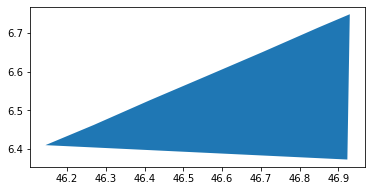

E:\S2_Data_CH22_Original\T32TLS\S2B_MSIL2A_20220923T101649_N0400_R065_T32TLS_20220923T144734.SAFE\INSPIRE.xml


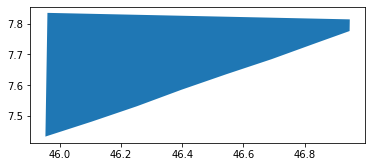

E:\S2_Data_CH22_Original\T32TLS\S2B_MSIL2A_20221003T101749_N0400_R065_T32TLS_20221003T162756.SAFE\INSPIRE.xml


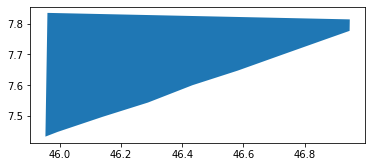

E:\S2_Data_CH22_Original\T32TLS\S2B_MSIL2A_20221006T102949_N0400_R108_T32TLS_20221006T181350.SAFE\INSPIRE.xml


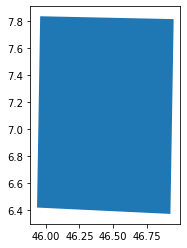

E:\S2_Data_CH22_Original\T32TLS\S2B_MSIL2A_20221009T103839_N0400_R008_T32TLS_20221009T132836.SAFE\INSPIRE.xml


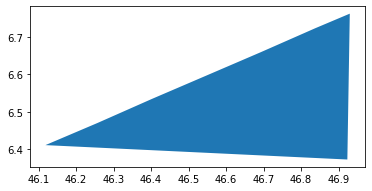

E:\S2_Data_CH22_Original\T32TLS\S2B_MSIL2A_20221013T101859_N0400_R065_T32TLS_20221013T144729.SAFE\INSPIRE.xml


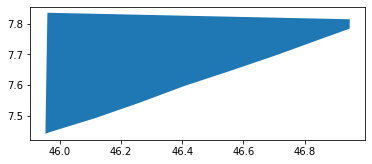

E:\S2_Data_CH22_Original\T32TLS\S2B_MSIL2A_20221016T102919_N0400_R108_T32TLS_20221016T131725.SAFE\INSPIRE.xml


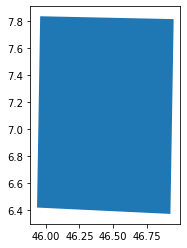

E:\S2_Data_CH22_Original\T32TLS\S2B_MSIL2A_20221019T103949_N0400_R008_T32TLS_20221019T132839.SAFE\INSPIRE.xml


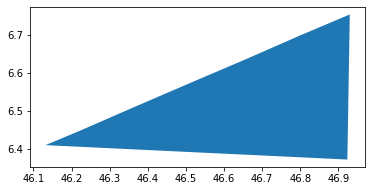

E:\S2_Data_CH22_Original\T32TLS\S2B_MSIL2A_20221026T103029_N0400_R108_T32TLS_20221026T132935.SAFE\INSPIRE.xml


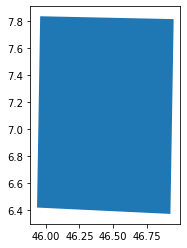

E:\S2_Data_CH22_Original\T32TLS\S2B_MSIL2A_20221102T102059_N0400_R065_T32TLS_20221102T130733.SAFE\INSPIRE.xml


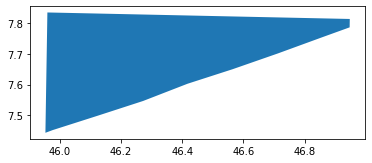

E:\S2_Data_CH22_Original\T32TLS\S2B_MSIL2A_20221105T103119_N0400_R108_T32TLS_20221105T133307.SAFE\INSPIRE.xml


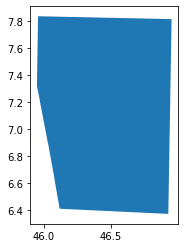

E:\S2_Data_CH22_Original\T32TLS\S2B_MSIL2A_20221105T103119_N0400_R108_T32TLS_20221105T135021.SAFE\INSPIRE.xml


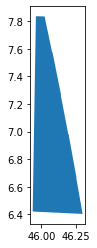

E:\S2_Data_CH22_Original\T32TLS\S2B_MSIL2A_20221108T104149_N0400_R008_T32TLS_20221108T115017.SAFE\INSPIRE.xml


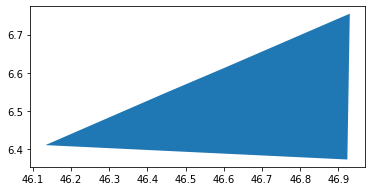

E:\S2_Data_CH22_Original\T32TLS\S2B_MSIL2A_20221112T102159_N0400_R065_T32TLS_20221112T132249.SAFE\INSPIRE.xml


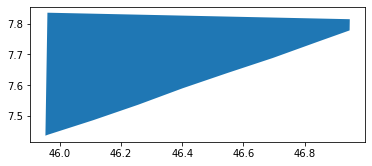

E:\S2_Data_CH22_Original\T32TLS\S2B_MSIL2A_20221118T104229_N0400_R008_T32TLS_20221118T115218.SAFE\INSPIRE.xml


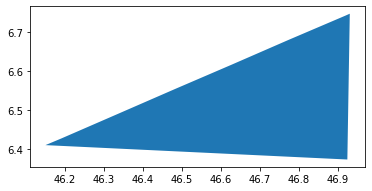

E:\S2_Data_CH22_Original\T32TLS\S2B_MSIL2A_20221122T102239_N0400_R065_T32TLS_20221122T112553.SAFE\INSPIRE.xml


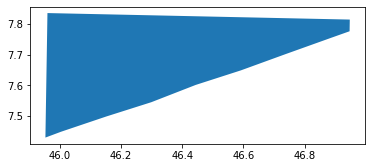

E:\S2_Data_CH22_Original\T32TLS\S2B_MSIL2A_20221125T103259_N0400_R108_T32TLS_20221125T113610.SAFE\INSPIRE.xml


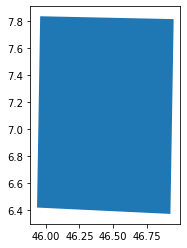

E:\S2_Data_CH22_Original\T32TLS\S2B_MSIL2A_20221202T102309_N0400_R065_T32TLS_20221202T113158.SAFE\INSPIRE.xml


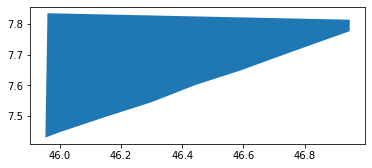

E:\S2_Data_CH22_Original\T32TLS\S2B_MSIL2A_20221205T103319_N0400_R108_T32TLS_20221205T113923.SAFE\INSPIRE.xml


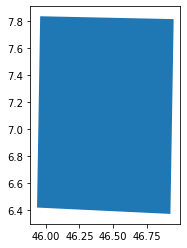

E:\S2_Data_CH22_Original\T32TLS\S2B_MSIL2A_20221208T104329_N0509_R008_T32TLS_20221208T120942.SAFE\INSPIRE.xml


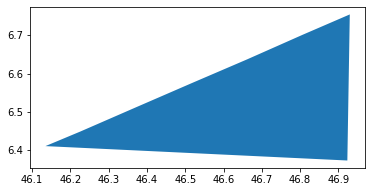

E:\S2_Data_CH22_Original\T32TLS\S2B_MSIL2A_20221222T102339_N0509_R065_T32TLS_20221222T113435.SAFE\INSPIRE.xml


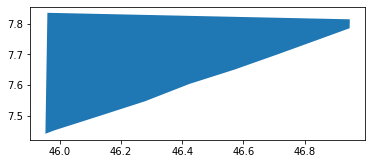

E:\S2_Data_CH22_Original\T32TLS\S2B_MSIL2A_20221225T103349_N0509_R108_T32TLS_20221225T114808.SAFE\INSPIRE.xml


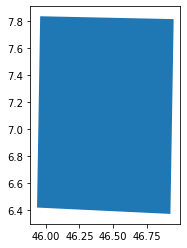

In [8]:
for tile in tiles:
    tile_paths = get_tile_folder_path(Path('E:/S2_Data_CH22_Original/' + str(tile)))
    for i in tile_paths:
        # Path to your XML file
        xml_file_path = i+"\INSPIRE.xml"
        print(xml_file_path)

        # Parse the XML file
        tree = ET.parse(xml_file_path)
        root = tree.getroot()

        # Define the namespace dictionary
        namespace = {
            "gmd": "http://www.isotc211.org/2005/gmd",
            "gco": "http://www.isotc211.org/2005/gco"
        }

        # Define the XPath expression with namespaces
        xpath_expression = "./gmd:identificationInfo/gmd:MD_DataIdentification/gmd:abstract/gco:CharacterString"

        # Find the element using find() with the namespace
        abstract_element = root.find(xpath_expression, namespaces=namespace)

        # Extract the text content
        abstract_text = abstract_element.text if abstract_element is not None else None

        abstract_text= abstract_text.replace(' ',',')
        coordinates_list_str = abstract_text.split(',')
        coordinates_list_str = [coord for coord in coordinates_list_str if coord]
        coordinates_list = [(float(coordinates_list_str[i]), float(coordinates_list_str[i + 1])) for i in range(0, len(coordinates_list_str), 2)]
        coordinates_list
        polygon = Polygon(coordinates_list)

        gdf = gpd.GeoDataFrame(geometry=[polygon])
        gdf.plot()
        plt.show()
        plt.close()

In [ ]:
# read tile data and save to dhf5 files
for tile in tqdm(tiles, desc="Processing tiles", unit="tile"):
    print(f"Start {tile}")
    coords = get_coords(tile,False)
    data_dir = Path('E:/S2_Data_CH22/' + tile)
    tile_paths = get_tile_folder_path(data_dir)
    read_tile_data_from_safe(tile_paths,coords,tile,batch_size=500)
    print(read_tile_data(tile,'data').shape)
    print(f"End {tile}")

In [ ]:
# read tile shapes after succesful save to hdf5 file
for tile in tiles:
    print(tile)
    print(read_tile_data(tile,'data').shape)
    print(read_tile_data(tile,'gt').shape)
    print(read_tile_data(tile,'gt_instance').shape)

In [10]:
# stack all tile data on top of each other to create BernCrop
for i,v in enumerate(tiles):
        tile_data = read_tile_data(tiles[i])
        reshape_modulo = tile_data.shape[0]%53
        tile_data = tile_data[0:tile_data.shape[0]-reshape_modulo]
        reshape_int = int(tile_data.shape[0]/53)
        print(tile_data.shape)
        tile_data = tile_data.reshape(reshape_int,53,4,24,24)
        print(tile_data.shape)
        tile_labels = read_tile_data(tiles[i],'gt')[0:reshape_int]
        tile_field_labels = read_tile_data(tiles[i],'gt_instance')[0:reshape_int]
        save_tile_data(stack_sample_tiles(tile_data,None),'BernCrop',add_axis=False)
        save_tile_data(stack_sample_tiles(tile_labels,None),'BernCrop','gt',add_axis=False)
        save_tile_data(stack_sample_tiles(tile_field_labels,None),'BernCrop','gt_instance',add_axis=False)

(520937, 4, 24, 24)
(9829, 53, 4, 24, 24)
(336868, 4, 24, 24)
(6356, 53, 4, 24, 24)
(316145, 4, 24, 24)
(5965, 53, 4, 24, 24)


In [11]:
read_tile_data('BernCrop','data').shape

(22150, 53, 4, 24, 24)

In [12]:
read_tile_data('BernCrop','gt').shape

(22150, 24, 24)

In [13]:
read_tile_data('BernCrop','gt_instance').shape

(22150, 24, 24)

## Quali Eval

In [9]:
# Convert NumPy array to PyTorch tensor
original_tensor = read_tile_data('BernCrop','data')[4,6,1:4,:,:]

# Clip values to the range [0, 1]
# clipped_tensor = torch.clamp(original_tensor, 0, 1)
# Rescale values to the range [0, 1]
min_value = original_tensor.min()
max_value = original_tensor.max()
rescaled_tensor = (original_tensor - min_value) / (max_value - min_value) 


TypeError: Invalid shape (3, 24, 24) for image data

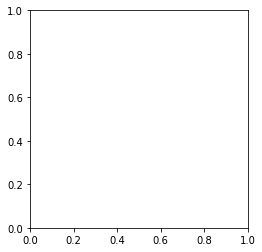

In [10]:
# Display the image
plt.imshow(rescaled_tensor)
plt.title('RGB Image')
plt.show()

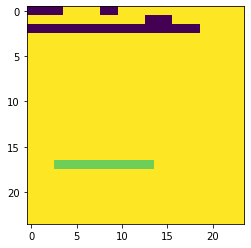

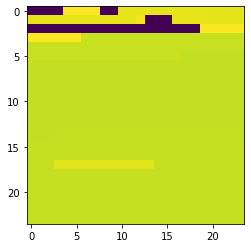

In [ ]:
plt.imshow(read_tile_data('BernCrop','gt')[4])
plt.show()
plt.imshow(read_tile_data('BernCrop','gt_instance')[4])
plt.show()